In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, LayerNormalization, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [3]:
def normalize_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [4]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
x_train = normalize_tanh(x_train.reshape(-1, 28, 28, 1))

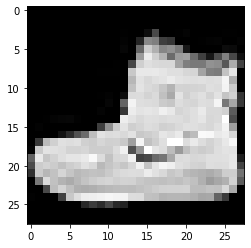

In [6]:
plt.imshow(unnormalize_tanh(normalize_tanh(x_train[0])).reshape(28,28), cmap='gray')

In [7]:
# network parameters
width = 28
height = 28
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(7*7*128)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((7,7,128))(x)


    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)



    img_outputs = Conv2D(1,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        73

In [8]:
def build_critic():
    inputs = Input(shape=(width,height,1), name='critic_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='critic')
build_critic().summary()

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 14, 14, 64)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 7, 7, 128)         256  

In [9]:
generator = build_generator()
critic = build_critic()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [10]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = critic(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_critic(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as critic_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = critic(images, training=True)
        fake_output = critic(generated_images, training=True)
        
        beta = tf.random.uniform(shape=tf.shape(images), minval=0.0, maxval=1.0)
        perturbed_images = images + 0.5 * tf.math.reduce_std(images) * beta
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = perturbed_images - images
        interpolated_images = images + (alpha * diff)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = critic(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        critic_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
    
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

Iteration [1/10000]......5.598(s) gen: 0.07140 - critic_fake: -1.21417 - critic_real: 1.78289 - neg_critic: 2.99706
Iteration [2/10000]......0.126(s) gen: 0.06294 - critic_fake: -3.31150 - critic_real: 6.30653 - neg_critic: 9.61803
Iteration [3/10000]......0.128(s) gen: -0.76986 - critic_fake: -6.24771 - critic_real: 10.51268 - neg_critic: 16.76039
Iteration [4/10000]......0.110(s) gen: -0.55112 - critic_fake: -9.98077 - critic_real: 15.03600 - neg_critic: 25.01677
Iteration [5/10000]......0.113(s) gen: -1.50080 - critic_fake: -14.65835 - critic_real: 18.99937 - neg_critic: 33.65772
Iteration [6/10000]......0.117(s) gen: -2.48747 - critic_fake: -18.53188 - critic_real: 22.59283 - neg_critic: 41.12472
Iteration [7/10000]......0.111(s) gen: -3.03003 - critic_fake: -21.75870 - critic_real: 25.65985 - neg_critic: 47.41855
Iteration [8/10000]......0.113(s) gen: -4.43089 - critic_fake: -24.18770 - critic_real: 28.89746 - neg_critic: 53.08515
Iteration [9/10000]......0.116(s) gen: -5.33514 - 

Iteration [69/10000]......0.110(s) gen: -97.49718 - critic_fake: 44.21699 - critic_real: 98.59244 - neg_critic: 54.37545
Iteration [70/10000]......0.112(s) gen: -97.81335 - critic_fake: 7.28069 - critic_real: 98.74734 - neg_critic: 91.46665
Iteration [71/10000]......0.112(s) gen: -97.94366 - critic_fake: -4.24416 - critic_real: 99.28759 - neg_critic: 103.53174
Iteration [72/10000]......0.113(s) gen: -97.97725 - critic_fake: 73.62534 - critic_real: 99.30773 - neg_critic: 25.68239
Iteration [73/10000]......0.115(s) gen: -97.84801 - critic_fake: 93.29666 - critic_real: 99.07594 - neg_critic: 5.77928
Iteration [74/10000]......0.110(s) gen: -97.93609 - critic_fake: 92.02646 - critic_real: 98.83845 - neg_critic: 6.81199
Iteration [75/10000]......0.111(s) gen: -97.98557 - critic_fake: 89.81915 - critic_real: 98.65574 - neg_critic: 8.83658
Iteration [76/10000]......0.110(s) gen: -98.15969 - critic_fake: 85.82510 - critic_real: 98.42047 - neg_critic: 12.59537
Iteration [77/10000]......0.110(s) 

Iteration [137/10000]......0.112(s) gen: -115.24280 - critic_fake: 76.86586 - critic_real: 110.80835 - neg_critic: 33.94249
Iteration [138/10000]......0.110(s) gen: -115.57151 - critic_fake: 49.07340 - critic_real: 110.13470 - neg_critic: 61.06129
Iteration [139/10000]......0.111(s) gen: -116.71246 - critic_fake: -61.46463 - critic_real: 110.47616 - neg_critic: 171.94079
Iteration [140/10000]......0.113(s) gen: -117.05983 - critic_fake: 2.08300 - critic_real: 112.60368 - neg_critic: 110.52068
Iteration [141/10000]......0.113(s) gen: -118.04050 - critic_fake: -99.04978 - critic_real: 112.97878 - neg_critic: 212.02856
Iteration [142/10000]......0.111(s) gen: -119.28534 - critic_fake: -105.93822 - critic_real: 115.57098 - neg_critic: 221.50921
Iteration [143/10000]......0.111(s) gen: -120.52252 - critic_fake: -108.37058 - critic_real: 117.34810 - neg_critic: 225.71869
Iteration [144/10000]......0.113(s) gen: -121.59220 - critic_fake: -116.92925 - critic_real: 118.62237 - neg_critic: 235.5

Iteration [203/10000]......0.113(s) gen: -164.90805 - critic_fake: -166.17504 - critic_real: 163.34568 - neg_critic: 329.52072
Iteration [204/10000]......0.111(s) gen: -166.08316 - critic_fake: -166.24960 - critic_real: 164.43076 - neg_critic: 330.68036
Iteration [205/10000]......0.111(s) gen: -166.97827 - critic_fake: -37.95629 - critic_real: 165.55775 - neg_critic: 203.51404
Iteration [206/10000]......0.111(s) gen: -167.33128 - critic_fake: -64.82378 - critic_real: 164.92339 - neg_critic: 229.74716
Iteration [207/10000]......0.111(s) gen: -167.90675 - critic_fake: -86.70367 - critic_real: 166.12677 - neg_critic: 252.83044
Iteration [208/10000]......0.111(s) gen: -169.03873 - critic_fake: -167.15752 - critic_real: 166.88470 - neg_critic: 334.04222
Iteration [209/10000]......0.113(s) gen: -170.18129 - critic_fake: -170.28319 - critic_real: 168.34836 - neg_critic: 338.63155
Iteration [210/10000]......0.112(s) gen: -171.29968 - critic_fake: -172.06221 - critic_real: 169.38771 - neg_criti

Iteration [269/10000]......0.113(s) gen: -187.76543 - critic_fake: -81.19498 - critic_real: 184.65737 - neg_critic: 265.85235
Iteration [270/10000]......0.111(s) gen: -188.65234 - critic_fake: -174.95367 - critic_real: 183.91101 - neg_critic: 358.86468
Iteration [271/10000]......0.113(s) gen: -189.63959 - critic_fake: -177.65947 - critic_real: 185.65018 - neg_critic: 363.30966
Iteration [272/10000]......0.111(s) gen: -190.65997 - critic_fake: -183.00729 - critic_real: 187.20584 - neg_critic: 370.21313
Iteration [273/10000]......0.111(s) gen: -191.76042 - critic_fake: -186.91075 - critic_real: 188.32409 - neg_critic: 375.23484
Iteration [274/10000]......0.112(s) gen: -192.83548 - critic_fake: -188.76619 - critic_real: 189.61943 - neg_critic: 378.38563
Iteration [275/10000]......0.114(s) gen: -193.91745 - critic_fake: -187.94524 - critic_real: 191.24809 - neg_critic: 379.19333
Iteration [276/10000]......0.113(s) gen: -194.74275 - critic_fake: -194.69832 - critic_real: 192.40850 - neg_cri

Iteration [335/10000]......0.114(s) gen: -216.27655 - critic_fake: 197.88143 - critic_real: 213.31906 - neg_critic: 15.43763
Iteration [336/10000]......0.117(s) gen: -216.30579 - critic_fake: 197.03662 - critic_real: 213.43134 - neg_critic: 16.39472
Iteration [337/10000]......0.113(s) gen: -216.32362 - critic_fake: 195.85833 - critic_real: 213.39101 - neg_critic: 17.53267
Iteration [338/10000]......0.113(s) gen: -216.38654 - critic_fake: 194.23195 - critic_real: 213.36272 - neg_critic: 19.13077
Iteration [339/10000]......0.112(s) gen: -216.35901 - critic_fake: 192.17572 - critic_real: 212.76238 - neg_critic: 20.58665
Iteration [340/10000]......0.113(s) gen: -216.40044 - critic_fake: 189.28434 - critic_real: 212.65370 - neg_critic: 23.36935
Iteration [341/10000]......0.114(s) gen: -216.34756 - critic_fake: 185.08668 - critic_real: 212.56587 - neg_critic: 27.47919
Iteration [342/10000]......0.114(s) gen: -216.31416 - critic_fake: 179.36331 - critic_real: 212.11458 - neg_critic: 32.75128


Iteration [401/10000]......0.113(s) gen: -231.20065 - critic_fake: 190.60759 - critic_real: 226.65926 - neg_critic: 36.05167
Iteration [402/10000]......0.114(s) gen: -231.00305 - critic_fake: 203.36807 - critic_real: 226.76280 - neg_critic: 23.39473
Iteration [403/10000]......0.116(s) gen: -230.82321 - critic_fake: 185.83769 - critic_real: 225.81420 - neg_critic: 39.97651
Iteration [404/10000]......0.114(s) gen: -230.97397 - critic_fake: 117.79320 - critic_real: 224.86141 - neg_critic: 107.06821
Iteration [405/10000]......0.116(s) gen: -232.52011 - critic_fake: -27.18813 - critic_real: 225.09156 - neg_critic: 252.27968
Iteration [406/10000]......0.114(s) gen: -232.42166 - critic_fake: 185.99898 - critic_real: 228.93331 - neg_critic: 42.93433
Iteration [407/10000]......0.114(s) gen: -232.29410 - critic_fake: 220.70221 - critic_real: 228.73698 - neg_critic: 8.03477
Iteration [408/10000]......0.115(s) gen: -232.13531 - critic_fake: 218.69611 - critic_real: 228.43092 - neg_critic: 9.73481


Iteration [467/10000]......0.113(s) gen: -228.80205 - critic_fake: 83.44576 - critic_real: 224.62459 - neg_critic: 141.17884
Iteration [468/10000]......0.113(s) gen: -229.45029 - critic_fake: 57.21509 - critic_real: 224.91114 - neg_critic: 167.69605
Iteration [469/10000]......0.113(s) gen: -229.87317 - critic_fake: 27.82490 - critic_real: 225.70621 - neg_critic: 197.88132
Iteration [470/10000]......0.112(s) gen: -229.90492 - critic_fake: 64.53977 - critic_real: 226.25616 - neg_critic: 161.71639
Iteration [471/10000]......0.113(s) gen: -230.07439 - critic_fake: 75.39808 - critic_real: 226.89002 - neg_critic: 151.49194
Iteration [472/10000]......0.114(s) gen: -230.38512 - critic_fake: 36.64972 - critic_real: 226.48050 - neg_critic: 189.83077
Iteration [473/10000]......0.112(s) gen: -231.06963 - critic_fake: 27.58849 - critic_real: 227.00894 - neg_critic: 199.42045
Iteration [474/10000]......0.112(s) gen: -230.80563 - critic_fake: 22.12144 - critic_real: 227.21313 - neg_critic: 205.09169


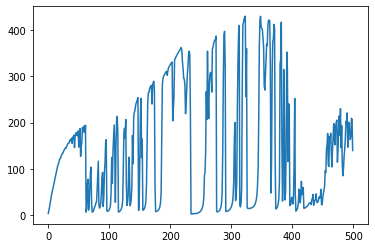

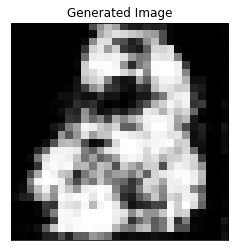

Iteration [501/10000]......0.115(s) gen: -231.99503 - critic_fake: 100.79666 - critic_real: 232.10643 - neg_critic: 131.30977
Iteration [502/10000]......0.113(s) gen: -232.11877 - critic_fake: 41.64094 - critic_real: 232.08426 - neg_critic: 190.44332
Iteration [503/10000]......0.113(s) gen: -232.68692 - critic_fake: 32.29693 - critic_real: 233.10993 - neg_critic: 200.81300
Iteration [504/10000]......0.118(s) gen: -232.24185 - critic_fake: 18.12020 - critic_real: 233.35756 - neg_critic: 215.23736
Iteration [505/10000]......0.112(s) gen: -232.02563 - critic_fake: 85.03237 - critic_real: 233.10785 - neg_critic: 148.07548
Iteration [506/10000]......0.112(s) gen: -231.43727 - critic_fake: 29.35169 - critic_real: 233.27949 - neg_critic: 203.92780
Iteration [507/10000]......0.112(s) gen: -234.30576 - critic_fake: 67.31624 - critic_real: 234.31758 - neg_critic: 167.00134
Iteration [508/10000]......0.113(s) gen: -234.07637 - critic_fake: 71.39668 - critic_real: 234.40705 - neg_critic: 163.01038

Iteration [568/10000]......0.112(s) gen: -126.58281 - critic_fake: 60.66723 - critic_real: 246.11833 - neg_critic: 185.45110
Iteration [569/10000]......0.113(s) gen: -230.48877 - critic_fake: 138.07869 - critic_real: 246.25099 - neg_critic: 108.17230
Iteration [570/10000]......0.112(s) gen: -209.84143 - critic_fake: 160.94113 - critic_real: 246.29117 - neg_critic: 85.35003
Iteration [571/10000]......0.111(s) gen: -224.65709 - critic_fake: 135.16672 - critic_real: 246.30350 - neg_critic: 111.13678
Iteration [572/10000]......0.112(s) gen: -233.30249 - critic_fake: 147.18623 - critic_real: 246.63078 - neg_critic: 99.44455
Iteration [573/10000]......0.112(s) gen: -226.86278 - critic_fake: 191.48038 - critic_real: 247.01436 - neg_critic: 55.53398
Iteration [574/10000]......0.113(s) gen: -142.65533 - critic_fake: 125.99236 - critic_real: 246.32436 - neg_critic: 120.33201
Iteration [575/10000]......0.114(s) gen: -151.25201 - critic_fake: 100.09854 - critic_real: 247.06544 - neg_critic: 146.96

Iteration [634/10000]......0.115(s) gen: -221.11836 - critic_fake: 224.40438 - critic_real: 249.33798 - neg_critic: 24.93361
Iteration [635/10000]......0.111(s) gen: -220.72762 - critic_fake: 225.93418 - critic_real: 249.26797 - neg_critic: 23.33379
Iteration [636/10000]......0.113(s) gen: -219.96240 - critic_fake: 225.27392 - critic_real: 249.31836 - neg_critic: 24.04444
Iteration [637/10000]......0.111(s) gen: -218.23154 - critic_fake: 224.12518 - critic_real: 249.51483 - neg_critic: 25.38966
Iteration [638/10000]......0.113(s) gen: -215.65714 - critic_fake: 222.86147 - critic_real: 249.02643 - neg_critic: 26.16496
Iteration [639/10000]......0.112(s) gen: -217.49921 - critic_fake: 222.01382 - critic_real: 248.55573 - neg_critic: 26.54191
Iteration [640/10000]......0.112(s) gen: -218.18666 - critic_fake: 221.90965 - critic_real: 248.10783 - neg_critic: 26.19819
Iteration [641/10000]......0.111(s) gen: -213.47238 - critic_fake: 221.73954 - critic_real: 248.62366 - neg_critic: 26.88413


Iteration [700/10000]......0.114(s) gen: -205.54887 - critic_fake: 209.76129 - critic_real: 247.27040 - neg_critic: 37.50911
Iteration [701/10000]......0.112(s) gen: -217.84464 - critic_fake: 200.15170 - critic_real: 246.83991 - neg_critic: 46.68821
Iteration [702/10000]......0.113(s) gen: -200.22733 - critic_fake: 214.01059 - critic_real: 249.29386 - neg_critic: 35.28327
Iteration [703/10000]......0.113(s) gen: -195.97482 - critic_fake: 198.15799 - critic_real: 247.87241 - neg_critic: 49.71442
Iteration [704/10000]......0.114(s) gen: -224.44809 - critic_fake: 206.59155 - critic_real: 249.57273 - neg_critic: 42.98117
Iteration [705/10000]......0.114(s) gen: -225.20175 - critic_fake: 226.03231 - critic_real: 248.88708 - neg_critic: 22.85477
Iteration [706/10000]......0.115(s) gen: -222.41849 - critic_fake: 224.29797 - critic_real: 250.08857 - neg_critic: 25.79060
Iteration [707/10000]......0.113(s) gen: -221.69075 - critic_fake: 223.44094 - critic_real: 249.25613 - neg_critic: 25.81519


Iteration [766/10000]......0.117(s) gen: -220.70522 - critic_fake: 217.05596 - critic_real: 244.96531 - neg_critic: 27.90934
Iteration [767/10000]......0.117(s) gen: -226.44733 - critic_fake: 215.47258 - critic_real: 245.27305 - neg_critic: 29.80047
Iteration [768/10000]......0.115(s) gen: -215.46481 - critic_fake: 219.16590 - critic_real: 247.21222 - neg_critic: 28.04633
Iteration [769/10000]......0.117(s) gen: -226.06198 - critic_fake: 214.17839 - critic_real: 247.68591 - neg_critic: 33.50753
Iteration [770/10000]......0.115(s) gen: -218.02251 - critic_fake: 221.34826 - critic_real: 244.63923 - neg_critic: 23.29097
Iteration [771/10000]......0.115(s) gen: -217.35837 - critic_fake: 217.89843 - critic_real: 245.02744 - neg_critic: 27.12902
Iteration [772/10000]......0.117(s) gen: -227.91324 - critic_fake: 218.09695 - critic_real: 245.71629 - neg_critic: 27.61934
Iteration [773/10000]......0.115(s) gen: -224.35378 - critic_fake: 221.62791 - critic_real: 247.27898 - neg_critic: 25.65107


Iteration [832/10000]......0.116(s) gen: -239.06500 - critic_fake: 231.40480 - critic_real: 247.08406 - neg_critic: 15.67926
Iteration [833/10000]......0.114(s) gen: -233.82698 - critic_fake: 229.90834 - critic_real: 245.00625 - neg_critic: 15.09790
Iteration [834/10000]......0.115(s) gen: -230.42894 - critic_fake: 223.75996 - critic_real: 244.51463 - neg_critic: 20.75467
Iteration [835/10000]......0.115(s) gen: -226.94894 - critic_fake: 222.19693 - critic_real: 244.66407 - neg_critic: 22.46714
Iteration [836/10000]......0.114(s) gen: -236.82735 - critic_fake: 230.46762 - critic_real: 245.34243 - neg_critic: 14.87481
Iteration [837/10000]......0.114(s) gen: -235.35565 - critic_fake: 230.71215 - critic_real: 244.44593 - neg_critic: 13.73379
Iteration [838/10000]......0.115(s) gen: -234.44040 - critic_fake: 228.11607 - critic_real: 244.26765 - neg_critic: 16.15157
Iteration [839/10000]......0.113(s) gen: -231.05342 - critic_fake: 225.09285 - critic_real: 243.67820 - neg_critic: 18.58535


Iteration [898/10000]......0.117(s) gen: -234.55688 - critic_fake: 232.10918 - critic_real: 241.63162 - neg_critic: 9.52244
Iteration [899/10000]......0.114(s) gen: -233.38538 - critic_fake: 231.41933 - critic_real: 241.51953 - neg_critic: 10.10020
Iteration [900/10000]......0.115(s) gen: -233.75719 - critic_fake: 231.37718 - critic_real: 241.86080 - neg_critic: 10.48362
Iteration [901/10000]......0.115(s) gen: -233.72018 - critic_fake: 232.56604 - critic_real: 242.63477 - neg_critic: 10.06873
Iteration [902/10000]......0.117(s) gen: -233.75735 - critic_fake: 230.51565 - critic_real: 241.89933 - neg_critic: 11.38368
Iteration [903/10000]......0.117(s) gen: -234.31253 - critic_fake: 229.66564 - critic_real: 243.64236 - neg_critic: 13.97672
Iteration [904/10000]......0.116(s) gen: -234.99927 - critic_fake: 231.61863 - critic_real: 245.65656 - neg_critic: 14.03792
Iteration [905/10000]......0.115(s) gen: -237.19765 - critic_fake: 230.72842 - critic_real: 245.24773 - neg_critic: 14.51930
I

Iteration [964/10000]......0.119(s) gen: -208.90225 - critic_fake: 226.84280 - critic_real: 240.47161 - neg_critic: 13.62881
Iteration [965/10000]......0.116(s) gen: -234.73969 - critic_fake: 231.50167 - critic_real: 242.50474 - neg_critic: 11.00307
Iteration [966/10000]......0.117(s) gen: -229.61682 - critic_fake: 232.72695 - critic_real: 240.10152 - neg_critic: 7.37457
Iteration [967/10000]......0.114(s) gen: -226.82051 - critic_fake: 227.42084 - critic_real: 237.88499 - neg_critic: 10.46414
Iteration [968/10000]......0.116(s) gen: -229.87645 - critic_fake: 228.12323 - critic_real: 238.81873 - neg_critic: 10.69550
Iteration [969/10000]......0.115(s) gen: -229.10551 - critic_fake: 228.59412 - critic_real: 240.55456 - neg_critic: 11.96045
Iteration [970/10000]......0.127(s) gen: -223.78249 - critic_fake: 231.58135 - critic_real: 242.52945 - neg_critic: 10.94810
Iteration [971/10000]......0.115(s) gen: -231.25790 - critic_fake: 231.83788 - critic_real: 242.46996 - neg_critic: 10.63208
I

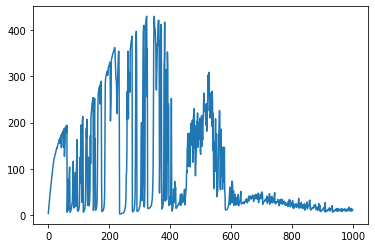

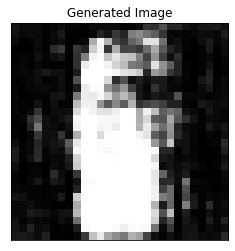

Iteration [1001/10000]......0.117(s) gen: -231.76192 - critic_fake: 226.51627 - critic_real: 241.28404 - neg_critic: 14.76777
Iteration [1002/10000]......0.115(s) gen: -229.09918 - critic_fake: 227.95130 - critic_real: 239.83529 - neg_critic: 11.88399
Iteration [1003/10000]......0.113(s) gen: -228.05116 - critic_fake: 227.45131 - critic_real: 237.94725 - neg_critic: 10.49594
Iteration [1004/10000]......0.113(s) gen: -227.95947 - critic_fake: 227.42446 - critic_real: 239.41827 - neg_critic: 11.99381
Iteration [1005/10000]......0.114(s) gen: -235.18779 - critic_fake: 227.39268 - critic_real: 241.84622 - neg_critic: 14.45354
Iteration [1006/10000]......0.119(s) gen: -232.40764 - critic_fake: 234.53939 - critic_real: 242.49087 - neg_critic: 7.95148
Iteration [1007/10000]......0.116(s) gen: -230.29321 - critic_fake: 230.92273 - critic_real: 239.53484 - neg_critic: 8.61211
Iteration [1008/10000]......0.117(s) gen: -229.88489 - critic_fake: 229.79815 - critic_real: 239.35966 - neg_critic: 9.5

Iteration [1066/10000]......0.116(s) gen: -235.95682 - critic_fake: 231.83646 - critic_real: 244.07520 - neg_critic: 12.23874
Iteration [1067/10000]......0.117(s) gen: -231.90222 - critic_fake: 234.62664 - critic_real: 242.90035 - neg_critic: 8.27371
Iteration [1068/10000]......0.117(s) gen: -231.82880 - critic_fake: 231.25538 - critic_real: 240.40340 - neg_critic: 9.14802
Iteration [1069/10000]......0.119(s) gen: -231.54984 - critic_fake: 231.09650 - critic_real: 240.79020 - neg_critic: 9.69370
Iteration [1070/10000]......0.118(s) gen: -230.62413 - critic_fake: 230.94128 - critic_real: 241.84508 - neg_critic: 10.90380
Iteration [1071/10000]......0.120(s) gen: -229.53047 - critic_fake: 230.67672 - critic_real: 242.03088 - neg_critic: 11.35416
Iteration [1072/10000]......0.118(s) gen: -230.62135 - critic_fake: 231.68437 - critic_real: 243.54206 - neg_critic: 11.85769
Iteration [1073/10000]......0.116(s) gen: -230.96848 - critic_fake: 233.01881 - critic_real: 244.55253 - neg_critic: 11.5

Iteration [1132/10000]......0.117(s) gen: -235.52090 - critic_fake: 236.07678 - critic_real: 247.80647 - neg_critic: 11.72969
Iteration [1133/10000]......0.116(s) gen: -232.54269 - critic_fake: 235.21913 - critic_real: 247.84840 - neg_critic: 12.62927
Iteration [1134/10000]......0.116(s) gen: -236.97256 - critic_fake: 236.60270 - critic_real: 247.72597 - neg_critic: 11.12327
Iteration [1135/10000]......0.117(s) gen: -237.68687 - critic_fake: 236.08214 - critic_real: 246.69437 - neg_critic: 10.61223
Iteration [1136/10000]......0.115(s) gen: -239.24106 - critic_fake: 235.97921 - critic_real: 247.47264 - neg_critic: 11.49344
Iteration [1137/10000]......0.116(s) gen: -235.23517 - critic_fake: 238.00648 - critic_real: 247.54936 - neg_critic: 9.54288
Iteration [1138/10000]......0.118(s) gen: -232.21954 - critic_fake: 234.89895 - critic_real: 247.09980 - neg_critic: 12.20085
Iteration [1139/10000]......0.116(s) gen: -240.52301 - critic_fake: 232.35716 - critic_real: 248.00172 - neg_critic: 15

Iteration [1197/10000]......0.120(s) gen: -238.70625 - critic_fake: 237.75411 - critic_real: 248.80263 - neg_critic: 11.04853
Iteration [1198/10000]......0.118(s) gen: -236.12332 - critic_fake: 238.51852 - critic_real: 249.81737 - neg_critic: 11.29885
Iteration [1199/10000]......0.117(s) gen: -236.36333 - critic_fake: 236.33619 - critic_real: 248.92239 - neg_critic: 12.58620
Iteration [1200/10000]......0.119(s) gen: -237.11549 - critic_fake: 236.21299 - critic_real: 249.19929 - neg_critic: 12.98631
Iteration [1201/10000]......0.117(s) gen: -233.41599 - critic_fake: 236.42646 - critic_real: 249.66133 - neg_critic: 13.23488
Iteration [1202/10000]......0.119(s) gen: -238.62933 - critic_fake: 240.29105 - critic_real: 249.46875 - neg_critic: 9.17770
Iteration [1203/10000]......0.117(s) gen: -238.68648 - critic_fake: 237.98979 - critic_real: 248.12603 - neg_critic: 10.13624
Iteration [1204/10000]......0.117(s) gen: -237.93463 - critic_fake: 237.36698 - critic_real: 248.72017 - neg_critic: 11

Iteration [1262/10000]......0.119(s) gen: -239.83310 - critic_fake: 238.29183 - critic_real: 249.62472 - neg_critic: 11.33289
Iteration [1263/10000]......0.117(s) gen: -237.53635 - critic_fake: 238.27224 - critic_real: 248.40660 - neg_critic: 10.13436
Iteration [1264/10000]......0.118(s) gen: -236.39505 - critic_fake: 237.51772 - critic_real: 248.41970 - neg_critic: 10.90198
Iteration [1265/10000]......0.116(s) gen: -238.87512 - critic_fake: 236.64864 - critic_real: 249.27410 - neg_critic: 12.62546
Iteration [1266/10000]......0.117(s) gen: -229.54781 - critic_fake: 237.70482 - critic_real: 249.74130 - neg_critic: 12.03647
Iteration [1267/10000]......0.117(s) gen: -239.44316 - critic_fake: 238.19150 - critic_real: 249.54722 - neg_critic: 11.35572
Iteration [1268/10000]......0.120(s) gen: -236.15822 - critic_fake: 238.30034 - critic_real: 248.34497 - neg_critic: 10.04462
Iteration [1269/10000]......0.121(s) gen: -239.03348 - critic_fake: 237.77163 - critic_real: 248.80379 - neg_critic: 1

Iteration [1327/10000]......0.119(s) gen: -236.75282 - critic_fake: 235.56275 - critic_real: 248.92462 - neg_critic: 13.36187
Iteration [1328/10000]......0.117(s) gen: -237.55882 - critic_fake: 239.77250 - critic_real: 250.90106 - neg_critic: 11.12856
Iteration [1329/10000]......0.116(s) gen: -235.48697 - critic_fake: 239.27076 - critic_real: 250.24177 - neg_critic: 10.97100
Iteration [1330/10000]......0.119(s) gen: -239.92966 - critic_fake: 237.78200 - critic_real: 248.68285 - neg_critic: 10.90085
Iteration [1331/10000]......0.118(s) gen: -237.49487 - critic_fake: 239.12740 - critic_real: 249.09215 - neg_critic: 9.96476
Iteration [1332/10000]......0.117(s) gen: -240.36417 - critic_fake: 238.18197 - critic_real: 248.95310 - neg_critic: 10.77114
Iteration [1333/10000]......0.116(s) gen: -239.05638 - critic_fake: 238.08372 - critic_real: 248.93802 - neg_critic: 10.85431
Iteration [1334/10000]......0.116(s) gen: -236.44608 - critic_fake: 238.97158 - critic_real: 248.07821 - neg_critic: 9.

Iteration [1392/10000]......0.119(s) gen: -234.19009 - critic_fake: 237.92684 - critic_real: 247.09933 - neg_critic: 9.17249
Iteration [1393/10000]......0.120(s) gen: -235.63425 - critic_fake: 236.45821 - critic_real: 246.85024 - neg_critic: 10.39203
Iteration [1394/10000]......0.117(s) gen: -239.39474 - critic_fake: 238.42108 - critic_real: 248.78132 - neg_critic: 10.36024
Iteration [1395/10000]......0.117(s) gen: -237.41850 - critic_fake: 238.77003 - critic_real: 249.46843 - neg_critic: 10.69839
Iteration [1396/10000]......0.116(s) gen: -239.09882 - critic_fake: 234.72531 - critic_real: 248.48145 - neg_critic: 13.75613
Iteration [1397/10000]......0.116(s) gen: -238.51973 - critic_fake: 239.15272 - critic_real: 248.13812 - neg_critic: 8.98540
Iteration [1398/10000]......0.118(s) gen: -236.96573 - critic_fake: 238.61367 - critic_real: 248.73027 - neg_critic: 10.11660
Iteration [1399/10000]......0.117(s) gen: -236.12270 - critic_fake: 237.31505 - critic_real: 248.38043 - neg_critic: 11.

Iteration [1457/10000]......0.119(s) gen: -236.27882 - critic_fake: 237.22774 - critic_real: 248.43734 - neg_critic: 11.20960
Iteration [1458/10000]......0.117(s) gen: -234.98169 - critic_fake: 236.62090 - critic_real: 248.93083 - neg_critic: 12.30993
Iteration [1459/10000]......0.122(s) gen: -240.45425 - critic_fake: 238.81040 - critic_real: 249.16250 - neg_critic: 10.35211
Iteration [1460/10000]......0.117(s) gen: -238.09338 - critic_fake: 239.22990 - critic_real: 247.63951 - neg_critic: 8.40962
Iteration [1461/10000]......0.119(s) gen: -237.27660 - critic_fake: 238.38513 - critic_real: 247.49742 - neg_critic: 9.11229
Iteration [1462/10000]......0.119(s) gen: -236.76025 - critic_fake: 236.57092 - critic_real: 246.79099 - neg_critic: 10.22007
Iteration [1463/10000]......0.115(s) gen: -237.11821 - critic_fake: 236.53225 - critic_real: 246.54857 - neg_critic: 10.01631
Iteration [1464/10000]......0.119(s) gen: -237.72932 - critic_fake: 237.62401 - critic_real: 247.56087 - neg_critic: 9.9

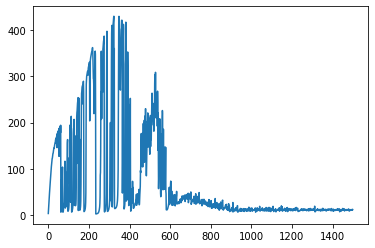

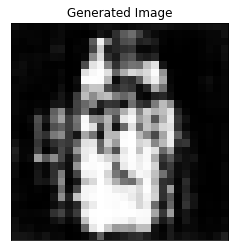

Iteration [1501/10000]......0.121(s) gen: -237.34044 - critic_fake: 236.92955 - critic_real: 247.33108 - neg_critic: 10.40153
Iteration [1502/10000]......0.116(s) gen: -241.00919 - critic_fake: 236.48560 - critic_real: 246.22915 - neg_critic: 9.74355
Iteration [1503/10000]......0.119(s) gen: -234.01608 - critic_fake: 239.28459 - critic_real: 247.54128 - neg_critic: 8.25670
Iteration [1504/10000]......0.117(s) gen: -236.36877 - critic_fake: 234.59987 - critic_real: 245.73471 - neg_critic: 11.13484
Iteration [1505/10000]......0.118(s) gen: -235.51120 - critic_fake: 236.61345 - critic_real: 246.07953 - neg_critic: 9.46609
Iteration [1506/10000]......0.116(s) gen: -237.16203 - critic_fake: 236.91271 - critic_real: 246.97291 - neg_critic: 10.06020
Iteration [1507/10000]......0.118(s) gen: -241.49149 - critic_fake: 236.93136 - critic_real: 247.66540 - neg_critic: 10.73404
Iteration [1508/10000]......0.116(s) gen: -235.50803 - critic_fake: 239.41075 - critic_real: 247.49500 - neg_critic: 8.08

Iteration [1566/10000]......0.116(s) gen: -232.20126 - critic_fake: 235.69657 - critic_real: 247.67604 - neg_critic: 11.97947
Iteration [1567/10000]......0.115(s) gen: -240.58502 - critic_fake: 233.76078 - critic_real: 248.18676 - neg_critic: 14.42599
Iteration [1568/10000]......0.117(s) gen: -237.61592 - critic_fake: 239.71720 - critic_real: 247.80451 - neg_critic: 8.08730
Iteration [1569/10000]......0.115(s) gen: -237.68097 - critic_fake: 237.81637 - critic_real: 247.37502 - neg_critic: 9.55865
Iteration [1570/10000]......0.116(s) gen: -238.10056 - critic_fake: 237.64658 - critic_real: 246.71433 - neg_critic: 9.06775
Iteration [1571/10000]......0.117(s) gen: -235.61319 - critic_fake: 237.61614 - critic_real: 247.52495 - neg_critic: 9.90881
Iteration [1572/10000]......0.117(s) gen: -237.98257 - critic_fake: 236.90797 - critic_real: 246.92844 - neg_critic: 10.02047
Iteration [1573/10000]......0.118(s) gen: -237.37894 - critic_fake: 237.91348 - critic_real: 247.56698 - neg_critic: 9.653

Iteration [1631/10000]......0.121(s) gen: -238.80569 - critic_fake: 235.50667 - critic_real: 248.18194 - neg_critic: 12.67527
Iteration [1632/10000]......0.120(s) gen: -237.17575 - critic_fake: 237.11626 - critic_real: 248.42312 - neg_critic: 11.30685
Iteration [1633/10000]......0.121(s) gen: -237.70801 - critic_fake: 238.43179 - critic_real: 247.03182 - neg_critic: 8.60003
Iteration [1634/10000]......0.121(s) gen: -239.64882 - critic_fake: 236.08929 - critic_real: 246.57126 - neg_critic: 10.48197
Iteration [1635/10000]......0.119(s) gen: -238.67459 - critic_fake: 238.17495 - critic_real: 247.92971 - neg_critic: 9.75476
Iteration [1636/10000]......0.121(s) gen: -234.69063 - critic_fake: 236.06561 - critic_real: 247.96964 - neg_critic: 11.90403
Iteration [1637/10000]......0.120(s) gen: -236.50027 - critic_fake: 236.36570 - critic_real: 247.08980 - neg_critic: 10.72410
Iteration [1638/10000]......0.118(s) gen: -235.28816 - critic_fake: 235.94221 - critic_real: 247.01170 - neg_critic: 11.

Iteration [1697/10000]......0.120(s) gen: -237.26167 - critic_fake: 237.59769 - critic_real: 247.62954 - neg_critic: 10.03186
Iteration [1698/10000]......0.120(s) gen: -236.61295 - critic_fake: 237.63248 - critic_real: 247.73460 - neg_critic: 10.10212
Iteration [1699/10000]......0.118(s) gen: -235.04532 - critic_fake: 235.88907 - critic_real: 246.86908 - neg_critic: 10.98001
Iteration [1700/10000]......0.118(s) gen: -239.00841 - critic_fake: 236.55860 - critic_real: 247.60880 - neg_critic: 11.05020
Iteration [1701/10000]......0.117(s) gen: -237.51662 - critic_fake: 237.26689 - critic_real: 248.07632 - neg_critic: 10.80942
Iteration [1702/10000]......0.117(s) gen: -237.55074 - critic_fake: 236.02435 - critic_real: 248.36087 - neg_critic: 12.33652
Iteration [1703/10000]......0.118(s) gen: -237.21085 - critic_fake: 236.44541 - critic_real: 248.39672 - neg_critic: 11.95132
Iteration [1704/10000]......0.119(s) gen: -236.92827 - critic_fake: 237.31441 - critic_real: 247.97075 - neg_critic: 1

Iteration [1762/10000]......0.116(s) gen: -232.07208 - critic_fake: 234.15520 - critic_real: 246.08716 - neg_critic: 11.93196
Iteration [1763/10000]......0.118(s) gen: -232.11749 - critic_fake: 234.10727 - critic_real: 245.20864 - neg_critic: 11.10137
Iteration [1764/10000]......0.121(s) gen: -239.04973 - critic_fake: 234.23021 - critic_real: 246.57350 - neg_critic: 12.34330
Iteration [1765/10000]......0.120(s) gen: -234.93732 - critic_fake: 236.43448 - critic_real: 248.06685 - neg_critic: 11.63237
Iteration [1766/10000]......0.122(s) gen: -232.83945 - critic_fake: 234.88075 - critic_real: 247.02453 - neg_critic: 12.14377
Iteration [1767/10000]......0.124(s) gen: -236.05148 - critic_fake: 234.47509 - critic_real: 246.48303 - neg_critic: 12.00794
Iteration [1768/10000]......0.123(s) gen: -236.55206 - critic_fake: 237.78761 - critic_real: 246.52568 - neg_critic: 8.73808
Iteration [1769/10000]......0.125(s) gen: -233.87491 - critic_fake: 235.69882 - critic_real: 246.62056 - neg_critic: 10

Iteration [1827/10000]......0.116(s) gen: -235.20938 - critic_fake: 236.28230 - critic_real: 246.37354 - neg_critic: 10.09124
Iteration [1828/10000]......0.117(s) gen: -235.67004 - critic_fake: 235.24808 - critic_real: 246.19079 - neg_critic: 10.94271
Iteration [1829/10000]......0.116(s) gen: -236.66429 - critic_fake: 235.20005 - critic_real: 246.75480 - neg_critic: 11.55475
Iteration [1830/10000]......0.115(s) gen: -237.70523 - critic_fake: 237.41727 - critic_real: 247.08977 - neg_critic: 9.67250
Iteration [1831/10000]......0.115(s) gen: -235.99187 - critic_fake: 238.37935 - critic_real: 247.02392 - neg_critic: 8.64457
Iteration [1832/10000]......0.117(s) gen: -236.94144 - critic_fake: 235.43051 - critic_real: 245.86396 - neg_critic: 10.43345
Iteration [1833/10000]......0.120(s) gen: -234.22269 - critic_fake: 235.96199 - critic_real: 246.07820 - neg_critic: 10.11621
Iteration [1834/10000]......0.118(s) gen: -239.38953 - critic_fake: 234.72740 - critic_real: 246.51846 - neg_critic: 11.

Iteration [1893/10000]......0.117(s) gen: -235.36984 - critic_fake: 236.70000 - critic_real: 245.88690 - neg_critic: 9.18690
Iteration [1894/10000]......0.116(s) gen: -235.65709 - critic_fake: 235.94633 - critic_real: 246.56181 - neg_critic: 10.61548
Iteration [1895/10000]......0.118(s) gen: -237.38837 - critic_fake: 236.48789 - critic_real: 246.76406 - neg_critic: 10.27617
Iteration [1896/10000]......0.118(s) gen: -232.03122 - critic_fake: 234.98030 - critic_real: 246.05337 - neg_critic: 11.07307
Iteration [1897/10000]......0.117(s) gen: -237.75233 - critic_fake: 235.05739 - critic_real: 246.83944 - neg_critic: 11.78205
Iteration [1898/10000]......0.121(s) gen: -237.28568 - critic_fake: 236.51587 - critic_real: 247.11024 - neg_critic: 10.59437
Iteration [1899/10000]......0.119(s) gen: -233.43100 - critic_fake: 235.90623 - critic_real: 247.02706 - neg_critic: 11.12083
Iteration [1900/10000]......0.120(s) gen: -235.22455 - critic_fake: 234.36835 - critic_real: 246.46873 - neg_critic: 12

Iteration [1958/10000]......0.118(s) gen: -235.14481 - critic_fake: 237.07873 - critic_real: 245.27486 - neg_critic: 8.19614
Iteration [1959/10000]......0.121(s) gen: -237.66299 - critic_fake: 234.61495 - critic_real: 244.99428 - neg_critic: 10.37933
Iteration [1960/10000]......0.120(s) gen: -237.97221 - critic_fake: 236.66046 - critic_real: 245.79629 - neg_critic: 9.13583
Iteration [1961/10000]......0.120(s) gen: -235.83646 - critic_fake: 236.27407 - critic_real: 245.34030 - neg_critic: 9.06623
Iteration [1962/10000]......0.119(s) gen: -233.30225 - critic_fake: 235.32170 - critic_real: 245.23766 - neg_critic: 9.91595
Iteration [1963/10000]......0.120(s) gen: -238.29750 - critic_fake: 234.09641 - critic_real: 245.91158 - neg_critic: 11.81518
Iteration [1964/10000]......0.119(s) gen: -235.97778 - critic_fake: 234.46712 - critic_real: 245.48099 - neg_critic: 11.01387
Iteration [1965/10000]......0.116(s) gen: -234.67697 - critic_fake: 237.48506 - critic_real: 246.00154 - neg_critic: 8.516

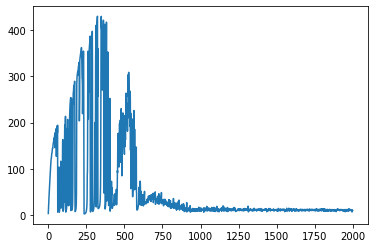

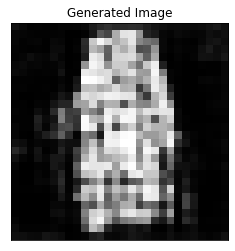

Iteration [2001/10000]......0.121(s) gen: -237.04617 - critic_fake: 235.83713 - critic_real: 245.15384 - neg_critic: 9.31670
Iteration [2002/10000]......0.118(s) gen: -233.42453 - critic_fake: 235.42547 - critic_real: 246.24578 - neg_critic: 10.82031
Iteration [2003/10000]......0.118(s) gen: -238.16994 - critic_fake: 235.97537 - critic_real: 246.58285 - neg_critic: 10.60747
Iteration [2004/10000]......0.117(s) gen: -234.34578 - critic_fake: 236.76623 - critic_real: 246.66286 - neg_critic: 9.89663
Iteration [2005/10000]......0.120(s) gen: -236.41000 - critic_fake: 235.62856 - critic_real: 246.24983 - neg_critic: 10.62128
Iteration [2006/10000]......0.120(s) gen: -238.66141 - critic_fake: 235.62668 - critic_real: 246.23810 - neg_critic: 10.61143
Iteration [2007/10000]......0.118(s) gen: -238.79074 - critic_fake: 239.00531 - critic_real: 247.02666 - neg_critic: 8.02136
Iteration [2008/10000]......0.118(s) gen: -235.58603 - critic_fake: 237.25211 - critic_real: 246.92923 - neg_critic: 9.67

Iteration [2067/10000]......0.124(s) gen: -233.89374 - critic_fake: 234.66609 - critic_real: 244.95058 - neg_critic: 10.28449
Iteration [2068/10000]......0.123(s) gen: -231.26370 - critic_fake: 234.82952 - critic_real: 245.30719 - neg_critic: 10.47768
Iteration [2069/10000]......0.122(s) gen: -234.95895 - critic_fake: 235.26757 - critic_real: 245.24197 - neg_critic: 9.97440
Iteration [2070/10000]......0.122(s) gen: -236.12631 - critic_fake: 233.93332 - critic_real: 245.57516 - neg_critic: 11.64184
Iteration [2071/10000]......0.123(s) gen: -235.55006 - critic_fake: 235.02586 - critic_real: 245.88585 - neg_critic: 10.85999
Iteration [2072/10000]......0.121(s) gen: -238.42215 - critic_fake: 237.69867 - critic_real: 246.01057 - neg_critic: 8.31190
Iteration [2073/10000]......0.118(s) gen: -236.90131 - critic_fake: 237.58324 - critic_real: 244.55408 - neg_critic: 6.97084
Iteration [2074/10000]......0.120(s) gen: -235.87601 - critic_fake: 236.87246 - critic_real: 245.05622 - neg_critic: 8.18

Iteration [2133/10000]......0.121(s) gen: -237.12552 - critic_fake: 235.73088 - critic_real: 245.91914 - neg_critic: 10.18826
Iteration [2134/10000]......0.120(s) gen: -234.66110 - critic_fake: 237.31877 - critic_real: 245.58410 - neg_critic: 8.26534
Iteration [2135/10000]......0.119(s) gen: -238.77974 - critic_fake: 234.47766 - critic_real: 244.97770 - neg_critic: 10.50004
Iteration [2136/10000]......0.118(s) gen: -235.06300 - critic_fake: 237.80962 - critic_real: 245.69000 - neg_critic: 7.88039
Iteration [2137/10000]......0.117(s) gen: -232.65359 - critic_fake: 235.31707 - critic_real: 245.16635 - neg_critic: 9.84928
Iteration [2138/10000]......0.117(s) gen: -233.65504 - critic_fake: 235.94019 - critic_real: 245.69993 - neg_critic: 9.75974
Iteration [2139/10000]......0.118(s) gen: -234.79904 - critic_fake: 234.35790 - critic_real: 246.00280 - neg_critic: 11.64490
Iteration [2140/10000]......0.120(s) gen: -234.45850 - critic_fake: 237.30959 - critic_real: 246.51737 - neg_critic: 9.207

Iteration [2199/10000]......0.119(s) gen: -236.06763 - critic_fake: 234.75158 - critic_real: 243.65466 - neg_critic: 8.90309
Iteration [2200/10000]......0.120(s) gen: -233.11008 - critic_fake: 236.96117 - critic_real: 244.94059 - neg_critic: 7.97942
Iteration [2201/10000]......0.118(s) gen: -233.15936 - critic_fake: 234.82698 - critic_real: 245.74459 - neg_critic: 10.91761
Iteration [2202/10000]......0.119(s) gen: -237.43034 - critic_fake: 237.13023 - critic_real: 245.54814 - neg_critic: 8.41791
Iteration [2203/10000]......0.117(s) gen: -236.45013 - critic_fake: 237.27592 - critic_real: 245.10461 - neg_critic: 7.82869
Iteration [2204/10000]......0.118(s) gen: -235.98624 - critic_fake: 234.97357 - critic_real: 244.25645 - neg_critic: 9.28288
Iteration [2205/10000]......0.117(s) gen: -234.38214 - critic_fake: 235.12285 - critic_real: 245.00652 - neg_critic: 9.88366
Iteration [2206/10000]......0.117(s) gen: -234.31018 - critic_fake: 235.06755 - critic_real: 244.77759 - neg_critic: 9.71004

Iteration [2265/10000]......0.117(s) gen: -235.55832 - critic_fake: 235.71660 - critic_real: 244.59531 - neg_critic: 8.87871
Iteration [2266/10000]......0.119(s) gen: -235.54895 - critic_fake: 234.56683 - critic_real: 244.70599 - neg_critic: 10.13916
Iteration [2267/10000]......0.121(s) gen: -235.49731 - critic_fake: 234.15605 - critic_real: 244.92194 - neg_critic: 10.76589
Iteration [2268/10000]......0.123(s) gen: -234.48793 - critic_fake: 236.02072 - critic_real: 243.39102 - neg_critic: 7.37030
Iteration [2269/10000]......0.124(s) gen: -235.16846 - critic_fake: 234.39337 - critic_real: 243.80151 - neg_critic: 9.40814
Iteration [2270/10000]......0.124(s) gen: -235.09055 - critic_fake: 235.33660 - critic_real: 244.56575 - neg_critic: 9.22915
Iteration [2271/10000]......0.124(s) gen: -232.11624 - critic_fake: 234.75934 - critic_real: 244.80072 - neg_critic: 10.04138
Iteration [2272/10000]......0.124(s) gen: -236.62207 - critic_fake: 235.75183 - critic_real: 244.73523 - neg_critic: 8.983

Iteration [2331/10000]......0.120(s) gen: -237.24265 - critic_fake: 232.75038 - critic_real: 243.83067 - neg_critic: 11.08029
Iteration [2332/10000]......0.118(s) gen: -235.54099 - critic_fake: 236.70089 - critic_real: 244.19771 - neg_critic: 7.49682
Iteration [2333/10000]......0.118(s) gen: -233.84627 - critic_fake: 233.48025 - critic_real: 243.68691 - neg_critic: 10.20666
Iteration [2334/10000]......0.119(s) gen: -233.94443 - critic_fake: 233.44883 - critic_real: 244.86050 - neg_critic: 11.41168
Iteration [2335/10000]......0.118(s) gen: -233.72699 - critic_fake: 234.70204 - critic_real: 243.77979 - neg_critic: 9.07775
Iteration [2336/10000]......0.118(s) gen: -234.55267 - critic_fake: 235.14105 - critic_real: 245.02571 - neg_critic: 9.88467
Iteration [2337/10000]......0.119(s) gen: -234.96613 - critic_fake: 235.37997 - critic_real: 245.65487 - neg_critic: 10.27491
Iteration [2338/10000]......0.120(s) gen: -237.09473 - critic_fake: 235.43154 - critic_real: 244.64536 - neg_critic: 9.21

Iteration [2397/10000]......0.121(s) gen: -236.68889 - critic_fake: 237.32451 - critic_real: 245.20829 - neg_critic: 7.88378
Iteration [2398/10000]......0.120(s) gen: -234.57387 - critic_fake: 235.28178 - critic_real: 245.36179 - neg_critic: 10.08001
Iteration [2399/10000]......0.120(s) gen: -235.63736 - critic_fake: 237.12289 - critic_real: 245.11210 - neg_critic: 7.98922
Iteration [2400/10000]......0.118(s) gen: -234.01364 - critic_fake: 235.06251 - critic_real: 244.42224 - neg_critic: 9.35973
Iteration [2401/10000]......0.120(s) gen: -234.75470 - critic_fake: 234.41313 - critic_real: 244.19918 - neg_critic: 9.78605
Iteration [2402/10000]......0.120(s) gen: -235.64574 - critic_fake: 234.50497 - critic_real: 243.48547 - neg_critic: 8.98051
Iteration [2403/10000]......0.119(s) gen: -234.62411 - critic_fake: 236.08199 - critic_real: 244.66513 - neg_critic: 8.58315
Iteration [2404/10000]......0.119(s) gen: -233.59795 - critic_fake: 234.93790 - critic_real: 244.06484 - neg_critic: 9.12694

Iteration [2463/10000]......0.121(s) gen: -235.16043 - critic_fake: 235.38114 - critic_real: 243.06772 - neg_critic: 7.68658
Iteration [2464/10000]......0.121(s) gen: -234.24411 - critic_fake: 235.48871 - critic_real: 244.06531 - neg_critic: 8.57660
Iteration [2465/10000]......0.122(s) gen: -234.22279 - critic_fake: 233.45703 - critic_real: 244.79978 - neg_critic: 11.34275
Iteration [2466/10000]......0.121(s) gen: -235.21017 - critic_fake: 235.89737 - critic_real: 244.95231 - neg_critic: 9.05495
Iteration [2467/10000]......0.121(s) gen: -234.71971 - critic_fake: 234.39312 - critic_real: 244.87777 - neg_critic: 10.48465
Iteration [2468/10000]......0.120(s) gen: -231.95596 - critic_fake: 235.09643 - critic_real: 245.83942 - neg_critic: 10.74299
Iteration [2469/10000]......0.120(s) gen: -235.61256 - critic_fake: 234.96396 - critic_real: 244.69894 - neg_critic: 9.73498
Iteration [2470/10000]......0.119(s) gen: -234.80533 - critic_fake: 234.06131 - critic_real: 243.37454 - neg_critic: 9.313

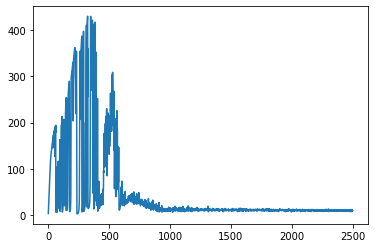

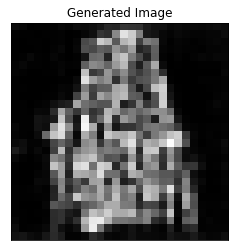

Iteration [2501/10000]......0.116(s) gen: -234.24467 - critic_fake: 236.04578 - critic_real: 244.95720 - neg_critic: 8.91141
Iteration [2502/10000]......0.115(s) gen: -238.27682 - critic_fake: 236.09608 - critic_real: 244.75687 - neg_critic: 8.66079
Iteration [2503/10000]......0.115(s) gen: -236.15796 - critic_fake: 237.24144 - critic_real: 244.75190 - neg_critic: 7.51046
Iteration [2504/10000]......0.116(s) gen: -233.48006 - critic_fake: 236.07956 - critic_real: 244.81102 - neg_critic: 8.73147
Iteration [2505/10000]......0.117(s) gen: -232.37901 - critic_fake: 234.97130 - critic_real: 244.60165 - neg_critic: 9.63035
Iteration [2506/10000]......0.118(s) gen: -233.83333 - critic_fake: 233.73476 - critic_real: 244.22981 - neg_critic: 10.49505
Iteration [2507/10000]......0.119(s) gen: -235.07240 - critic_fake: 234.84195 - critic_real: 243.99776 - neg_critic: 9.15581
Iteration [2508/10000]......0.119(s) gen: -236.14505 - critic_fake: 234.68446 - critic_real: 243.22404 - neg_critic: 8.53958

Iteration [2567/10000]......0.119(s) gen: -235.34746 - critic_fake: 236.03649 - critic_real: 245.94617 - neg_critic: 9.90968
Iteration [2568/10000]......0.118(s) gen: -235.11584 - critic_fake: 235.94420 - critic_real: 245.74296 - neg_critic: 9.79876
Iteration [2569/10000]......0.118(s) gen: -236.55394 - critic_fake: 236.74355 - critic_real: 245.34283 - neg_critic: 8.59928
Iteration [2570/10000]......0.119(s) gen: -233.80266 - critic_fake: 236.90060 - critic_real: 245.69589 - neg_critic: 8.79529
Iteration [2571/10000]......0.119(s) gen: -232.92926 - critic_fake: 234.90701 - critic_real: 244.63648 - neg_critic: 9.72947
Iteration [2572/10000]......0.118(s) gen: -235.05670 - critic_fake: 235.16015 - critic_real: 244.52320 - neg_critic: 9.36305
Iteration [2573/10000]......0.118(s) gen: -236.31171 - critic_fake: 234.59072 - critic_real: 244.78850 - neg_critic: 10.19779
Iteration [2574/10000]......0.120(s) gen: -237.32587 - critic_fake: 236.42219 - critic_real: 245.31116 - neg_critic: 8.88897

Iteration [2633/10000]......0.125(s) gen: -235.38881 - critic_fake: 236.47271 - critic_real: 244.97620 - neg_critic: 8.50349
Iteration [2634/10000]......0.124(s) gen: -233.59712 - critic_fake: 235.44659 - critic_real: 245.76113 - neg_critic: 10.31454
Iteration [2635/10000]......0.122(s) gen: -237.44971 - critic_fake: 237.50210 - critic_real: 244.16111 - neg_critic: 6.65901
Iteration [2636/10000]......0.122(s) gen: -232.13434 - critic_fake: 235.11191 - critic_real: 243.86142 - neg_critic: 8.74951
Iteration [2637/10000]......0.121(s) gen: -236.31082 - critic_fake: 236.07899 - critic_real: 243.82644 - neg_critic: 7.74745
Iteration [2638/10000]......0.122(s) gen: -234.68649 - critic_fake: 235.39273 - critic_real: 243.69520 - neg_critic: 8.30247
Iteration [2639/10000]......0.124(s) gen: -238.22623 - critic_fake: 235.94850 - critic_real: 244.93322 - neg_critic: 8.98473
Iteration [2640/10000]......0.119(s) gen: -235.06821 - critic_fake: 236.81532 - critic_real: 245.97887 - neg_critic: 9.16355

Iteration [2699/10000]......0.123(s) gen: -236.25060 - critic_fake: 235.29579 - critic_real: 244.88679 - neg_critic: 9.59100
Iteration [2700/10000]......0.122(s) gen: -235.98932 - critic_fake: 235.88137 - critic_real: 245.26103 - neg_critic: 9.37966
Iteration [2701/10000]......0.122(s) gen: -232.09277 - critic_fake: 236.30594 - critic_real: 245.20256 - neg_critic: 8.89662
Iteration [2702/10000]......0.121(s) gen: -236.19077 - critic_fake: 235.88944 - critic_real: 244.45274 - neg_critic: 8.56330
Iteration [2703/10000]......0.118(s) gen: -233.80777 - critic_fake: 236.61579 - critic_real: 244.21844 - neg_critic: 7.60265
Iteration [2704/10000]......0.121(s) gen: -236.10965 - critic_fake: 235.33668 - critic_real: 244.68856 - neg_critic: 9.35187
Iteration [2705/10000]......0.119(s) gen: -237.17493 - critic_fake: 236.28102 - critic_real: 245.08864 - neg_critic: 8.80763
Iteration [2706/10000]......0.117(s) gen: -234.21812 - critic_fake: 235.53229 - critic_real: 244.58002 - neg_critic: 9.04773


Iteration [2765/10000]......0.117(s) gen: -238.05412 - critic_fake: 237.99012 - critic_real: 246.28627 - neg_critic: 8.29615
Iteration [2766/10000]......0.120(s) gen: -234.11234 - critic_fake: 237.58830 - critic_real: 245.66256 - neg_critic: 8.07426
Iteration [2767/10000]......0.120(s) gen: -235.28398 - critic_fake: 236.90837 - critic_real: 246.02408 - neg_critic: 9.11571
Iteration [2768/10000]......0.120(s) gen: -238.27919 - critic_fake: 237.86367 - critic_real: 246.45744 - neg_critic: 8.59378
Iteration [2769/10000]......0.120(s) gen: -237.01175 - critic_fake: 236.32076 - critic_real: 246.00497 - neg_critic: 9.68421
Iteration [2770/10000]......0.121(s) gen: -238.56290 - critic_fake: 236.33766 - critic_real: 246.41487 - neg_critic: 10.07720
Iteration [2771/10000]......0.122(s) gen: -237.41121 - critic_fake: 236.58157 - critic_real: 246.63322 - neg_critic: 10.05165
Iteration [2772/10000]......0.122(s) gen: -235.64424 - critic_fake: 238.24777 - critic_real: 246.40886 - neg_critic: 8.1610

Iteration [2831/10000]......0.118(s) gen: -237.29224 - critic_fake: 236.21688 - critic_real: 245.33015 - neg_critic: 9.11327
Iteration [2832/10000]......0.116(s) gen: -238.60788 - critic_fake: 237.32198 - critic_real: 245.62134 - neg_critic: 8.29936
Iteration [2833/10000]......0.116(s) gen: -236.93018 - critic_fake: 238.03132 - critic_real: 245.71948 - neg_critic: 7.68816
Iteration [2834/10000]......0.117(s) gen: -237.00774 - critic_fake: 234.72060 - critic_real: 245.87053 - neg_critic: 11.14993
Iteration [2835/10000]......0.119(s) gen: -235.79822 - critic_fake: 236.73917 - critic_real: 244.53525 - neg_critic: 7.79608
Iteration [2836/10000]......0.117(s) gen: -236.01778 - critic_fake: 235.63993 - critic_real: 244.21746 - neg_critic: 8.57753
Iteration [2837/10000]......0.118(s) gen: -235.69565 - critic_fake: 235.55357 - critic_real: 245.91175 - neg_critic: 10.35818
Iteration [2838/10000]......0.119(s) gen: -237.10785 - critic_fake: 238.36561 - critic_real: 246.09193 - neg_critic: 7.7263

Iteration [2897/10000]......0.122(s) gen: -239.88803 - critic_fake: 237.63965 - critic_real: 246.86246 - neg_critic: 9.22280
Iteration [2898/10000]......0.124(s) gen: -238.35690 - critic_fake: 239.38554 - critic_real: 246.03138 - neg_critic: 6.64584
Iteration [2899/10000]......0.123(s) gen: -236.70163 - critic_fake: 238.18988 - critic_real: 246.12429 - neg_critic: 7.93441
Iteration [2900/10000]......0.129(s) gen: -236.85266 - critic_fake: 236.79772 - critic_real: 246.42273 - neg_critic: 9.62501
Iteration [2901/10000]......0.127(s) gen: -236.57358 - critic_fake: 236.18175 - critic_real: 245.90510 - neg_critic: 9.72335
Iteration [2902/10000]......0.130(s) gen: -238.31860 - critic_fake: 235.85445 - critic_real: 245.68083 - neg_critic: 9.82638
Iteration [2903/10000]......0.128(s) gen: -237.26245 - critic_fake: 237.72353 - critic_real: 246.17412 - neg_critic: 8.45059
Iteration [2904/10000]......0.118(s) gen: -238.38983 - critic_fake: 236.93011 - critic_real: 245.58727 - neg_critic: 8.65716


Iteration [2963/10000]......0.123(s) gen: -235.47374 - critic_fake: 236.75679 - critic_real: 245.85322 - neg_critic: 9.09643
Iteration [2964/10000]......0.121(s) gen: -238.62724 - critic_fake: 237.56593 - critic_real: 245.68865 - neg_critic: 8.12273
Iteration [2965/10000]......0.119(s) gen: -237.20245 - critic_fake: 238.21116 - critic_real: 246.17669 - neg_critic: 7.96553
Iteration [2966/10000]......0.121(s) gen: -239.25519 - critic_fake: 236.20208 - critic_real: 245.85285 - neg_critic: 9.65078
Iteration [2967/10000]......0.119(s) gen: -237.93611 - critic_fake: 239.37138 - critic_real: 246.84241 - neg_critic: 7.47103
Iteration [2968/10000]......0.140(s) gen: -236.97012 - critic_fake: 237.15943 - critic_real: 246.18380 - neg_critic: 9.02437
Iteration [2969/10000]......0.125(s) gen: -236.07001 - critic_fake: 235.90156 - critic_real: 246.33047 - neg_critic: 10.42891
Iteration [2970/10000]......0.116(s) gen: -241.07071 - critic_fake: 238.10239 - critic_real: 247.10161 - neg_critic: 8.99922

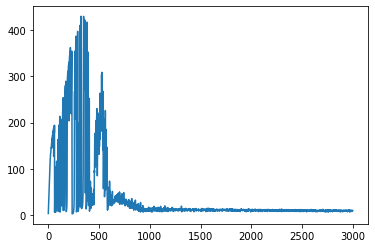

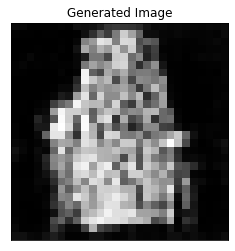

Iteration [3001/10000]......0.119(s) gen: -238.34801 - critic_fake: 236.87507 - critic_real: 247.52858 - neg_critic: 10.65351
Iteration [3002/10000]......0.116(s) gen: -240.24872 - critic_fake: 237.57155 - critic_real: 247.73884 - neg_critic: 10.16729
Iteration [3003/10000]......0.115(s) gen: -238.89044 - critic_fake: 240.02580 - critic_real: 246.86055 - neg_critic: 6.83476
Iteration [3004/10000]......0.126(s) gen: -236.20175 - critic_fake: 238.13282 - critic_real: 246.92300 - neg_critic: 8.79017
Iteration [3005/10000]......0.115(s) gen: -236.52150 - critic_fake: 238.05158 - critic_real: 246.85722 - neg_critic: 8.80564
Iteration [3006/10000]......0.115(s) gen: -236.95761 - critic_fake: 237.52827 - critic_real: 247.64481 - neg_critic: 10.11653
Iteration [3007/10000]......0.114(s) gen: -238.42447 - critic_fake: 239.45853 - critic_real: 246.95699 - neg_critic: 7.49846
Iteration [3008/10000]......0.116(s) gen: -239.15599 - critic_fake: 238.88091 - critic_real: 246.98553 - neg_critic: 8.104

Iteration [3068/10000]......0.122(s) gen: -236.80110 - critic_fake: 238.48763 - critic_real: 246.51791 - neg_critic: 8.03028
Iteration [3069/10000]......0.122(s) gen: -237.34308 - critic_fake: 236.90900 - critic_real: 245.38796 - neg_critic: 8.47896
Iteration [3070/10000]......0.122(s) gen: -237.80722 - critic_fake: 236.82306 - critic_real: 245.16649 - neg_critic: 8.34343
Iteration [3071/10000]......0.123(s) gen: -236.65247 - critic_fake: 238.07431 - critic_real: 245.93771 - neg_critic: 7.86340
Iteration [3072/10000]......0.121(s) gen: -237.30534 - critic_fake: 236.62239 - critic_real: 245.32557 - neg_critic: 8.70318
Iteration [3073/10000]......0.168(s) gen: -236.42429 - critic_fake: 235.97194 - critic_real: 246.30681 - neg_critic: 10.33488
Iteration [3074/10000]......0.118(s) gen: -237.83121 - critic_fake: 238.20998 - critic_real: 247.48082 - neg_critic: 9.27084
Iteration [3075/10000]......0.118(s) gen: -239.97028 - critic_fake: 237.33651 - critic_real: 248.21982 - neg_critic: 10.8833

Iteration [3134/10000]......0.120(s) gen: -237.13484 - critic_fake: 238.51666 - critic_real: 246.96722 - neg_critic: 8.45056
Iteration [3135/10000]......0.120(s) gen: -238.96770 - critic_fake: 238.01129 - critic_real: 246.77011 - neg_critic: 8.75882
Iteration [3136/10000]......0.119(s) gen: -236.67796 - critic_fake: 237.14870 - critic_real: 247.27375 - neg_critic: 10.12505
Iteration [3137/10000]......0.120(s) gen: -238.90816 - critic_fake: 238.28199 - critic_real: 246.97477 - neg_critic: 8.69279
Iteration [3138/10000]......0.119(s) gen: -237.80798 - critic_fake: 239.07296 - critic_real: 247.62412 - neg_critic: 8.55117
Iteration [3139/10000]......0.120(s) gen: -237.32735 - critic_fake: 238.97125 - critic_real: 247.44294 - neg_critic: 8.47170
Iteration [3140/10000]......0.120(s) gen: -237.94907 - critic_fake: 238.99198 - critic_real: 247.50930 - neg_critic: 8.51732
Iteration [3141/10000]......0.119(s) gen: -237.13440 - critic_fake: 236.95323 - critic_real: 247.23021 - neg_critic: 10.2769

Iteration [3200/10000]......0.119(s) gen: -237.33641 - critic_fake: 239.39411 - critic_real: 247.62398 - neg_critic: 8.22987
Iteration [3201/10000]......0.120(s) gen: -237.59962 - critic_fake: 239.03931 - critic_real: 247.89482 - neg_critic: 8.85551
Iteration [3202/10000]......0.119(s) gen: -238.34181 - critic_fake: 238.98625 - critic_real: 246.76674 - neg_critic: 7.78048
Iteration [3203/10000]......0.120(s) gen: -238.19150 - critic_fake: 238.55731 - critic_real: 246.94809 - neg_critic: 8.39078
Iteration [3204/10000]......0.122(s) gen: -237.72737 - critic_fake: 237.32042 - critic_real: 246.16162 - neg_critic: 8.84120
Iteration [3205/10000]......0.121(s) gen: -240.30533 - critic_fake: 239.27017 - critic_real: 247.39298 - neg_critic: 8.12281
Iteration [3206/10000]......0.122(s) gen: -236.93590 - critic_fake: 239.30869 - critic_real: 246.68115 - neg_critic: 7.37246
Iteration [3207/10000]......0.122(s) gen: -236.46730 - critic_fake: 237.47949 - critic_real: 245.95262 - neg_critic: 8.47313


Iteration [3266/10000]......0.120(s) gen: -238.49973 - critic_fake: 239.39245 - critic_real: 247.57979 - neg_critic: 8.18734
Iteration [3267/10000]......0.121(s) gen: -237.41840 - critic_fake: 239.60490 - critic_real: 247.34122 - neg_critic: 7.73633
Iteration [3268/10000]......0.121(s) gen: -241.28552 - critic_fake: 239.37245 - critic_real: 247.66285 - neg_critic: 8.29040
Iteration [3269/10000]......0.120(s) gen: -238.32643 - critic_fake: 240.13319 - critic_real: 247.01851 - neg_critic: 6.88532
Iteration [3270/10000]......0.121(s) gen: -239.83406 - critic_fake: 239.40495 - critic_real: 247.61471 - neg_critic: 8.20976
Iteration [3271/10000]......0.121(s) gen: -239.01624 - critic_fake: 238.97910 - critic_real: 247.89612 - neg_critic: 8.91702
Iteration [3272/10000]......0.120(s) gen: -238.66905 - critic_fake: 239.16482 - critic_real: 248.86614 - neg_critic: 9.70132
Iteration [3273/10000]......0.123(s) gen: -238.98729 - critic_fake: 240.55083 - critic_real: 248.49599 - neg_critic: 7.94516


Iteration [3332/10000]......0.123(s) gen: -240.80197 - critic_fake: 240.65291 - critic_real: 247.60326 - neg_critic: 6.95036
Iteration [3333/10000]......0.123(s) gen: -239.08203 - critic_fake: 239.71822 - critic_real: 248.58539 - neg_critic: 8.86717
Iteration [3334/10000]......0.123(s) gen: -239.89769 - critic_fake: 239.39413 - critic_real: 248.58672 - neg_critic: 9.19260
Iteration [3335/10000]......0.122(s) gen: -240.06985 - critic_fake: 239.93503 - critic_real: 247.47919 - neg_critic: 7.54416
Iteration [3336/10000]......0.122(s) gen: -236.61235 - critic_fake: 238.00722 - critic_real: 247.62429 - neg_critic: 9.61707
Iteration [3337/10000]......0.124(s) gen: -238.21381 - critic_fake: 240.00741 - critic_real: 248.33992 - neg_critic: 8.33251
Iteration [3338/10000]......0.123(s) gen: -239.77742 - critic_fake: 240.28648 - critic_real: 248.17903 - neg_critic: 7.89255
Iteration [3339/10000]......0.124(s) gen: -239.42059 - critic_fake: 237.83931 - critic_real: 248.90687 - neg_critic: 11.06755

Iteration [3398/10000]......0.167(s) gen: -239.52403 - critic_fake: 240.25040 - critic_real: 246.68278 - neg_critic: 6.43238
Iteration [3399/10000]......0.128(s) gen: -240.40262 - critic_fake: 239.01306 - critic_real: 245.88308 - neg_critic: 6.87003
Iteration [3400/10000]......0.118(s) gen: -238.59912 - critic_fake: 238.97685 - critic_real: 247.08620 - neg_critic: 8.10936
Iteration [3401/10000]......0.119(s) gen: -237.48470 - critic_fake: 238.64881 - critic_real: 247.46913 - neg_critic: 8.82032
Iteration [3402/10000]......0.121(s) gen: -239.19189 - critic_fake: 239.00903 - critic_real: 247.65708 - neg_critic: 8.64805
Iteration [3403/10000]......0.120(s) gen: -241.82335 - critic_fake: 239.97250 - critic_real: 248.37823 - neg_critic: 8.40573
Iteration [3404/10000]......0.118(s) gen: -239.92096 - critic_fake: 240.37034 - critic_real: 248.91995 - neg_critic: 8.54961
Iteration [3405/10000]......0.121(s) gen: -240.86826 - critic_fake: 241.56689 - critic_real: 249.75444 - neg_critic: 8.18755


Iteration [3464/10000]......0.115(s) gen: -240.70248 - critic_fake: 241.02469 - critic_real: 248.98784 - neg_critic: 7.96314
Iteration [3465/10000]......0.116(s) gen: -240.02843 - critic_fake: 240.33117 - critic_real: 249.34930 - neg_critic: 9.01812
Iteration [3466/10000]......0.115(s) gen: -240.61938 - critic_fake: 240.98068 - critic_real: 249.23838 - neg_critic: 8.25770
Iteration [3467/10000]......0.116(s) gen: -239.28683 - critic_fake: 241.19913 - critic_real: 249.42429 - neg_critic: 8.22516
Iteration [3468/10000]......0.117(s) gen: -240.55835 - critic_fake: 241.85336 - critic_real: 250.12121 - neg_critic: 8.26786
Iteration [3469/10000]......0.116(s) gen: -242.50061 - critic_fake: 240.61777 - critic_real: 250.28609 - neg_critic: 9.66831
Iteration [3470/10000]......0.116(s) gen: -240.55157 - critic_fake: 241.14936 - critic_real: 248.98606 - neg_critic: 7.83670
Iteration [3471/10000]......0.117(s) gen: -238.11545 - critic_fake: 240.78917 - critic_real: 249.04738 - neg_critic: 8.25821


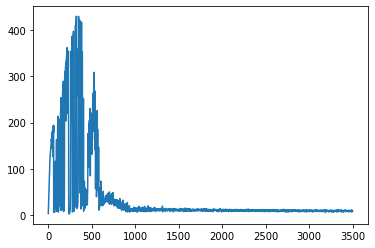

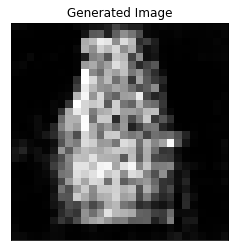

Iteration [3501/10000]......0.116(s) gen: -238.67441 - critic_fake: 240.49959 - critic_real: 249.67433 - neg_critic: 9.17473
Iteration [3502/10000]......0.119(s) gen: -241.13005 - critic_fake: 239.79781 - critic_real: 249.74268 - neg_critic: 9.94487
Iteration [3503/10000]......0.194(s) gen: -241.41515 - critic_fake: 240.30314 - critic_real: 249.40734 - neg_critic: 9.10420
Iteration [3504/10000]......0.138(s) gen: -240.35254 - critic_fake: 241.10129 - critic_real: 250.60126 - neg_critic: 9.49998
Iteration [3505/10000]......0.141(s) gen: -241.92514 - critic_fake: 240.53736 - critic_real: 249.31799 - neg_critic: 8.78064
Iteration [3506/10000]......0.138(s) gen: -241.46313 - critic_fake: 241.18170 - critic_real: 249.68680 - neg_critic: 8.50510
Iteration [3507/10000]......0.139(s) gen: -240.33006 - critic_fake: 241.25616 - critic_real: 249.73170 - neg_critic: 8.47554
Iteration [3508/10000]......0.140(s) gen: -241.88345 - critic_fake: 241.42691 - critic_real: 250.18072 - neg_critic: 8.75381


Iteration [3567/10000]......0.124(s) gen: -240.32787 - critic_fake: 241.05779 - critic_real: 250.11483 - neg_critic: 9.05704
Iteration [3568/10000]......0.124(s) gen: -241.68799 - critic_fake: 241.74514 - critic_real: 250.42832 - neg_critic: 8.68318
Iteration [3569/10000]......0.125(s) gen: -241.47191 - critic_fake: 242.24954 - critic_real: 250.25638 - neg_critic: 8.00685
Iteration [3570/10000]......0.125(s) gen: -240.74118 - critic_fake: 242.45633 - critic_real: 250.18671 - neg_critic: 7.73039
Iteration [3571/10000]......0.125(s) gen: -242.30962 - critic_fake: 241.40498 - critic_real: 249.81820 - neg_critic: 8.41322
Iteration [3572/10000]......0.127(s) gen: -242.69910 - critic_fake: 242.73010 - critic_real: 250.88812 - neg_critic: 8.15802
Iteration [3573/10000]......0.126(s) gen: -241.83179 - critic_fake: 242.12648 - critic_real: 250.00003 - neg_critic: 7.87355
Iteration [3574/10000]......0.120(s) gen: -240.88101 - critic_fake: 240.89395 - critic_real: 249.74268 - neg_critic: 8.84873


Iteration [3633/10000]......0.117(s) gen: -242.85168 - critic_fake: 242.03068 - critic_real: 251.16663 - neg_critic: 9.13594
Iteration [3634/10000]......0.120(s) gen: -242.78207 - critic_fake: 242.24606 - critic_real: 250.25070 - neg_critic: 8.00464
Iteration [3635/10000]......0.122(s) gen: -242.75191 - critic_fake: 241.94358 - critic_real: 250.54104 - neg_critic: 8.59746
Iteration [3636/10000]......0.119(s) gen: -242.52850 - critic_fake: 242.13561 - critic_real: 251.05517 - neg_critic: 8.91956
Iteration [3637/10000]......0.119(s) gen: -241.27286 - critic_fake: 242.77521 - critic_real: 250.23962 - neg_critic: 7.46441
Iteration [3638/10000]......0.120(s) gen: -240.12497 - critic_fake: 241.13921 - critic_real: 250.10812 - neg_critic: 8.96892
Iteration [3639/10000]......0.120(s) gen: -243.68828 - critic_fake: 241.92860 - critic_real: 249.81683 - neg_critic: 7.88823
Iteration [3640/10000]......0.122(s) gen: -240.50891 - critic_fake: 243.21514 - critic_real: 249.26876 - neg_critic: 6.05362


Iteration [3699/10000]......0.118(s) gen: -241.67245 - critic_fake: 242.37998 - critic_real: 250.59940 - neg_critic: 8.21942
Iteration [3700/10000]......0.118(s) gen: -241.92343 - critic_fake: 241.96574 - critic_real: 250.28955 - neg_critic: 8.32381
Iteration [3701/10000]......0.118(s) gen: -242.49289 - critic_fake: 243.25778 - critic_real: 251.68678 - neg_critic: 8.42900
Iteration [3702/10000]......0.118(s) gen: -242.76146 - critic_fake: 243.05327 - critic_real: 250.64766 - neg_critic: 7.59439
Iteration [3703/10000]......0.118(s) gen: -241.29128 - critic_fake: 241.69675 - critic_real: 249.79519 - neg_critic: 8.09844
Iteration [3704/10000]......0.119(s) gen: -243.43861 - critic_fake: 241.57943 - critic_real: 249.56840 - neg_critic: 7.98897
Iteration [3705/10000]......0.121(s) gen: -243.89420 - critic_fake: 240.72274 - critic_real: 250.31169 - neg_critic: 9.58894
Iteration [3706/10000]......0.120(s) gen: -243.44969 - critic_fake: 244.45208 - critic_real: 250.81450 - neg_critic: 6.36242


Iteration [3765/10000]......0.119(s) gen: -244.39102 - critic_fake: 244.29380 - critic_real: 251.51275 - neg_critic: 7.21895
Iteration [3766/10000]......0.120(s) gen: -240.79344 - critic_fake: 243.28595 - critic_real: 251.69266 - neg_critic: 8.40671
Iteration [3767/10000]......0.120(s) gen: -244.43698 - critic_fake: 243.79721 - critic_real: 251.62173 - neg_critic: 7.82452
Iteration [3768/10000]......0.119(s) gen: -240.56265 - critic_fake: 242.11594 - critic_real: 252.30540 - neg_critic: 10.18946
Iteration [3769/10000]......0.123(s) gen: -242.69713 - critic_fake: 242.95815 - critic_real: 251.30293 - neg_critic: 8.34478
Iteration [3770/10000]......0.122(s) gen: -242.54349 - critic_fake: 243.74417 - critic_real: 250.90922 - neg_critic: 7.16505
Iteration [3771/10000]......0.124(s) gen: -242.63754 - critic_fake: 242.44773 - critic_real: 250.81248 - neg_critic: 8.36476
Iteration [3772/10000]......0.123(s) gen: -241.09314 - critic_fake: 242.24193 - critic_real: 251.70487 - neg_critic: 9.46294

Iteration [3831/10000]......0.120(s) gen: -242.79315 - critic_fake: 244.00036 - critic_real: 252.47601 - neg_critic: 8.47565
Iteration [3832/10000]......0.119(s) gen: -242.51147 - critic_fake: 244.33162 - critic_real: 252.35899 - neg_critic: 8.02737
Iteration [3833/10000]......0.118(s) gen: -243.32092 - critic_fake: 242.71099 - critic_real: 251.53407 - neg_critic: 8.82308
Iteration [3834/10000]......0.117(s) gen: -245.94917 - critic_fake: 242.85881 - critic_real: 251.58342 - neg_critic: 8.72461
Iteration [3835/10000]......0.118(s) gen: -243.60805 - critic_fake: 244.90407 - critic_real: 251.01030 - neg_critic: 6.10623
Iteration [3836/10000]......0.119(s) gen: -242.17558 - critic_fake: 243.03130 - critic_real: 251.01829 - neg_critic: 7.98698
Iteration [3837/10000]......0.118(s) gen: -242.02298 - critic_fake: 242.69496 - critic_real: 251.47806 - neg_critic: 8.78311
Iteration [3838/10000]......0.118(s) gen: -245.18811 - critic_fake: 242.90500 - critic_real: 251.79881 - neg_critic: 8.89380


Iteration [3897/10000]......0.116(s) gen: -244.69246 - critic_fake: 243.94119 - critic_real: 252.59576 - neg_critic: 8.65457
Iteration [3898/10000]......0.116(s) gen: -246.60751 - critic_fake: 245.14328 - critic_real: 252.19818 - neg_critic: 7.05490
Iteration [3899/10000]......0.119(s) gen: -244.31168 - critic_fake: 245.64988 - critic_real: 252.10019 - neg_critic: 6.45031
Iteration [3900/10000]......0.122(s) gen: -243.51901 - critic_fake: 244.63705 - critic_real: 251.97914 - neg_critic: 7.34210
Iteration [3901/10000]......0.119(s) gen: -244.28760 - critic_fake: 242.70793 - critic_real: 251.91545 - neg_critic: 9.20752
Iteration [3902/10000]......0.119(s) gen: -243.63757 - critic_fake: 243.08449 - critic_real: 253.20898 - neg_critic: 10.12449
Iteration [3903/10000]......0.121(s) gen: -239.59848 - critic_fake: 243.80155 - critic_real: 252.55999 - neg_critic: 8.75844
Iteration [3904/10000]......0.120(s) gen: -242.76450 - critic_fake: 242.05764 - critic_real: 251.38611 - neg_critic: 9.32848

Iteration [3963/10000]......0.113(s) gen: -244.60349 - critic_fake: 242.39089 - critic_real: 251.37820 - neg_critic: 8.98730
Iteration [3964/10000]......0.112(s) gen: -242.69290 - critic_fake: 243.28695 - critic_real: 252.56780 - neg_critic: 9.28085
Iteration [3965/10000]......0.113(s) gen: -246.49219 - critic_fake: 243.26100 - critic_real: 252.29778 - neg_critic: 9.03678
Iteration [3966/10000]......0.114(s) gen: -244.76642 - critic_fake: 245.53080 - critic_real: 252.41702 - neg_critic: 6.88622
Iteration [3967/10000]......0.115(s) gen: -241.40298 - critic_fake: 244.10591 - critic_real: 252.22766 - neg_critic: 8.12174
Iteration [3968/10000]......0.115(s) gen: -242.75061 - critic_fake: 244.05212 - critic_real: 252.68734 - neg_critic: 8.63522
Iteration [3969/10000]......0.116(s) gen: -240.32037 - critic_fake: 243.38039 - critic_real: 252.82580 - neg_critic: 9.44542
Iteration [3970/10000]......0.115(s) gen: -244.25591 - critic_fake: 243.14401 - critic_real: 251.87174 - neg_critic: 8.72773


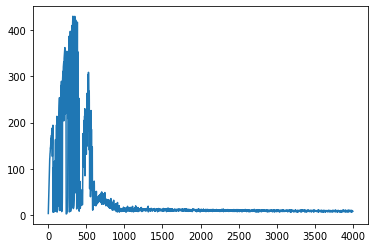

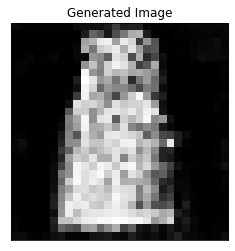

Iteration [4001/10000]......0.125(s) gen: -245.03960 - critic_fake: 245.20675 - critic_real: 252.05879 - neg_critic: 6.85204
Iteration [4002/10000]......0.120(s) gen: -245.35278 - critic_fake: 244.08847 - critic_real: 252.04879 - neg_critic: 7.96032
Iteration [4003/10000]......0.124(s) gen: -242.79807 - critic_fake: 244.43196 - critic_real: 252.11353 - neg_critic: 7.68157
Iteration [4004/10000]......0.120(s) gen: -245.99565 - critic_fake: 243.93714 - critic_real: 252.56965 - neg_critic: 8.63251
Iteration [4005/10000]......0.122(s) gen: -243.45316 - critic_fake: 243.95674 - critic_real: 252.86632 - neg_critic: 8.90958
Iteration [4006/10000]......0.120(s) gen: -244.98117 - critic_fake: 244.17303 - critic_real: 252.21997 - neg_critic: 8.04695
Iteration [4007/10000]......0.119(s) gen: -244.00690 - critic_fake: 245.15931 - critic_real: 252.94679 - neg_critic: 7.78748
Iteration [4008/10000]......0.120(s) gen: -243.17972 - critic_fake: 244.10065 - critic_real: 252.86257 - neg_critic: 8.76192


Iteration [4067/10000]......0.121(s) gen: -246.68100 - critic_fake: 245.58084 - critic_real: 253.50737 - neg_critic: 7.92653
Iteration [4068/10000]......0.123(s) gen: -242.54292 - critic_fake: 246.02188 - critic_real: 254.38948 - neg_critic: 8.36760
Iteration [4069/10000]......0.122(s) gen: -248.08667 - critic_fake: 244.80694 - critic_real: 253.48225 - neg_critic: 8.67532
Iteration [4070/10000]......0.121(s) gen: -247.84138 - critic_fake: 247.67536 - critic_real: 253.87503 - neg_critic: 6.19967
Iteration [4071/10000]......0.122(s) gen: -246.69870 - critic_fake: 246.50504 - critic_real: 253.28792 - neg_critic: 6.78289
Iteration [4072/10000]......0.190(s) gen: -245.07397 - critic_fake: 245.71854 - critic_real: 253.15799 - neg_critic: 7.43945
Iteration [4073/10000]......0.114(s) gen: -246.71677 - critic_fake: 246.86683 - critic_real: 252.88362 - neg_critic: 6.01679
Iteration [4074/10000]......0.115(s) gen: -245.71155 - critic_fake: 246.46907 - critic_real: 252.65946 - neg_critic: 6.19039


Iteration [4133/10000]......0.121(s) gen: -245.07561 - critic_fake: 244.78207 - critic_real: 253.15202 - neg_critic: 8.36995
Iteration [4134/10000]......0.120(s) gen: -246.72754 - critic_fake: 245.96564 - critic_real: 253.82697 - neg_critic: 7.86132
Iteration [4135/10000]......0.121(s) gen: -246.81082 - critic_fake: 246.09732 - critic_real: 253.81423 - neg_critic: 7.71691
Iteration [4136/10000]......0.167(s) gen: -243.45502 - critic_fake: 245.91635 - critic_real: 253.63865 - neg_critic: 7.72230
Iteration [4137/10000]......0.118(s) gen: -244.76300 - critic_fake: 245.66558 - critic_real: 253.87767 - neg_critic: 8.21208
Iteration [4138/10000]......0.118(s) gen: -242.86313 - critic_fake: 245.14965 - critic_real: 254.01183 - neg_critic: 8.86218
Iteration [4139/10000]......0.162(s) gen: -244.07440 - critic_fake: 243.68251 - critic_real: 253.80309 - neg_critic: 10.12058
Iteration [4140/10000]......0.115(s) gen: -244.89082 - critic_fake: 245.79239 - critic_real: 253.97190 - neg_critic: 8.17951

Iteration [4199/10000]......0.133(s) gen: -244.51871 - critic_fake: 245.42369 - critic_real: 254.23377 - neg_critic: 8.81008
Iteration [4200/10000]......0.134(s) gen: -245.24382 - critic_fake: 245.27176 - critic_real: 253.74179 - neg_critic: 8.47003
Iteration [4201/10000]......0.137(s) gen: -246.87769 - critic_fake: 245.47032 - critic_real: 254.26129 - neg_critic: 8.79097
Iteration [4202/10000]......0.144(s) gen: -246.07021 - critic_fake: 246.30423 - critic_real: 255.58287 - neg_critic: 9.27864
Iteration [4203/10000]......0.137(s) gen: -247.04947 - critic_fake: 246.80191 - critic_real: 254.81684 - neg_critic: 8.01493
Iteration [4204/10000]......0.135(s) gen: -246.25409 - critic_fake: 246.02578 - critic_real: 253.71166 - neg_critic: 7.68588
Iteration [4205/10000]......0.137(s) gen: -247.62991 - critic_fake: 246.00193 - critic_real: 254.69879 - neg_critic: 8.69686
Iteration [4206/10000]......0.136(s) gen: -248.21939 - critic_fake: 247.39704 - critic_real: 254.89193 - neg_critic: 7.49489


Iteration [4265/10000]......0.120(s) gen: -245.58832 - critic_fake: 245.41272 - critic_real: 253.61491 - neg_critic: 8.20219
Iteration [4266/10000]......0.120(s) gen: -242.89153 - critic_fake: 246.21789 - critic_real: 254.42497 - neg_critic: 8.20708
Iteration [4267/10000]......0.122(s) gen: -245.05858 - critic_fake: 246.43501 - critic_real: 254.77194 - neg_critic: 8.33694
Iteration [4268/10000]......0.123(s) gen: -244.76842 - critic_fake: 246.59200 - critic_real: 254.86328 - neg_critic: 8.27129
Iteration [4269/10000]......0.124(s) gen: -245.30450 - critic_fake: 246.85635 - critic_real: 255.00186 - neg_critic: 8.14551
Iteration [4270/10000]......0.123(s) gen: -247.16786 - critic_fake: 246.55787 - critic_real: 254.45934 - neg_critic: 7.90147
Iteration [4271/10000]......0.125(s) gen: -246.81609 - critic_fake: 247.03849 - critic_real: 255.21002 - neg_critic: 8.17153
Iteration [4272/10000]......0.124(s) gen: -245.41238 - critic_fake: 246.29734 - critic_real: 255.69471 - neg_critic: 9.39738


Iteration [4332/10000]......0.114(s) gen: -247.33919 - critic_fake: 247.75849 - critic_real: 256.21819 - neg_critic: 8.45970
Iteration [4333/10000]......0.115(s) gen: -249.82668 - critic_fake: 247.13596 - critic_real: 255.77017 - neg_critic: 8.63422
Iteration [4334/10000]......0.114(s) gen: -248.58502 - critic_fake: 249.08444 - critic_real: 255.33293 - neg_critic: 6.24850
Iteration [4335/10000]......0.115(s) gen: -248.49498 - critic_fake: 247.13284 - critic_real: 255.39606 - neg_critic: 8.26322
Iteration [4336/10000]......0.114(s) gen: -246.47147 - critic_fake: 247.76231 - critic_real: 255.54079 - neg_critic: 7.77848
Iteration [4337/10000]......0.116(s) gen: -246.35121 - critic_fake: 247.35677 - critic_real: 254.52072 - neg_critic: 7.16395
Iteration [4338/10000]......0.118(s) gen: -244.97742 - critic_fake: 246.58763 - critic_real: 254.06224 - neg_critic: 7.47460
Iteration [4339/10000]......0.117(s) gen: -245.56992 - critic_fake: 245.52118 - critic_real: 254.47716 - neg_critic: 8.95598


Iteration [4398/10000]......0.117(s) gen: -247.54419 - critic_fake: 246.23018 - critic_real: 255.08042 - neg_critic: 8.85024
Iteration [4399/10000]......0.119(s) gen: -249.67258 - critic_fake: 247.26924 - critic_real: 256.69764 - neg_critic: 9.42840
Iteration [4400/10000]......0.119(s) gen: -247.82883 - critic_fake: 249.54080 - critic_real: 256.01707 - neg_critic: 6.47627
Iteration [4401/10000]......0.120(s) gen: -247.19547 - critic_fake: 247.88420 - critic_real: 255.42859 - neg_critic: 7.54438
Iteration [4402/10000]......0.120(s) gen: -247.04837 - critic_fake: 249.14992 - critic_real: 256.41025 - neg_critic: 7.26033
Iteration [4403/10000]......0.118(s) gen: -247.26845 - critic_fake: 247.15642 - critic_real: 255.89335 - neg_critic: 8.73693
Iteration [4404/10000]......0.117(s) gen: -247.88115 - critic_fake: 247.87098 - critic_real: 256.00013 - neg_critic: 8.12915
Iteration [4405/10000]......0.118(s) gen: -247.33231 - critic_fake: 247.66450 - critic_real: 256.21174 - neg_critic: 8.54724


Iteration [4464/10000]......0.123(s) gen: -246.23314 - critic_fake: 247.53735 - critic_real: 256.53540 - neg_critic: 8.99805
Iteration [4465/10000]......0.119(s) gen: -249.60574 - critic_fake: 249.25833 - critic_real: 256.29136 - neg_critic: 7.03303
Iteration [4466/10000]......0.119(s) gen: -248.38074 - critic_fake: 248.93434 - critic_real: 256.10483 - neg_critic: 7.17048
Iteration [4467/10000]......0.121(s) gen: -247.38940 - critic_fake: 248.62601 - critic_real: 255.92687 - neg_critic: 7.30086
Iteration [4468/10000]......0.124(s) gen: -249.81616 - critic_fake: 248.69333 - critic_real: 256.02928 - neg_critic: 7.33595
Iteration [4469/10000]......0.119(s) gen: -246.95126 - critic_fake: 248.36402 - critic_real: 255.98701 - neg_critic: 7.62299
Iteration [4470/10000]......0.117(s) gen: -247.65254 - critic_fake: 247.32271 - critic_real: 255.69349 - neg_critic: 8.37079
Iteration [4471/10000]......0.118(s) gen: -249.71277 - critic_fake: 248.56209 - critic_real: 256.94595 - neg_critic: 8.38386


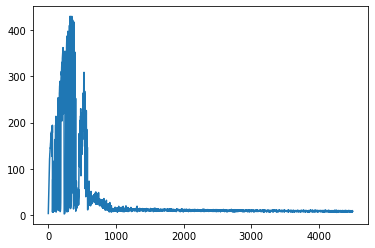

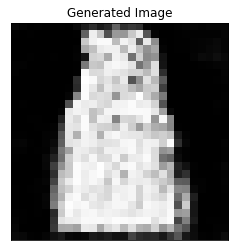

Iteration [4501/10000]......0.125(s) gen: -248.75098 - critic_fake: 249.76701 - critic_real: 255.69539 - neg_critic: 5.92838
Iteration [4502/10000]......0.121(s) gen: -248.36041 - critic_fake: 248.50298 - critic_real: 256.80967 - neg_critic: 8.30670
Iteration [4503/10000]......0.118(s) gen: -250.37227 - critic_fake: 249.31714 - critic_real: 256.89694 - neg_critic: 7.57980
Iteration [4504/10000]......0.118(s) gen: -245.98459 - critic_fake: 248.94341 - critic_real: 256.44612 - neg_critic: 7.50271
Iteration [4505/10000]......0.118(s) gen: -249.76494 - critic_fake: 248.84566 - critic_real: 256.77516 - neg_critic: 7.92950
Iteration [4506/10000]......0.120(s) gen: -245.85980 - critic_fake: 248.09928 - critic_real: 255.79098 - neg_critic: 7.69170
Iteration [4507/10000]......0.120(s) gen: -250.55522 - critic_fake: 249.93202 - critic_real: 256.90552 - neg_critic: 6.97350
Iteration [4508/10000]......0.130(s) gen: -247.07410 - critic_fake: 248.49814 - critic_real: 256.18103 - neg_critic: 7.68289


Iteration [4567/10000]......0.121(s) gen: -246.89740 - critic_fake: 249.56230 - critic_real: 257.48215 - neg_critic: 7.91985
Iteration [4568/10000]......0.121(s) gen: -248.08180 - critic_fake: 248.15480 - critic_real: 256.92186 - neg_critic: 8.76706
Iteration [4569/10000]......0.122(s) gen: -246.46291 - critic_fake: 248.37938 - critic_real: 256.50503 - neg_critic: 8.12565
Iteration [4570/10000]......0.123(s) gen: -249.27588 - critic_fake: 247.90071 - critic_real: 256.70085 - neg_critic: 8.80014
Iteration [4571/10000]......0.122(s) gen: -249.36090 - critic_fake: 249.36427 - critic_real: 256.75435 - neg_critic: 7.39007
Iteration [4572/10000]......0.126(s) gen: -247.73817 - critic_fake: 248.57476 - critic_real: 255.92861 - neg_critic: 7.35385
Iteration [4573/10000]......0.125(s) gen: -249.21992 - critic_fake: 248.27314 - critic_real: 257.13300 - neg_critic: 8.85986
Iteration [4574/10000]......0.121(s) gen: -249.46179 - critic_fake: 248.24570 - critic_real: 256.71855 - neg_critic: 8.47285


Iteration [4633/10000]......0.120(s) gen: -247.96797 - critic_fake: 249.18039 - critic_real: 255.93465 - neg_critic: 6.75426
Iteration [4634/10000]......0.119(s) gen: -250.03629 - critic_fake: 248.77729 - critic_real: 256.46840 - neg_critic: 7.69112
Iteration [4635/10000]......0.117(s) gen: -250.90509 - critic_fake: 248.71913 - critic_real: 257.03151 - neg_critic: 8.31239
Iteration [4636/10000]......0.119(s) gen: -250.88470 - critic_fake: 250.25081 - critic_real: 256.90002 - neg_critic: 6.64921
Iteration [4637/10000]......0.119(s) gen: -247.64041 - critic_fake: 249.95406 - critic_real: 257.14031 - neg_critic: 7.18625
Iteration [4638/10000]......0.120(s) gen: -248.15131 - critic_fake: 247.97998 - critic_real: 257.65815 - neg_critic: 9.67817
Iteration [4639/10000]......0.120(s) gen: -249.58069 - critic_fake: 249.26708 - critic_real: 257.17480 - neg_critic: 7.90773
Iteration [4640/10000]......0.120(s) gen: -248.91406 - critic_fake: 249.60325 - critic_real: 257.49117 - neg_critic: 7.88792


Iteration [4699/10000]......0.119(s) gen: -249.78088 - critic_fake: 250.41225 - critic_real: 257.81740 - neg_critic: 7.40515
Iteration [4700/10000]......0.119(s) gen: -252.46002 - critic_fake: 250.08867 - critic_real: 257.89836 - neg_critic: 7.80970
Iteration [4701/10000]......0.120(s) gen: -249.57538 - critic_fake: 250.95059 - critic_real: 258.11614 - neg_critic: 7.16555
Iteration [4702/10000]......0.121(s) gen: -250.07675 - critic_fake: 250.64672 - critic_real: 258.41856 - neg_critic: 7.77184
Iteration [4703/10000]......0.119(s) gen: -250.54776 - critic_fake: 250.50909 - critic_real: 257.87758 - neg_critic: 7.36849
Iteration [4704/10000]......0.119(s) gen: -249.87109 - critic_fake: 250.33664 - critic_real: 257.58789 - neg_critic: 7.25125
Iteration [4705/10000]......0.120(s) gen: -245.80653 - critic_fake: 249.61309 - critic_real: 257.58680 - neg_critic: 7.97371
Iteration [4706/10000]......0.121(s) gen: -252.04086 - critic_fake: 251.54002 - critic_real: 258.42776 - neg_critic: 6.88773


Iteration [4765/10000]......0.120(s) gen: -248.89719 - critic_fake: 250.78033 - critic_real: 257.86663 - neg_critic: 7.08630
Iteration [4766/10000]......0.122(s) gen: -251.68028 - critic_fake: 248.86043 - critic_real: 257.77482 - neg_critic: 8.91439
Iteration [4767/10000]......0.122(s) gen: -251.86710 - critic_fake: 250.96616 - critic_real: 258.41448 - neg_critic: 7.44832
Iteration [4768/10000]......0.121(s) gen: -249.49753 - critic_fake: 250.90179 - critic_real: 258.02141 - neg_critic: 7.11962
Iteration [4769/10000]......0.121(s) gen: -248.70535 - critic_fake: 250.11943 - critic_real: 258.08435 - neg_critic: 7.96492
Iteration [4770/10000]......0.121(s) gen: -247.95184 - critic_fake: 249.45813 - critic_real: 258.73070 - neg_critic: 9.27257
Iteration [4771/10000]......0.120(s) gen: -250.54727 - critic_fake: 250.15842 - critic_real: 257.63567 - neg_critic: 7.47725
Iteration [4772/10000]......0.120(s) gen: -249.64580 - critic_fake: 250.40976 - critic_real: 258.49772 - neg_critic: 8.08796


Iteration [4831/10000]......0.120(s) gen: -251.98590 - critic_fake: 253.32244 - critic_real: 258.83388 - neg_critic: 5.51144
Iteration [4832/10000]......0.119(s) gen: -252.00421 - critic_fake: 251.24881 - critic_real: 257.89173 - neg_critic: 6.64292
Iteration [4833/10000]......0.120(s) gen: -251.38046 - critic_fake: 250.97070 - critic_real: 257.67527 - neg_critic: 6.70457
Iteration [4834/10000]......0.120(s) gen: -251.44116 - critic_fake: 251.73068 - critic_real: 258.79883 - neg_critic: 7.06815
Iteration [4835/10000]......0.121(s) gen: -250.54968 - critic_fake: 250.39909 - critic_real: 258.85068 - neg_critic: 8.45159
Iteration [4836/10000]......0.119(s) gen: -253.17755 - critic_fake: 250.36471 - critic_real: 259.71024 - neg_critic: 9.34552
Iteration [4837/10000]......0.120(s) gen: -249.67780 - critic_fake: 252.49287 - critic_real: 259.59659 - neg_critic: 7.10371
Iteration [4838/10000]......0.121(s) gen: -252.86093 - critic_fake: 252.62793 - critic_real: 258.91770 - neg_critic: 6.28977


Iteration [4897/10000]......0.119(s) gen: -253.51424 - critic_fake: 252.82129 - critic_real: 260.01803 - neg_critic: 7.19674
Iteration [4898/10000]......0.119(s) gen: -253.07785 - critic_fake: 252.94234 - critic_real: 259.86274 - neg_critic: 6.92040
Iteration [4899/10000]......0.120(s) gen: -252.41797 - critic_fake: 253.02590 - critic_real: 260.85115 - neg_critic: 7.82526
Iteration [4900/10000]......0.119(s) gen: -254.00888 - critic_fake: 253.73308 - critic_real: 260.37680 - neg_critic: 6.64372
Iteration [4901/10000]......0.118(s) gen: -254.41629 - critic_fake: 252.60066 - critic_real: 260.43776 - neg_critic: 7.83710
Iteration [4902/10000]......0.117(s) gen: -250.23145 - critic_fake: 251.95954 - critic_real: 260.23071 - neg_critic: 8.27118
Iteration [4903/10000]......0.116(s) gen: -251.53555 - critic_fake: 250.62528 - critic_real: 259.00629 - neg_critic: 8.38101
Iteration [4904/10000]......0.116(s) gen: -252.10573 - critic_fake: 251.44724 - critic_real: 259.73773 - neg_critic: 8.29048


Iteration [4963/10000]......0.118(s) gen: -252.60193 - critic_fake: 252.33225 - critic_real: 260.33580 - neg_critic: 8.00354
Iteration [4964/10000]......0.118(s) gen: -251.57140 - critic_fake: 252.51891 - critic_real: 260.03360 - neg_critic: 7.51469
Iteration [4965/10000]......0.120(s) gen: -250.92102 - critic_fake: 251.83997 - critic_real: 260.01516 - neg_critic: 8.17519
Iteration [4966/10000]......0.122(s) gen: -252.87680 - critic_fake: 251.62312 - critic_real: 259.72581 - neg_critic: 8.10269
Iteration [4967/10000]......0.120(s) gen: -253.86420 - critic_fake: 253.46505 - critic_real: 259.73318 - neg_critic: 6.26813
Iteration [4968/10000]......0.120(s) gen: -250.92056 - critic_fake: 252.89740 - critic_real: 260.29115 - neg_critic: 7.39375
Iteration [4969/10000]......0.120(s) gen: -251.68088 - critic_fake: 251.82108 - critic_real: 260.41520 - neg_critic: 8.59412
Iteration [4970/10000]......0.120(s) gen: -251.11526 - critic_fake: 253.17696 - critic_real: 260.71487 - neg_critic: 7.53792


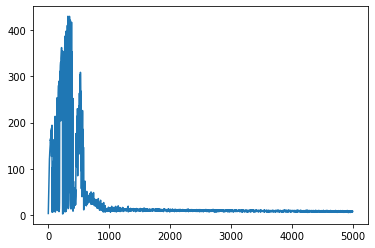

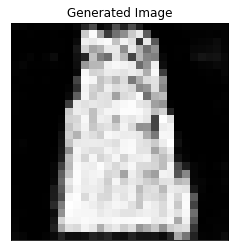

Iteration [5001/10000]......0.124(s) gen: -254.05154 - critic_fake: 252.55730 - critic_real: 260.42896 - neg_critic: 7.87166
Iteration [5002/10000]......0.115(s) gen: -250.88525 - critic_fake: 253.19758 - critic_real: 260.27672 - neg_critic: 7.07914
Iteration [5003/10000]......0.115(s) gen: -251.01971 - critic_fake: 251.71033 - critic_real: 260.30363 - neg_critic: 8.59330
Iteration [5004/10000]......0.115(s) gen: -252.65198 - critic_fake: 252.08657 - critic_real: 259.86194 - neg_critic: 7.77537
Iteration [5005/10000]......0.119(s) gen: -253.83278 - critic_fake: 252.28648 - critic_real: 260.76515 - neg_critic: 8.47867
Iteration [5006/10000]......0.117(s) gen: -253.31148 - critic_fake: 254.44251 - critic_real: 260.95595 - neg_critic: 6.51344
Iteration [5007/10000]......0.116(s) gen: -253.92982 - critic_fake: 253.98954 - critic_real: 260.16428 - neg_critic: 6.17474
Iteration [5008/10000]......0.119(s) gen: -252.56313 - critic_fake: 253.80936 - critic_real: 260.40624 - neg_critic: 6.59688


Iteration [5067/10000]......0.123(s) gen: -253.98242 - critic_fake: 253.39413 - critic_real: 260.77161 - neg_critic: 7.37748
Iteration [5068/10000]......0.126(s) gen: -254.87305 - critic_fake: 254.35775 - critic_real: 261.34009 - neg_critic: 6.98234
Iteration [5069/10000]......0.123(s) gen: -254.62859 - critic_fake: 253.48009 - critic_real: 261.03530 - neg_critic: 7.55521
Iteration [5070/10000]......0.124(s) gen: -252.51257 - critic_fake: 254.83116 - critic_real: 260.93228 - neg_critic: 6.10111
Iteration [5071/10000]......0.122(s) gen: -250.98639 - critic_fake: 251.32205 - critic_real: 260.19210 - neg_critic: 8.87005
Iteration [5072/10000]......0.122(s) gen: -254.68198 - critic_fake: 251.93637 - critic_real: 260.24950 - neg_critic: 8.31313
Iteration [5073/10000]......0.124(s) gen: -252.81735 - critic_fake: 253.51998 - critic_real: 260.72318 - neg_critic: 7.20320
Iteration [5074/10000]......0.134(s) gen: -254.05974 - critic_fake: 252.36826 - critic_real: 261.02705 - neg_critic: 8.65879


Iteration [5133/10000]......0.121(s) gen: -252.97192 - critic_fake: 252.97964 - critic_real: 261.09926 - neg_critic: 8.11962
Iteration [5134/10000]......0.122(s) gen: -254.80267 - critic_fake: 255.00654 - critic_real: 261.32523 - neg_critic: 6.31868
Iteration [5135/10000]......0.121(s) gen: -254.30783 - critic_fake: 255.01771 - critic_real: 261.58596 - neg_critic: 6.56824
Iteration [5136/10000]......0.125(s) gen: -251.30035 - critic_fake: 253.58548 - critic_real: 261.48667 - neg_critic: 7.90119
Iteration [5137/10000]......0.122(s) gen: -252.23297 - critic_fake: 253.76192 - critic_real: 261.32333 - neg_critic: 7.56140
Iteration [5138/10000]......0.120(s) gen: -254.42834 - critic_fake: 253.63145 - critic_real: 260.74767 - neg_critic: 7.11622
Iteration [5139/10000]......0.119(s) gen: -254.23097 - critic_fake: 252.12957 - critic_real: 260.81066 - neg_critic: 8.68109
Iteration [5140/10000]......0.122(s) gen: -253.86511 - critic_fake: 254.69081 - critic_real: 260.48722 - neg_critic: 5.79641


Iteration [5199/10000]......0.122(s) gen: -255.17099 - critic_fake: 253.55495 - critic_real: 260.73411 - neg_critic: 7.17917
Iteration [5200/10000]......0.121(s) gen: -254.74281 - critic_fake: 255.52607 - critic_real: 261.10133 - neg_critic: 5.57526
Iteration [5201/10000]......0.121(s) gen: -253.90512 - critic_fake: 255.20914 - critic_real: 261.23436 - neg_critic: 6.02523
Iteration [5202/10000]......0.121(s) gen: -253.53372 - critic_fake: 254.20458 - critic_real: 261.68929 - neg_critic: 7.48471
Iteration [5203/10000]......0.121(s) gen: -256.13354 - critic_fake: 254.37959 - critic_real: 261.89282 - neg_critic: 7.51322
Iteration [5204/10000]......0.120(s) gen: -254.88339 - critic_fake: 255.55638 - critic_real: 262.46246 - neg_critic: 6.90608
Iteration [5205/10000]......0.121(s) gen: -253.48190 - critic_fake: 254.87589 - critic_real: 262.12186 - neg_critic: 7.24597
Iteration [5206/10000]......0.121(s) gen: -253.80931 - critic_fake: 253.71645 - critic_real: 261.05448 - neg_critic: 7.33803


Iteration [5265/10000]......0.118(s) gen: -255.61252 - critic_fake: 253.37523 - critic_real: 261.99509 - neg_critic: 8.61985
Iteration [5266/10000]......0.118(s) gen: -254.21529 - critic_fake: 255.07540 - critic_real: 261.78254 - neg_critic: 6.70714
Iteration [5267/10000]......0.119(s) gen: -251.58430 - critic_fake: 253.17029 - critic_real: 261.36354 - neg_critic: 8.19325
Iteration [5268/10000]......0.119(s) gen: -252.42856 - critic_fake: 253.60123 - critic_real: 260.92824 - neg_critic: 7.32701
Iteration [5269/10000]......0.121(s) gen: -255.27660 - critic_fake: 253.27607 - critic_real: 261.45818 - neg_critic: 8.18211
Iteration [5270/10000]......0.121(s) gen: -253.18996 - critic_fake: 254.62763 - critic_real: 261.41873 - neg_critic: 6.79109
Iteration [5271/10000]......0.124(s) gen: -255.21899 - critic_fake: 252.85735 - critic_real: 261.84135 - neg_critic: 8.98400
Iteration [5272/10000]......0.122(s) gen: -255.37561 - critic_fake: 254.36463 - critic_real: 263.25593 - neg_critic: 8.89130


Iteration [5331/10000]......0.118(s) gen: -255.44846 - critic_fake: 255.27295 - critic_real: 261.68318 - neg_critic: 6.41024
Iteration [5332/10000]......0.119(s) gen: -254.39886 - critic_fake: 255.00122 - critic_real: 262.50455 - neg_critic: 7.50332
Iteration [5333/10000]......0.118(s) gen: -254.73329 - critic_fake: 254.77917 - critic_real: 262.77029 - neg_critic: 7.99112
Iteration [5334/10000]......0.119(s) gen: -256.71292 - critic_fake: 254.23792 - critic_real: 263.18373 - neg_critic: 8.94581
Iteration [5335/10000]......0.121(s) gen: -254.58160 - critic_fake: 256.19509 - critic_real: 262.99362 - neg_critic: 6.79853
Iteration [5336/10000]......0.121(s) gen: -254.15573 - critic_fake: 253.24537 - critic_real: 262.32629 - neg_critic: 9.08092
Iteration [5337/10000]......0.121(s) gen: -256.76099 - critic_fake: 254.14742 - critic_real: 261.94659 - neg_critic: 7.79917
Iteration [5338/10000]......0.123(s) gen: -256.29202 - critic_fake: 256.73461 - critic_real: 262.53895 - neg_critic: 5.80433


Iteration [5397/10000]......0.119(s) gen: -256.83740 - critic_fake: 256.06407 - critic_real: 262.92999 - neg_critic: 6.86591
Iteration [5398/10000]......0.118(s) gen: -257.46655 - critic_fake: 255.96139 - critic_real: 263.01211 - neg_critic: 7.05072
Iteration [5399/10000]......0.120(s) gen: -257.27335 - critic_fake: 256.89650 - critic_real: 263.60759 - neg_critic: 6.71110
Iteration [5400/10000]......0.120(s) gen: -256.20093 - critic_fake: 255.24295 - critic_real: 263.00081 - neg_critic: 7.75786
Iteration [5401/10000]......0.119(s) gen: -256.87219 - critic_fake: 255.98438 - critic_real: 263.60106 - neg_critic: 7.61669
Iteration [5402/10000]......0.120(s) gen: -255.39336 - critic_fake: 256.78679 - critic_real: 263.26561 - neg_critic: 6.47883
Iteration [5403/10000]......0.120(s) gen: -257.68018 - critic_fake: 255.62327 - critic_real: 263.31021 - neg_critic: 7.68694
Iteration [5404/10000]......0.121(s) gen: -257.92310 - critic_fake: 258.14297 - critic_real: 263.86174 - neg_critic: 5.71876


Iteration [5463/10000]......0.121(s) gen: -255.97838 - critic_fake: 257.47534 - critic_real: 264.52140 - neg_critic: 7.04606
Iteration [5464/10000]......0.121(s) gen: -255.63928 - critic_fake: 257.64752 - critic_real: 264.80475 - neg_critic: 7.15723
Iteration [5465/10000]......0.120(s) gen: -258.37805 - critic_fake: 256.35281 - critic_real: 263.58106 - neg_critic: 7.22825
Iteration [5466/10000]......0.120(s) gen: -256.53281 - critic_fake: 257.38107 - critic_real: 264.03281 - neg_critic: 6.65174
Iteration [5467/10000]......0.120(s) gen: -257.37604 - critic_fake: 256.80322 - critic_real: 264.53639 - neg_critic: 7.73317
Iteration [5468/10000]......0.121(s) gen: -257.64709 - critic_fake: 257.03776 - critic_real: 264.32086 - neg_critic: 7.28309
Iteration [5469/10000]......0.121(s) gen: -257.88321 - critic_fake: 258.12421 - critic_real: 265.02192 - neg_critic: 6.89771
Iteration [5470/10000]......0.125(s) gen: -256.62488 - critic_fake: 257.17715 - critic_real: 265.59467 - neg_critic: 8.41752


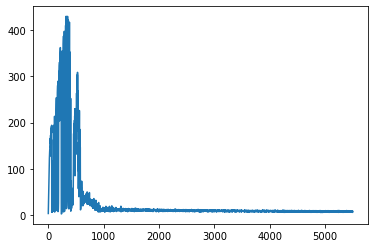

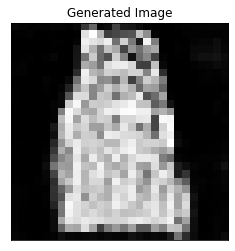

Iteration [5501/10000]......0.116(s) gen: -258.46619 - critic_fake: 256.41031 - critic_real: 264.06267 - neg_critic: 7.65236
Iteration [5502/10000]......0.114(s) gen: -257.70667 - critic_fake: 257.06002 - critic_real: 263.84214 - neg_critic: 6.78212
Iteration [5503/10000]......0.124(s) gen: -258.66602 - critic_fake: 258.23380 - critic_real: 264.76960 - neg_critic: 6.53580
Iteration [5504/10000]......0.114(s) gen: -258.03586 - critic_fake: 257.54605 - critic_real: 265.14821 - neg_critic: 7.60215
Iteration [5505/10000]......0.114(s) gen: -257.14484 - critic_fake: 257.78234 - critic_real: 265.20511 - neg_critic: 7.42277
Iteration [5506/10000]......0.113(s) gen: -254.56271 - critic_fake: 256.64897 - critic_real: 263.72331 - neg_critic: 7.07434
Iteration [5507/10000]......0.113(s) gen: -252.72696 - critic_fake: 254.49041 - critic_real: 263.22949 - neg_critic: 8.73907
Iteration [5508/10000]......0.116(s) gen: -257.70502 - critic_fake: 257.39402 - critic_real: 264.26147 - neg_critic: 6.86745


Iteration [5567/10000]......0.126(s) gen: -257.22302 - critic_fake: 258.51058 - critic_real: 265.13577 - neg_critic: 6.62520
Iteration [5568/10000]......0.124(s) gen: -259.31024 - critic_fake: 257.25009 - critic_real: 264.87673 - neg_critic: 7.62665
Iteration [5569/10000]......0.127(s) gen: -256.37775 - critic_fake: 258.21663 - critic_real: 264.86432 - neg_critic: 6.64769
Iteration [5570/10000]......0.127(s) gen: -256.66620 - critic_fake: 255.91558 - critic_real: 264.16558 - neg_critic: 8.25000
Iteration [5571/10000]......0.126(s) gen: -254.84818 - critic_fake: 255.88867 - critic_real: 264.40238 - neg_critic: 8.51371
Iteration [5572/10000]......0.129(s) gen: -258.35651 - critic_fake: 257.73780 - critic_real: 265.13474 - neg_critic: 7.39694
Iteration [5573/10000]......0.128(s) gen: -254.35164 - critic_fake: 257.31121 - critic_real: 265.36439 - neg_critic: 8.05319
Iteration [5574/10000]......0.128(s) gen: -258.34738 - critic_fake: 258.07980 - critic_real: 265.30159 - neg_critic: 7.22180


Iteration [5633/10000]......0.121(s) gen: -256.36569 - critic_fake: 258.26177 - critic_real: 265.60524 - neg_critic: 7.34346
Iteration [5634/10000]......0.120(s) gen: -258.57968 - critic_fake: 259.11927 - critic_real: 265.70556 - neg_critic: 6.58629
Iteration [5635/10000]......0.120(s) gen: -258.16986 - critic_fake: 257.92172 - critic_real: 266.08964 - neg_critic: 8.16793
Iteration [5636/10000]......0.133(s) gen: -259.31567 - critic_fake: 258.10796 - critic_real: 265.87698 - neg_critic: 7.76902
Iteration [5637/10000]......0.118(s) gen: -258.93610 - critic_fake: 259.34096 - critic_real: 265.67020 - neg_critic: 6.32924
Iteration [5638/10000]......0.117(s) gen: -255.32698 - critic_fake: 257.91569 - critic_real: 265.55255 - neg_critic: 7.63685
Iteration [5639/10000]......0.118(s) gen: -258.40012 - critic_fake: 257.77335 - critic_real: 264.16888 - neg_critic: 6.39554
Iteration [5640/10000]......0.118(s) gen: -258.99316 - critic_fake: 257.53717 - critic_real: 264.31810 - neg_critic: 6.78093


Iteration [5699/10000]......0.116(s) gen: -259.02380 - critic_fake: 258.93680 - critic_real: 266.57298 - neg_critic: 7.63618
Iteration [5700/10000]......0.117(s) gen: -257.74490 - critic_fake: 258.05455 - critic_real: 265.34884 - neg_critic: 7.29429
Iteration [5701/10000]......0.117(s) gen: -258.35852 - critic_fake: 257.92932 - critic_real: 266.10708 - neg_critic: 8.17776
Iteration [5702/10000]......0.118(s) gen: -260.81787 - critic_fake: 259.67246 - critic_real: 265.72820 - neg_critic: 6.05574
Iteration [5703/10000]......0.121(s) gen: -259.50870 - critic_fake: 261.03286 - critic_real: 266.13817 - neg_critic: 5.10530
Iteration [5704/10000]......0.119(s) gen: -259.19196 - critic_fake: 260.55692 - critic_real: 266.78231 - neg_critic: 6.22538
Iteration [5705/10000]......0.121(s) gen: -258.93298 - critic_fake: 258.60311 - critic_real: 265.67993 - neg_critic: 7.07682
Iteration [5706/10000]......0.122(s) gen: -259.80435 - critic_fake: 257.76105 - critic_real: 266.00253 - neg_critic: 8.24148


Iteration [5765/10000]......0.119(s) gen: -260.26483 - critic_fake: 259.65023 - critic_real: 266.57103 - neg_critic: 6.92081
Iteration [5766/10000]......0.121(s) gen: -259.03143 - critic_fake: 260.52198 - critic_real: 266.73990 - neg_critic: 6.21791
Iteration [5767/10000]......0.120(s) gen: -258.98865 - critic_fake: 259.00665 - critic_real: 265.86786 - neg_critic: 6.86121
Iteration [5768/10000]......0.122(s) gen: -257.47018 - critic_fake: 258.27686 - critic_real: 265.94879 - neg_critic: 7.67192
Iteration [5769/10000]......0.122(s) gen: -259.77063 - critic_fake: 258.26169 - critic_real: 265.20947 - neg_critic: 6.94778
Iteration [5770/10000]......0.131(s) gen: -260.18945 - critic_fake: 258.61409 - critic_real: 266.15535 - neg_critic: 7.54125
Iteration [5771/10000]......0.123(s) gen: -259.07452 - critic_fake: 260.12802 - critic_real: 266.52003 - neg_critic: 6.39200
Iteration [5772/10000]......0.121(s) gen: -260.65146 - critic_fake: 259.56672 - critic_real: 266.32682 - neg_critic: 6.76010


Iteration [5831/10000]......0.119(s) gen: -258.25104 - critic_fake: 259.46625 - critic_real: 266.42581 - neg_critic: 6.95956
Iteration [5832/10000]......0.118(s) gen: -258.37393 - critic_fake: 260.42153 - critic_real: 267.48055 - neg_critic: 7.05901
Iteration [5833/10000]......0.118(s) gen: -260.15607 - critic_fake: 260.13645 - critic_real: 267.28819 - neg_critic: 7.15174
Iteration [5834/10000]......0.117(s) gen: -261.08691 - critic_fake: 259.18532 - critic_real: 266.74041 - neg_critic: 7.55508
Iteration [5835/10000]......0.118(s) gen: -260.69855 - critic_fake: 260.56248 - critic_real: 267.24685 - neg_critic: 6.68437
Iteration [5836/10000]......0.118(s) gen: -259.94415 - critic_fake: 257.73928 - critic_real: 266.90902 - neg_critic: 9.16974
Iteration [5837/10000]......0.118(s) gen: -261.03937 - critic_fake: 259.92333 - critic_real: 267.40142 - neg_critic: 7.47808
Iteration [5838/10000]......0.118(s) gen: -261.12860 - critic_fake: 260.61043 - critic_real: 268.27778 - neg_critic: 7.66735


Iteration [5897/10000]......0.122(s) gen: -262.46545 - critic_fake: 260.87383 - critic_real: 268.19971 - neg_critic: 7.32588
Iteration [5898/10000]......0.121(s) gen: -261.56451 - critic_fake: 261.45474 - critic_real: 267.95914 - neg_critic: 6.50439
Iteration [5899/10000]......0.123(s) gen: -260.26294 - critic_fake: 259.62214 - critic_real: 268.00223 - neg_critic: 8.38010
Iteration [5900/10000]......0.123(s) gen: -261.31311 - critic_fake: 261.36321 - critic_real: 268.61152 - neg_critic: 7.24831
Iteration [5901/10000]......0.123(s) gen: -261.22385 - critic_fake: 260.78200 - critic_real: 268.09487 - neg_critic: 7.31287
Iteration [5902/10000]......0.123(s) gen: -261.66553 - critic_fake: 261.26484 - critic_real: 267.98138 - neg_critic: 6.71654
Iteration [5903/10000]......0.122(s) gen: -260.63980 - critic_fake: 260.49825 - critic_real: 267.57689 - neg_critic: 7.07864
Iteration [5904/10000]......0.120(s) gen: -261.18518 - critic_fake: 260.53824 - critic_real: 267.77120 - neg_critic: 7.23296


Iteration [5963/10000]......0.119(s) gen: -259.65625 - critic_fake: 260.48745 - critic_real: 268.10250 - neg_critic: 7.61506
Iteration [5964/10000]......0.123(s) gen: -258.89914 - critic_fake: 259.57334 - critic_real: 266.85479 - neg_critic: 7.28145
Iteration [5965/10000]......0.121(s) gen: -263.17047 - critic_fake: 260.03217 - critic_real: 267.62204 - neg_critic: 7.58987
Iteration [5966/10000]......0.121(s) gen: -262.53735 - critic_fake: 262.71342 - critic_real: 268.23139 - neg_critic: 5.51797
Iteration [5967/10000]......0.119(s) gen: -260.64948 - critic_fake: 262.91444 - critic_real: 268.76260 - neg_critic: 5.84816
Iteration [5968/10000]......0.118(s) gen: -260.29413 - critic_fake: 261.16352 - critic_real: 267.40811 - neg_critic: 6.24459
Iteration [5969/10000]......0.120(s) gen: -260.62222 - critic_fake: 260.72441 - critic_real: 267.53297 - neg_critic: 6.80855
Iteration [5970/10000]......0.121(s) gen: -263.90820 - critic_fake: 261.70579 - critic_real: 268.11118 - neg_critic: 6.40539


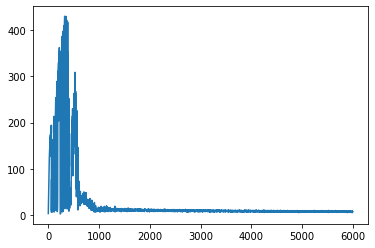

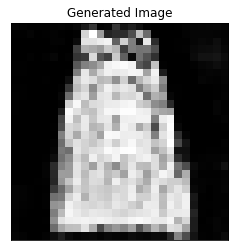

Iteration [6001/10000]......0.115(s) gen: -262.37595 - critic_fake: 262.03231 - critic_real: 269.12803 - neg_critic: 7.09572
Iteration [6002/10000]......0.115(s) gen: -261.74442 - critic_fake: 261.75695 - critic_real: 269.28999 - neg_critic: 7.53304
Iteration [6003/10000]......0.114(s) gen: -260.87891 - critic_fake: 262.70878 - critic_real: 268.84714 - neg_critic: 6.13836
Iteration [6004/10000]......0.116(s) gen: -260.47693 - critic_fake: 260.98702 - critic_real: 268.65018 - neg_critic: 7.66316
Iteration [6005/10000]......0.115(s) gen: -260.71088 - critic_fake: 260.38281 - critic_real: 268.57842 - neg_critic: 8.19561
Iteration [6006/10000]......0.114(s) gen: -263.76282 - critic_fake: 262.29101 - critic_real: 268.63138 - neg_critic: 6.34037
Iteration [6007/10000]......0.114(s) gen: -263.09439 - critic_fake: 263.51192 - critic_real: 268.85897 - neg_critic: 5.34705
Iteration [6008/10000]......0.116(s) gen: -262.46771 - critic_fake: 261.83177 - critic_real: 268.95073 - neg_critic: 7.11896


Iteration [6068/10000]......0.119(s) gen: -262.48083 - critic_fake: 261.95114 - critic_real: 268.91010 - neg_critic: 6.95896
Iteration [6069/10000]......0.120(s) gen: -261.04251 - critic_fake: 261.43317 - critic_real: 268.62968 - neg_critic: 7.19651
Iteration [6070/10000]......0.121(s) gen: -261.97226 - critic_fake: 261.75031 - critic_real: 268.24152 - neg_critic: 6.49122
Iteration [6071/10000]......0.117(s) gen: -262.91861 - critic_fake: 261.08834 - critic_real: 269.17040 - neg_critic: 8.08206
Iteration [6072/10000]......0.118(s) gen: -261.28247 - critic_fake: 262.61099 - critic_real: 268.96203 - neg_critic: 6.35104
Iteration [6073/10000]......0.121(s) gen: -262.65674 - critic_fake: 261.41542 - critic_real: 269.07190 - neg_critic: 7.65648
Iteration [6074/10000]......0.122(s) gen: -262.08600 - critic_fake: 262.62600 - critic_real: 269.39860 - neg_critic: 6.77260
Iteration [6075/10000]......0.121(s) gen: -261.86969 - critic_fake: 262.73892 - critic_real: 270.05673 - neg_critic: 7.31781


Iteration [6134/10000]......0.117(s) gen: -263.21225 - critic_fake: 262.50634 - critic_real: 269.63680 - neg_critic: 7.13046
Iteration [6135/10000]......0.117(s) gen: -263.53516 - critic_fake: 263.01271 - critic_real: 269.65347 - neg_critic: 6.64076
Iteration [6136/10000]......0.117(s) gen: -263.55554 - critic_fake: 262.96007 - critic_real: 270.14042 - neg_critic: 7.18035
Iteration [6137/10000]......0.118(s) gen: -262.04510 - critic_fake: 262.45787 - critic_real: 270.23737 - neg_critic: 7.77949
Iteration [6138/10000]......0.119(s) gen: -263.67123 - critic_fake: 262.79102 - critic_real: 269.75970 - neg_critic: 6.96868
Iteration [6139/10000]......0.118(s) gen: -265.23993 - critic_fake: 263.99440 - critic_real: 270.00790 - neg_critic: 6.01351
Iteration [6140/10000]......0.120(s) gen: -263.71933 - critic_fake: 264.73284 - critic_real: 269.43430 - neg_critic: 4.70146
Iteration [6141/10000]......0.120(s) gen: -263.01306 - critic_fake: 262.70193 - critic_real: 269.22249 - neg_critic: 6.52056


Iteration [6200/10000]......0.120(s) gen: -262.50641 - critic_fake: 263.49481 - critic_real: 270.71971 - neg_critic: 7.22490
Iteration [6201/10000]......0.121(s) gen: -264.07797 - critic_fake: 262.35637 - critic_real: 270.36946 - neg_critic: 8.01309
Iteration [6202/10000]......0.123(s) gen: -264.09302 - critic_fake: 263.78031 - critic_real: 270.43779 - neg_critic: 6.65748
Iteration [6203/10000]......0.121(s) gen: -262.17773 - critic_fake: 263.24921 - critic_real: 270.61966 - neg_critic: 7.37045
Iteration [6204/10000]......0.120(s) gen: -262.25592 - critic_fake: 262.27086 - critic_real: 270.41891 - neg_critic: 8.14806
Iteration [6205/10000]......0.121(s) gen: -265.23285 - critic_fake: 263.22751 - critic_real: 270.07296 - neg_critic: 6.84545
Iteration [6206/10000]......0.119(s) gen: -263.23480 - critic_fake: 264.61621 - critic_real: 270.76396 - neg_critic: 6.14775
Iteration [6207/10000]......0.118(s) gen: -264.21362 - critic_fake: 263.48701 - critic_real: 270.84481 - neg_critic: 7.35779


Iteration [6266/10000]......0.119(s) gen: -265.43741 - critic_fake: 263.79376 - critic_real: 270.07850 - neg_critic: 6.28475
Iteration [6267/10000]......0.117(s) gen: -263.37485 - critic_fake: 264.94636 - critic_real: 270.78215 - neg_critic: 5.83580
Iteration [6268/10000]......0.119(s) gen: -263.90759 - critic_fake: 264.08363 - critic_real: 270.21260 - neg_critic: 6.12897
Iteration [6269/10000]......0.122(s) gen: -261.06992 - critic_fake: 262.42791 - critic_real: 270.39902 - neg_critic: 7.97111
Iteration [6270/10000]......0.118(s) gen: -261.42459 - critic_fake: 261.72076 - critic_real: 270.16048 - neg_critic: 8.43972
Iteration [6271/10000]......0.120(s) gen: -262.02066 - critic_fake: 263.37354 - critic_real: 270.18730 - neg_critic: 6.81376
Iteration [6272/10000]......0.122(s) gen: -263.82028 - critic_fake: 264.14312 - critic_real: 270.72507 - neg_critic: 6.58195
Iteration [6273/10000]......0.122(s) gen: -264.35376 - critic_fake: 263.48293 - critic_real: 270.79981 - neg_critic: 7.31688


Iteration [6332/10000]......0.117(s) gen: -265.64978 - critic_fake: 264.24640 - critic_real: 271.15799 - neg_critic: 6.91159
Iteration [6333/10000]......0.117(s) gen: -263.50580 - critic_fake: 265.02768 - critic_real: 270.92471 - neg_critic: 5.89703
Iteration [6334/10000]......0.118(s) gen: -265.11679 - critic_fake: 263.35362 - critic_real: 270.92558 - neg_critic: 7.57196
Iteration [6335/10000]......0.117(s) gen: -264.93506 - critic_fake: 263.80308 - critic_real: 270.79013 - neg_critic: 6.98705
Iteration [6336/10000]......0.117(s) gen: -262.75958 - critic_fake: 263.65701 - critic_real: 271.10387 - neg_critic: 7.44686
Iteration [6337/10000]......0.117(s) gen: -264.80511 - critic_fake: 262.70775 - critic_real: 270.45414 - neg_critic: 7.74640
Iteration [6338/10000]......0.118(s) gen: -265.84665 - critic_fake: 264.47258 - critic_real: 270.86567 - neg_critic: 6.39309
Iteration [6339/10000]......0.119(s) gen: -264.38672 - critic_fake: 265.88780 - critic_real: 272.32027 - neg_critic: 6.43247


Iteration [6398/10000]......0.119(s) gen: -265.17181 - critic_fake: 264.46922 - critic_real: 271.45751 - neg_critic: 6.98829
Iteration [6399/10000]......0.119(s) gen: -264.21600 - critic_fake: 266.31570 - critic_real: 271.65650 - neg_critic: 5.34080
Iteration [6400/10000]......0.120(s) gen: -264.50497 - critic_fake: 262.38724 - critic_real: 271.24471 - neg_critic: 8.85747
Iteration [6401/10000]......0.119(s) gen: -266.23718 - critic_fake: 265.79329 - critic_real: 271.29357 - neg_critic: 5.50029
Iteration [6402/10000]......0.120(s) gen: -265.25226 - critic_fake: 265.55647 - critic_real: 271.25430 - neg_critic: 5.69783
Iteration [6403/10000]......0.119(s) gen: -264.83740 - critic_fake: 264.69147 - critic_real: 271.45290 - neg_critic: 6.76143
Iteration [6404/10000]......0.117(s) gen: -264.87335 - critic_fake: 264.39867 - critic_real: 270.93303 - neg_critic: 6.53436
Iteration [6405/10000]......0.118(s) gen: -263.80035 - critic_fake: 263.63535 - critic_real: 271.12283 - neg_critic: 7.48748


Iteration [6464/10000]......0.124(s) gen: -263.94202 - critic_fake: 264.68769 - critic_real: 271.81347 - neg_critic: 7.12578
Iteration [6465/10000]......0.121(s) gen: -266.35931 - critic_fake: 264.84602 - critic_real: 272.35575 - neg_critic: 7.50973
Iteration [6466/10000]......0.121(s) gen: -265.17438 - critic_fake: 265.49628 - critic_real: 272.16361 - neg_critic: 6.66733
Iteration [6467/10000]......0.120(s) gen: -264.86157 - critic_fake: 265.70561 - critic_real: 272.64814 - neg_critic: 6.94253
Iteration [6468/10000]......0.130(s) gen: -266.86655 - critic_fake: 265.40242 - critic_real: 272.96565 - neg_critic: 7.56323
Iteration [6469/10000]......0.120(s) gen: -264.79834 - critic_fake: 266.38085 - critic_real: 272.49288 - neg_critic: 6.11202
Iteration [6470/10000]......0.119(s) gen: -267.00342 - critic_fake: 264.69288 - critic_real: 272.32838 - neg_critic: 7.63550
Iteration [6471/10000]......0.119(s) gen: -265.38586 - critic_fake: 266.17267 - critic_real: 272.20631 - neg_critic: 6.03364


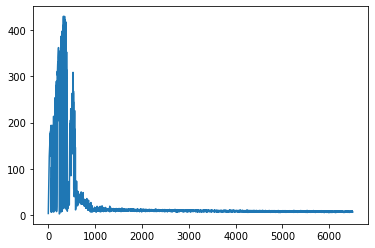

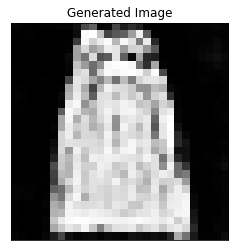

Iteration [6501/10000]......0.116(s) gen: -264.36469 - critic_fake: 264.17114 - critic_real: 271.81448 - neg_critic: 7.64335
Iteration [6502/10000]......0.115(s) gen: -263.96561 - critic_fake: 265.64935 - critic_real: 272.07685 - neg_critic: 6.42750
Iteration [6503/10000]......0.115(s) gen: -262.06006 - critic_fake: 263.90623 - critic_real: 271.22974 - neg_critic: 7.32350
Iteration [6504/10000]......0.116(s) gen: -264.29517 - critic_fake: 264.48600 - critic_real: 271.51092 - neg_critic: 7.02491
Iteration [6505/10000]......0.133(s) gen: -265.08411 - critic_fake: 264.22393 - critic_real: 271.57336 - neg_critic: 7.34943
Iteration [6506/10000]......0.112(s) gen: -266.02826 - critic_fake: 265.56569 - critic_real: 271.55594 - neg_critic: 5.99026
Iteration [6507/10000]......0.119(s) gen: -264.07178 - critic_fake: 265.71690 - critic_real: 271.94642 - neg_critic: 6.22952
Iteration [6508/10000]......0.115(s) gen: -261.92963 - critic_fake: 264.77913 - critic_real: 271.30018 - neg_critic: 6.52105


Iteration [6568/10000]......0.123(s) gen: -265.98419 - critic_fake: 266.75467 - critic_real: 272.98291 - neg_critic: 6.22824
Iteration [6569/10000]......0.121(s) gen: -265.43784 - critic_fake: 266.01669 - critic_real: 272.69268 - neg_critic: 6.67599
Iteration [6570/10000]......0.124(s) gen: -265.57199 - critic_fake: 266.61626 - critic_real: 272.56319 - neg_critic: 5.94693
Iteration [6571/10000]......0.125(s) gen: -265.54239 - critic_fake: 266.18287 - critic_real: 272.32569 - neg_critic: 6.14282
Iteration [6572/10000]......0.129(s) gen: -265.29736 - critic_fake: 265.92194 - critic_real: 272.22479 - neg_critic: 6.30284
Iteration [6573/10000]......0.125(s) gen: -266.24933 - critic_fake: 264.13405 - critic_real: 272.09982 - neg_critic: 7.96578
Iteration [6574/10000]......0.129(s) gen: -264.40454 - critic_fake: 265.91935 - critic_real: 271.39355 - neg_critic: 5.47419
Iteration [6575/10000]......0.126(s) gen: -264.06342 - critic_fake: 264.89362 - critic_real: 272.19268 - neg_critic: 7.29906


Iteration [6634/10000]......0.118(s) gen: -263.86554 - critic_fake: 266.28126 - critic_real: 273.52051 - neg_critic: 7.23925
Iteration [6635/10000]......0.119(s) gen: -264.49475 - critic_fake: 266.59497 - critic_real: 273.81652 - neg_critic: 7.22155
Iteration [6636/10000]......0.118(s) gen: -266.62329 - critic_fake: 265.54769 - critic_real: 273.15710 - neg_critic: 7.60941
Iteration [6637/10000]......0.117(s) gen: -264.38861 - critic_fake: 266.76299 - critic_real: 272.81305 - neg_critic: 6.05005
Iteration [6638/10000]......0.116(s) gen: -267.40210 - critic_fake: 266.92908 - critic_real: 272.50607 - neg_critic: 5.57699
Iteration [6639/10000]......0.117(s) gen: -264.78033 - critic_fake: 266.89783 - critic_real: 273.59628 - neg_critic: 6.69846
Iteration [6640/10000]......0.119(s) gen: -266.03320 - critic_fake: 265.50161 - critic_real: 273.08167 - neg_critic: 7.58005
Iteration [6641/10000]......0.117(s) gen: -265.30884 - critic_fake: 266.76497 - critic_real: 273.92614 - neg_critic: 7.16117


Iteration [6700/10000]......0.121(s) gen: -267.90222 - critic_fake: 266.80843 - critic_real: 274.16693 - neg_critic: 7.35850
Iteration [6701/10000]......0.125(s) gen: -266.81451 - critic_fake: 265.83007 - critic_real: 273.25706 - neg_critic: 7.42700
Iteration [6702/10000]......0.122(s) gen: -265.78976 - critic_fake: 266.14192 - critic_real: 273.50434 - neg_critic: 7.36242
Iteration [6703/10000]......0.120(s) gen: -267.32819 - critic_fake: 266.60562 - critic_real: 273.05540 - neg_critic: 6.44978
Iteration [6704/10000]......0.121(s) gen: -264.27908 - critic_fake: 265.27438 - critic_real: 273.08455 - neg_critic: 7.81017
Iteration [6705/10000]......0.121(s) gen: -265.20871 - critic_fake: 265.96470 - critic_real: 272.93417 - neg_critic: 6.96946
Iteration [6706/10000]......0.123(s) gen: -265.26550 - critic_fake: 265.62811 - critic_real: 273.11564 - neg_critic: 7.48752
Iteration [6707/10000]......0.123(s) gen: -267.75583 - critic_fake: 267.15968 - critic_real: 272.98782 - neg_critic: 5.82814


Iteration [6766/10000]......0.121(s) gen: -266.86597 - critic_fake: 268.25467 - critic_real: 274.69854 - neg_critic: 6.44387
Iteration [6767/10000]......0.118(s) gen: -268.15753 - critic_fake: 267.88256 - critic_real: 274.48835 - neg_critic: 6.60579
Iteration [6768/10000]......0.119(s) gen: -267.78494 - critic_fake: 268.92531 - critic_real: 275.19828 - neg_critic: 6.27297
Iteration [6769/10000]......0.118(s) gen: -268.22549 - critic_fake: 267.26500 - critic_real: 274.12453 - neg_critic: 6.85953
Iteration [6770/10000]......0.121(s) gen: -265.67499 - critic_fake: 267.58480 - critic_real: 274.55263 - neg_critic: 6.96783
Iteration [6771/10000]......0.120(s) gen: -268.09705 - critic_fake: 268.17027 - critic_real: 273.93611 - neg_critic: 5.76584
Iteration [6772/10000]......0.121(s) gen: -269.14600 - critic_fake: 267.96117 - critic_real: 274.15588 - neg_critic: 6.19471
Iteration [6773/10000]......0.121(s) gen: -266.67517 - critic_fake: 267.25517 - critic_real: 274.15575 - neg_critic: 6.90058


Iteration [6832/10000]......0.123(s) gen: -267.28192 - critic_fake: 267.85027 - critic_real: 275.03756 - neg_critic: 7.18729
Iteration [6833/10000]......0.124(s) gen: -269.95135 - critic_fake: 268.18658 - critic_real: 275.36350 - neg_critic: 7.17692
Iteration [6834/10000]......0.125(s) gen: -269.40295 - critic_fake: 269.33281 - critic_real: 275.88674 - neg_critic: 6.55393
Iteration [6835/10000]......0.123(s) gen: -268.37988 - critic_fake: 267.61077 - critic_real: 274.74955 - neg_critic: 7.13878
Iteration [6836/10000]......0.124(s) gen: -268.16174 - critic_fake: 267.83944 - critic_real: 275.49597 - neg_critic: 7.65653
Iteration [6837/10000]......0.119(s) gen: -267.39093 - critic_fake: 268.41099 - critic_real: 275.13745 - neg_critic: 6.72645
Iteration [6838/10000]......0.121(s) gen: -268.10382 - critic_fake: 268.31519 - critic_real: 274.61460 - neg_critic: 6.29941
Iteration [6839/10000]......0.119(s) gen: -268.97583 - critic_fake: 268.16964 - critic_real: 275.22820 - neg_critic: 7.05856


Iteration [6898/10000]......0.122(s) gen: -267.93015 - critic_fake: 268.51359 - critic_real: 275.71887 - neg_critic: 7.20528
Iteration [6899/10000]......0.122(s) gen: -269.14044 - critic_fake: 268.76688 - critic_real: 275.29653 - neg_critic: 6.52964
Iteration [6900/10000]......0.120(s) gen: -268.68158 - critic_fake: 268.85969 - critic_real: 275.96243 - neg_critic: 7.10274
Iteration [6901/10000]......0.120(s) gen: -269.46527 - critic_fake: 267.57814 - critic_real: 275.98992 - neg_critic: 8.41178
Iteration [6902/10000]......0.122(s) gen: -271.09998 - critic_fake: 270.91818 - critic_real: 275.70812 - neg_critic: 4.78995
Iteration [6903/10000]......0.122(s) gen: -270.41241 - critic_fake: 270.96816 - critic_real: 275.95679 - neg_critic: 4.98863
Iteration [6904/10000]......0.121(s) gen: -269.33661 - critic_fake: 270.33043 - critic_real: 276.04417 - neg_critic: 5.71373
Iteration [6905/10000]......0.119(s) gen: -268.93103 - critic_fake: 268.96245 - critic_real: 275.45615 - neg_critic: 6.49370


Iteration [6964/10000]......0.118(s) gen: -269.89316 - critic_fake: 270.49711 - critic_real: 276.58820 - neg_critic: 6.09109
Iteration [6965/10000]......0.121(s) gen: -269.77899 - critic_fake: 268.82593 - critic_real: 275.40356 - neg_critic: 6.57762
Iteration [6966/10000]......0.121(s) gen: -269.72681 - critic_fake: 269.89326 - critic_real: 275.39064 - neg_critic: 5.49739
Iteration [6967/10000]......0.122(s) gen: -270.17822 - critic_fake: 269.22380 - critic_real: 275.82712 - neg_critic: 6.60333
Iteration [6968/10000]......0.120(s) gen: -268.76352 - critic_fake: 269.65129 - critic_real: 275.65217 - neg_critic: 6.00089
Iteration [6969/10000]......0.124(s) gen: -270.42014 - critic_fake: 269.74361 - critic_real: 276.08209 - neg_critic: 6.33848
Iteration [6970/10000]......0.123(s) gen: -267.96341 - critic_fake: 269.47667 - critic_real: 276.97751 - neg_critic: 7.50084
Iteration [6971/10000]......0.124(s) gen: -271.61996 - critic_fake: 269.79202 - critic_real: 276.77469 - neg_critic: 6.98268


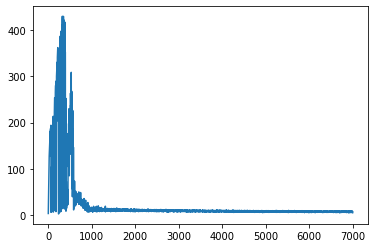

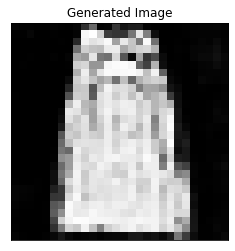

Iteration [7001/10000]......0.119(s) gen: -269.57843 - critic_fake: 269.82057 - critic_real: 276.27909 - neg_critic: 6.45852
Iteration [7002/10000]......0.115(s) gen: -270.61530 - critic_fake: 269.10786 - critic_real: 276.20014 - neg_critic: 7.09228
Iteration [7003/10000]......0.115(s) gen: -269.76477 - critic_fake: 270.43078 - critic_real: 276.39385 - neg_critic: 5.96307
Iteration [7004/10000]......0.115(s) gen: -269.17261 - critic_fake: 268.85035 - critic_real: 276.21107 - neg_critic: 7.36072
Iteration [7005/10000]......0.114(s) gen: -271.40521 - critic_fake: 271.04388 - critic_real: 276.84865 - neg_critic: 5.80477
Iteration [7006/10000]......0.115(s) gen: -270.68048 - critic_fake: 270.58294 - critic_real: 277.07222 - neg_critic: 6.48928
Iteration [7007/10000]......0.116(s) gen: -269.77350 - critic_fake: 269.54566 - critic_real: 276.70234 - neg_critic: 7.15668
Iteration [7008/10000]......0.115(s) gen: -268.06555 - critic_fake: 269.62437 - critic_real: 275.98388 - neg_critic: 6.35951


Iteration [7068/10000]......0.124(s) gen: -270.61133 - critic_fake: 270.24457 - critic_real: 276.78938 - neg_critic: 6.54481
Iteration [7069/10000]......0.126(s) gen: -270.43555 - critic_fake: 270.44834 - critic_real: 277.58303 - neg_critic: 7.13469
Iteration [7070/10000]......0.131(s) gen: -270.96790 - critic_fake: 270.79652 - critic_real: 276.68457 - neg_critic: 5.88805
Iteration [7071/10000]......0.121(s) gen: -270.66437 - critic_fake: 269.41751 - critic_real: 277.06202 - neg_critic: 7.64451
Iteration [7072/10000]......0.121(s) gen: -271.96576 - critic_fake: 268.32947 - critic_real: 276.14250 - neg_critic: 7.81304
Iteration [7073/10000]......0.121(s) gen: -270.22449 - critic_fake: 270.75021 - critic_real: 276.07936 - neg_critic: 5.32914
Iteration [7074/10000]......0.121(s) gen: -268.58957 - critic_fake: 269.48309 - critic_real: 276.05209 - neg_critic: 6.56899
Iteration [7075/10000]......0.121(s) gen: -271.35132 - critic_fake: 270.28394 - critic_real: 277.00144 - neg_critic: 6.71750


Iteration [7134/10000]......0.129(s) gen: -270.23553 - critic_fake: 270.88799 - critic_real: 276.76546 - neg_critic: 5.87747
Iteration [7135/10000]......0.118(s) gen: -269.59326 - critic_fake: 270.89396 - critic_real: 276.67778 - neg_critic: 5.78383
Iteration [7136/10000]......0.120(s) gen: -270.52039 - critic_fake: 270.81844 - critic_real: 277.43461 - neg_critic: 6.61616
Iteration [7137/10000]......0.120(s) gen: -270.99536 - critic_fake: 271.81392 - critic_real: 278.37181 - neg_critic: 6.55789
Iteration [7138/10000]......0.120(s) gen: -271.74567 - critic_fake: 271.70211 - critic_real: 278.10932 - neg_critic: 6.40721
Iteration [7139/10000]......0.121(s) gen: -271.74164 - critic_fake: 271.96981 - critic_real: 277.92351 - neg_critic: 5.95370
Iteration [7140/10000]......0.121(s) gen: -269.86731 - critic_fake: 270.86597 - critic_real: 277.43595 - neg_critic: 6.56998
Iteration [7141/10000]......0.121(s) gen: -267.62164 - critic_fake: 270.16812 - critic_real: 277.33832 - neg_critic: 7.17021


Iteration [7200/10000]......0.118(s) gen: -271.95074 - critic_fake: 271.51541 - critic_real: 278.17823 - neg_critic: 6.66283
Iteration [7201/10000]......0.120(s) gen: -269.76196 - critic_fake: 270.39034 - critic_real: 277.78044 - neg_critic: 7.39011
Iteration [7202/10000]......0.122(s) gen: -271.87418 - critic_fake: 270.86370 - critic_real: 277.93821 - neg_critic: 7.07451
Iteration [7203/10000]......0.120(s) gen: -271.62823 - critic_fake: 271.37487 - critic_real: 278.55210 - neg_critic: 7.17723
Iteration [7204/10000]......0.121(s) gen: -272.10266 - critic_fake: 272.59946 - critic_real: 277.90851 - neg_critic: 5.30906
Iteration [7205/10000]......0.122(s) gen: -272.45135 - critic_fake: 271.59795 - critic_real: 277.83652 - neg_critic: 6.23857
Iteration [7206/10000]......0.122(s) gen: -273.70795 - critic_fake: 272.30605 - critic_real: 278.21925 - neg_critic: 5.91320
Iteration [7207/10000]......0.120(s) gen: -271.41840 - critic_fake: 273.06678 - critic_real: 279.01038 - neg_critic: 5.94359


Iteration [7266/10000]......0.122(s) gen: -273.27472 - critic_fake: 273.90189 - critic_real: 279.35453 - neg_critic: 5.45264
Iteration [7267/10000]......0.122(s) gen: -272.61722 - critic_fake: 271.93764 - critic_real: 279.26713 - neg_critic: 7.32949
Iteration [7268/10000]......0.121(s) gen: -271.87515 - critic_fake: 272.50302 - critic_real: 278.63513 - neg_critic: 6.13210
Iteration [7269/10000]......0.122(s) gen: -273.69781 - critic_fake: 272.28915 - critic_real: 278.57957 - neg_critic: 6.29042
Iteration [7270/10000]......0.122(s) gen: -272.03876 - critic_fake: 273.55850 - critic_real: 278.86712 - neg_critic: 5.30862
Iteration [7271/10000]......0.123(s) gen: -272.19818 - critic_fake: 272.69584 - critic_real: 278.81683 - neg_critic: 6.12099
Iteration [7272/10000]......0.125(s) gen: -270.22702 - critic_fake: 272.27177 - critic_real: 279.08979 - neg_critic: 6.81802
Iteration [7273/10000]......0.123(s) gen: -270.99216 - critic_fake: 271.42197 - critic_real: 278.66290 - neg_critic: 7.24094


Iteration [7332/10000]......0.123(s) gen: -273.50824 - critic_fake: 271.88340 - critic_real: 279.04058 - neg_critic: 7.15718
Iteration [7333/10000]......0.124(s) gen: -273.18463 - critic_fake: 273.11678 - critic_real: 279.38018 - neg_critic: 6.26340
Iteration [7334/10000]......0.122(s) gen: -273.73471 - critic_fake: 274.03239 - critic_real: 279.99537 - neg_critic: 5.96298
Iteration [7335/10000]......0.121(s) gen: -272.69617 - critic_fake: 273.54697 - critic_real: 279.00316 - neg_critic: 5.45619
Iteration [7336/10000]......0.123(s) gen: -272.56134 - critic_fake: 273.79495 - critic_real: 280.15930 - neg_critic: 6.36436
Iteration [7337/10000]......0.123(s) gen: -272.29962 - critic_fake: 272.87804 - critic_real: 279.63978 - neg_critic: 6.76174
Iteration [7338/10000]......0.123(s) gen: -274.22440 - critic_fake: 272.26822 - critic_real: 279.14285 - neg_critic: 6.87463
Iteration [7339/10000]......0.125(s) gen: -273.79898 - critic_fake: 274.69977 - critic_real: 279.99557 - neg_critic: 5.29580


Iteration [7398/10000]......0.123(s) gen: -274.64105 - critic_fake: 274.54319 - critic_real: 280.25296 - neg_critic: 5.70977
Iteration [7399/10000]......0.122(s) gen: -274.45123 - critic_fake: 274.66393 - critic_real: 280.71429 - neg_critic: 6.05036
Iteration [7400/10000]......0.122(s) gen: -273.68149 - critic_fake: 274.07444 - critic_real: 280.70085 - neg_critic: 6.62641
Iteration [7401/10000]......0.124(s) gen: -274.67346 - critic_fake: 273.33964 - critic_real: 280.08932 - neg_critic: 6.74968
Iteration [7402/10000]......0.124(s) gen: -273.39703 - critic_fake: 274.03149 - critic_real: 280.42817 - neg_critic: 6.39668
Iteration [7403/10000]......0.124(s) gen: -272.10828 - critic_fake: 274.56218 - critic_real: 280.38196 - neg_critic: 5.81979
Iteration [7404/10000]......0.121(s) gen: -273.05731 - critic_fake: 273.32153 - critic_real: 280.08768 - neg_critic: 6.76616
Iteration [7405/10000]......0.122(s) gen: -274.07166 - critic_fake: 273.40854 - critic_real: 280.39520 - neg_critic: 6.98666


Iteration [7464/10000]......0.121(s) gen: -274.73694 - critic_fake: 274.65165 - critic_real: 279.87416 - neg_critic: 5.22251
Iteration [7465/10000]......0.121(s) gen: -274.25348 - critic_fake: 274.21365 - critic_real: 280.42062 - neg_critic: 6.20698
Iteration [7466/10000]......0.121(s) gen: -274.80481 - critic_fake: 274.63597 - critic_real: 280.79439 - neg_critic: 6.15842
Iteration [7467/10000]......0.121(s) gen: -274.21051 - critic_fake: 273.11510 - critic_real: 281.07825 - neg_critic: 7.96315
Iteration [7468/10000]......0.123(s) gen: -273.89471 - critic_fake: 274.90840 - critic_real: 280.45483 - neg_critic: 5.54642
Iteration [7469/10000]......0.123(s) gen: -273.97491 - critic_fake: 273.72304 - critic_real: 280.36824 - neg_critic: 6.64520
Iteration [7470/10000]......0.124(s) gen: -273.08524 - critic_fake: 272.75333 - critic_real: 280.10267 - neg_critic: 7.34934
Iteration [7471/10000]......0.124(s) gen: -273.77255 - critic_fake: 274.05675 - critic_real: 281.05776 - neg_critic: 7.00101


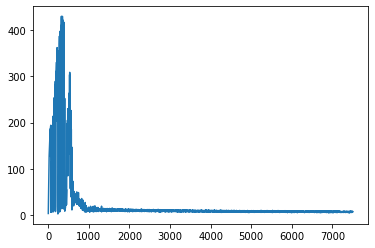

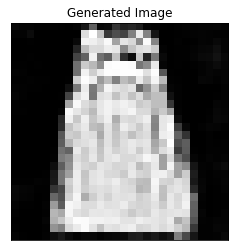

Iteration [7501/10000]......0.121(s) gen: -274.43454 - critic_fake: 274.62216 - critic_real: 280.75130 - neg_critic: 6.12914
Iteration [7502/10000]......0.132(s) gen: -272.21100 - critic_fake: 273.48641 - critic_real: 280.84904 - neg_critic: 7.36263
Iteration [7503/10000]......0.134(s) gen: -274.72452 - critic_fake: 273.18079 - critic_real: 279.98397 - neg_critic: 6.80317
Iteration [7504/10000]......0.133(s) gen: -274.72034 - critic_fake: 274.22823 - critic_real: 280.82516 - neg_critic: 6.59692
Iteration [7505/10000]......0.134(s) gen: -273.71777 - critic_fake: 273.61251 - critic_real: 280.93020 - neg_critic: 7.31769
Iteration [7506/10000]......0.134(s) gen: -273.12183 - critic_fake: 274.25898 - critic_real: 280.80497 - neg_critic: 6.54598
Iteration [7507/10000]......0.134(s) gen: -274.22192 - critic_fake: 275.09916 - critic_real: 282.10167 - neg_critic: 7.00251
Iteration [7508/10000]......0.135(s) gen: -273.59290 - critic_fake: 274.86380 - critic_real: 281.13778 - neg_critic: 6.27398


Iteration [7568/10000]......0.118(s) gen: -273.73895 - critic_fake: 275.63412 - critic_real: 281.47656 - neg_critic: 5.84244
Iteration [7569/10000]......0.119(s) gen: -276.06012 - critic_fake: 274.65569 - critic_real: 281.26264 - neg_critic: 6.60695
Iteration [7570/10000]......0.119(s) gen: -274.77216 - critic_fake: 273.76509 - critic_real: 281.77916 - neg_critic: 8.01407
Iteration [7571/10000]......0.120(s) gen: -276.18457 - critic_fake: 276.16196 - critic_real: 280.60659 - neg_critic: 4.44463
Iteration [7572/10000]......0.121(s) gen: -275.17355 - critic_fake: 275.92570 - critic_real: 281.62714 - neg_critic: 5.70143
Iteration [7573/10000]......0.123(s) gen: -274.31360 - critic_fake: 274.85943 - critic_real: 281.52055 - neg_critic: 6.66112
Iteration [7574/10000]......0.122(s) gen: -275.88855 - critic_fake: 274.99994 - critic_real: 281.25415 - neg_critic: 6.25421
Iteration [7575/10000]......0.120(s) gen: -276.26025 - critic_fake: 275.82480 - critic_real: 281.62654 - neg_critic: 5.80175


Iteration [7634/10000]......0.124(s) gen: -276.59906 - critic_fake: 275.50191 - critic_real: 281.74029 - neg_critic: 6.23838
Iteration [7635/10000]......0.132(s) gen: -277.01614 - critic_fake: 275.88951 - critic_real: 281.96112 - neg_critic: 6.07161
Iteration [7636/10000]......0.123(s) gen: -272.82559 - critic_fake: 275.12404 - critic_real: 281.53143 - neg_critic: 6.40740
Iteration [7637/10000]......0.120(s) gen: -275.77673 - critic_fake: 274.79345 - critic_real: 281.53243 - neg_critic: 6.73898
Iteration [7638/10000]......0.121(s) gen: -273.91296 - critic_fake: 275.28958 - critic_real: 281.67908 - neg_critic: 6.38950
Iteration [7639/10000]......0.124(s) gen: -273.81564 - critic_fake: 275.61520 - critic_real: 282.24503 - neg_critic: 6.62982
Iteration [7640/10000]......0.119(s) gen: -276.23795 - critic_fake: 276.17939 - critic_real: 282.87729 - neg_critic: 6.69791
Iteration [7641/10000]......0.119(s) gen: -274.31351 - critic_fake: 276.09426 - critic_real: 282.51775 - neg_critic: 6.42349


Iteration [7700/10000]......0.121(s) gen: -275.79028 - critic_fake: 276.76486 - critic_real: 282.20832 - neg_critic: 5.44346
Iteration [7701/10000]......0.121(s) gen: -276.72986 - critic_fake: 277.02399 - critic_real: 282.31332 - neg_critic: 5.28933
Iteration [7702/10000]......0.119(s) gen: -276.52570 - critic_fake: 276.29340 - critic_real: 282.72062 - neg_critic: 6.42722
Iteration [7703/10000]......0.119(s) gen: -275.79761 - critic_fake: 276.26574 - critic_real: 282.27599 - neg_critic: 6.01025
Iteration [7704/10000]......0.119(s) gen: -276.80908 - critic_fake: 275.90726 - critic_real: 282.22314 - neg_critic: 6.31588
Iteration [7705/10000]......0.120(s) gen: -276.48557 - critic_fake: 276.00327 - critic_real: 282.41969 - neg_critic: 6.41642
Iteration [7706/10000]......0.119(s) gen: -276.01138 - critic_fake: 276.11813 - critic_real: 282.66781 - neg_critic: 6.54968
Iteration [7707/10000]......0.117(s) gen: -276.50089 - critic_fake: 275.56642 - critic_real: 282.36068 - neg_critic: 6.79426


Iteration [7766/10000]......0.118(s) gen: -275.76312 - critic_fake: 276.99631 - critic_real: 283.92120 - neg_critic: 6.92489
Iteration [7767/10000]......0.117(s) gen: -276.88504 - critic_fake: 277.22114 - critic_real: 283.68989 - neg_critic: 6.46875
Iteration [7768/10000]......0.119(s) gen: -278.68445 - critic_fake: 276.87195 - critic_real: 283.51095 - neg_critic: 6.63900
Iteration [7769/10000]......0.117(s) gen: -276.29840 - critic_fake: 278.47109 - critic_real: 284.06473 - neg_critic: 5.59364
Iteration [7770/10000]......0.118(s) gen: -275.99854 - critic_fake: 277.12180 - critic_real: 283.04742 - neg_critic: 5.92562
Iteration [7771/10000]......0.118(s) gen: -277.62244 - critic_fake: 275.68112 - critic_real: 282.96496 - neg_critic: 7.28384
Iteration [7772/10000]......0.122(s) gen: -277.37927 - critic_fake: 277.54747 - critic_real: 282.95991 - neg_critic: 5.41245
Iteration [7773/10000]......0.124(s) gen: -277.98578 - critic_fake: 276.77794 - critic_real: 283.55569 - neg_critic: 6.77775


Iteration [7832/10000]......0.124(s) gen: -276.32816 - critic_fake: 276.72003 - critic_real: 284.11476 - neg_critic: 7.39473
Iteration [7833/10000]......0.122(s) gen: -278.18695 - critic_fake: 277.41143 - critic_real: 284.08685 - neg_critic: 6.67542
Iteration [7834/10000]......0.124(s) gen: -277.07370 - critic_fake: 277.63810 - critic_real: 284.17519 - neg_critic: 6.53708
Iteration [7835/10000]......0.124(s) gen: -277.79926 - critic_fake: 277.12513 - critic_real: 283.85328 - neg_critic: 6.72815
Iteration [7836/10000]......0.123(s) gen: -277.51654 - critic_fake: 277.69874 - critic_real: 283.70283 - neg_critic: 6.00409
Iteration [7837/10000]......0.121(s) gen: -277.90857 - critic_fake: 278.72235 - critic_real: 284.27748 - neg_critic: 5.55513
Iteration [7838/10000]......0.120(s) gen: -277.95227 - critic_fake: 278.46608 - critic_real: 283.69252 - neg_critic: 5.22645
Iteration [7839/10000]......0.120(s) gen: -278.15234 - critic_fake: 277.09775 - critic_real: 283.75957 - neg_critic: 6.66182


Iteration [7898/10000]......0.121(s) gen: -279.40674 - critic_fake: 278.53739 - critic_real: 285.51044 - neg_critic: 6.97305
Iteration [7899/10000]......0.121(s) gen: -277.08539 - critic_fake: 278.65349 - critic_real: 284.81292 - neg_critic: 6.15943
Iteration [7900/10000]......0.121(s) gen: -276.62515 - critic_fake: 277.15467 - critic_real: 284.09723 - neg_critic: 6.94256
Iteration [7901/10000]......0.121(s) gen: -277.72565 - critic_fake: 278.36767 - critic_real: 284.83989 - neg_critic: 6.47222
Iteration [7902/10000]......0.122(s) gen: -278.06580 - critic_fake: 278.32822 - critic_real: 284.62249 - neg_critic: 6.29426
Iteration [7903/10000]......0.121(s) gen: -278.95212 - critic_fake: 277.91525 - critic_real: 284.83578 - neg_critic: 6.92053
Iteration [7904/10000]......0.121(s) gen: -278.92844 - critic_fake: 278.44765 - critic_real: 284.80989 - neg_critic: 6.36224
Iteration [7905/10000]......0.120(s) gen: -279.15674 - critic_fake: 279.31024 - critic_real: 284.13939 - neg_critic: 4.82915


Iteration [7964/10000]......0.120(s) gen: -279.64362 - critic_fake: 278.42634 - critic_real: 285.96513 - neg_critic: 7.53879
Iteration [7965/10000]......0.120(s) gen: -279.43106 - critic_fake: 278.87971 - critic_real: 285.39413 - neg_critic: 6.51443
Iteration [7966/10000]......0.121(s) gen: -277.38708 - critic_fake: 278.78267 - critic_real: 284.59612 - neg_critic: 5.81345
Iteration [7967/10000]......0.120(s) gen: -277.25732 - critic_fake: 278.12361 - critic_real: 284.85903 - neg_critic: 6.73541
Iteration [7968/10000]......0.119(s) gen: -279.41006 - critic_fake: 279.42692 - critic_real: 284.72277 - neg_critic: 5.29586
Iteration [7969/10000]......0.120(s) gen: -278.37128 - critic_fake: 279.08470 - critic_real: 285.34067 - neg_critic: 6.25597
Iteration [7970/10000]......0.121(s) gen: -278.68967 - critic_fake: 278.78204 - critic_real: 285.51050 - neg_critic: 6.72846
Iteration [7971/10000]......0.121(s) gen: -279.36340 - critic_fake: 278.79166 - critic_real: 285.50870 - neg_critic: 6.71705


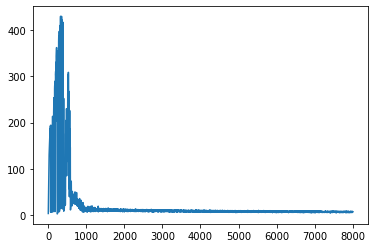

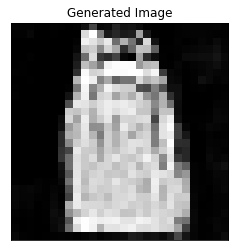

Iteration [8001/10000]......0.116(s) gen: -279.07184 - critic_fake: 278.61678 - critic_real: 284.89545 - neg_critic: 6.27867
Iteration [8002/10000]......0.115(s) gen: -279.57022 - critic_fake: 279.18682 - critic_real: 285.34341 - neg_critic: 6.15659
Iteration [8003/10000]......0.116(s) gen: -279.48413 - critic_fake: 278.58106 - critic_real: 285.33828 - neg_critic: 6.75722
Iteration [8004/10000]......0.117(s) gen: -279.16998 - critic_fake: 278.33582 - critic_real: 285.26364 - neg_critic: 6.92781
Iteration [8005/10000]......0.115(s) gen: -279.16620 - critic_fake: 279.13241 - critic_real: 285.09130 - neg_critic: 5.95889
Iteration [8006/10000]......0.116(s) gen: -278.01941 - critic_fake: 279.07446 - critic_real: 285.42021 - neg_critic: 6.34575
Iteration [8007/10000]......0.117(s) gen: -277.56311 - critic_fake: 278.66508 - critic_real: 284.88607 - neg_critic: 6.22100
Iteration [8008/10000]......0.118(s) gen: -278.10880 - critic_fake: 278.15542 - critic_real: 285.41260 - neg_critic: 7.25718


Iteration [8067/10000]......0.123(s) gen: -279.25201 - critic_fake: 278.87766 - critic_real: 285.84350 - neg_critic: 6.96584
Iteration [8068/10000]......0.123(s) gen: -279.63303 - critic_fake: 278.94551 - critic_real: 285.43448 - neg_critic: 6.48898
Iteration [8069/10000]......0.124(s) gen: -278.35303 - critic_fake: 279.53741 - critic_real: 285.86375 - neg_critic: 6.32634
Iteration [8070/10000]......0.123(s) gen: -279.22461 - critic_fake: 281.04937 - critic_real: 286.24724 - neg_critic: 5.19787
Iteration [8071/10000]......0.125(s) gen: -278.77930 - critic_fake: 279.98325 - critic_real: 285.81447 - neg_critic: 5.83123
Iteration [8072/10000]......0.121(s) gen: -279.16583 - critic_fake: 278.98579 - critic_real: 285.40637 - neg_critic: 6.42058
Iteration [8073/10000]......0.121(s) gen: -277.81390 - critic_fake: 279.06755 - critic_real: 285.64061 - neg_critic: 6.57306
Iteration [8074/10000]......0.120(s) gen: -278.65491 - critic_fake: 279.27301 - critic_real: 285.38003 - neg_critic: 6.10702


Iteration [8133/10000]......0.120(s) gen: -281.86768 - critic_fake: 281.77493 - critic_real: 286.87839 - neg_critic: 5.10347
Iteration [8134/10000]......0.120(s) gen: -280.66269 - critic_fake: 281.80456 - critic_real: 287.45165 - neg_critic: 5.64709
Iteration [8135/10000]......0.121(s) gen: -281.06543 - critic_fake: 279.74509 - critic_real: 286.81324 - neg_critic: 7.06815
Iteration [8136/10000]......0.121(s) gen: -280.72363 - critic_fake: 279.19144 - critic_real: 286.92841 - neg_critic: 7.73698
Iteration [8137/10000]......0.122(s) gen: -280.71884 - critic_fake: 281.04003 - critic_real: 286.66450 - neg_critic: 5.62448
Iteration [8138/10000]......0.121(s) gen: -280.25116 - critic_fake: 281.61062 - critic_real: 287.32666 - neg_critic: 5.71604
Iteration [8139/10000]......0.123(s) gen: -281.04266 - critic_fake: 280.34885 - critic_real: 286.81769 - neg_critic: 6.46885
Iteration [8140/10000]......0.122(s) gen: -281.96329 - critic_fake: 281.01277 - critic_real: 286.84304 - neg_critic: 5.83027


Iteration [8199/10000]......0.122(s) gen: -279.69257 - critic_fake: 280.00488 - critic_real: 286.32283 - neg_critic: 6.31795
Iteration [8200/10000]......0.122(s) gen: -279.95163 - critic_fake: 280.74888 - critic_real: 286.28849 - neg_critic: 5.53961
Iteration [8201/10000]......0.124(s) gen: -280.07599 - critic_fake: 280.76434 - critic_real: 286.89929 - neg_critic: 6.13495
Iteration [8202/10000]......0.124(s) gen: -279.58542 - critic_fake: 280.46526 - critic_real: 286.71938 - neg_critic: 6.25412
Iteration [8203/10000]......0.123(s) gen: -280.26028 - critic_fake: 280.29067 - critic_real: 287.19392 - neg_critic: 6.90325
Iteration [8204/10000]......0.121(s) gen: -280.27258 - critic_fake: 280.20833 - critic_real: 286.52072 - neg_critic: 6.31238
Iteration [8205/10000]......0.122(s) gen: -280.37756 - critic_fake: 279.02376 - critic_real: 286.08176 - neg_critic: 7.05800
Iteration [8206/10000]......0.121(s) gen: -279.57281 - critic_fake: 279.28020 - critic_real: 285.83825 - neg_critic: 6.55805


Iteration [8265/10000]......0.122(s) gen: -280.95383 - critic_fake: 281.14856 - critic_real: 287.65115 - neg_critic: 6.50259
Iteration [8266/10000]......0.122(s) gen: -282.37219 - critic_fake: 281.91818 - critic_real: 287.86552 - neg_critic: 5.94734
Iteration [8267/10000]......0.121(s) gen: -279.55707 - critic_fake: 281.18802 - critic_real: 287.74337 - neg_critic: 6.55535
Iteration [8268/10000]......0.123(s) gen: -281.54431 - critic_fake: 280.13619 - critic_real: 287.49160 - neg_critic: 7.35541
Iteration [8269/10000]......0.122(s) gen: -280.94940 - critic_fake: 281.69284 - critic_real: 286.65093 - neg_critic: 4.95809
Iteration [8270/10000]......0.122(s) gen: -280.73569 - critic_fake: 281.63130 - critic_real: 287.54016 - neg_critic: 5.90886
Iteration [8271/10000]......0.123(s) gen: -281.67282 - critic_fake: 281.10806 - critic_real: 287.30212 - neg_critic: 6.19407
Iteration [8272/10000]......0.125(s) gen: -282.37933 - critic_fake: 282.19528 - critic_real: 287.49006 - neg_critic: 5.29478


Iteration [8331/10000]......0.122(s) gen: -280.88431 - critic_fake: 281.87415 - critic_real: 288.24207 - neg_critic: 6.36791
Iteration [8332/10000]......0.122(s) gen: -282.44229 - critic_fake: 281.95892 - critic_real: 287.38063 - neg_critic: 5.42171
Iteration [8333/10000]......0.122(s) gen: -279.62253 - critic_fake: 281.28559 - critic_real: 287.66194 - neg_critic: 6.37635
Iteration [8334/10000]......0.121(s) gen: -282.61194 - critic_fake: 280.97273 - critic_real: 287.31254 - neg_critic: 6.33981
Iteration [8335/10000]......0.121(s) gen: -282.29718 - critic_fake: 282.40004 - critic_real: 288.53565 - neg_critic: 6.13561
Iteration [8336/10000]......0.121(s) gen: -279.95557 - critic_fake: 282.57739 - critic_real: 288.37892 - neg_critic: 5.80153
Iteration [8337/10000]......0.120(s) gen: -281.69357 - critic_fake: 282.32855 - critic_real: 288.32208 - neg_critic: 5.99353
Iteration [8338/10000]......0.121(s) gen: -282.79401 - critic_fake: 280.78450 - critic_real: 287.55818 - neg_critic: 6.77368


Iteration [8397/10000]......0.119(s) gen: -281.52020 - critic_fake: 283.25665 - critic_real: 288.96583 - neg_critic: 5.70919
Iteration [8398/10000]......0.120(s) gen: -283.01575 - critic_fake: 283.15158 - critic_real: 288.84971 - neg_critic: 5.69813
Iteration [8399/10000]......0.122(s) gen: -281.29449 - critic_fake: 282.35375 - critic_real: 288.71085 - neg_critic: 6.35710
Iteration [8400/10000]......0.121(s) gen: -282.23175 - critic_fake: 282.41088 - critic_real: 288.83306 - neg_critic: 6.42218
Iteration [8401/10000]......0.123(s) gen: -282.25830 - critic_fake: 282.04015 - critic_real: 288.60172 - neg_critic: 6.56157
Iteration [8402/10000]......0.124(s) gen: -282.78470 - critic_fake: 282.60403 - critic_real: 288.19866 - neg_critic: 5.59464
Iteration [8403/10000]......0.125(s) gen: -281.74597 - critic_fake: 281.23384 - critic_real: 287.49490 - neg_critic: 6.26106
Iteration [8404/10000]......0.124(s) gen: -283.36652 - critic_fake: 283.17845 - critic_real: 288.64896 - neg_critic: 5.47050


Iteration [8463/10000]......0.121(s) gen: -283.28918 - critic_fake: 282.69740 - critic_real: 289.64622 - neg_critic: 6.94882
Iteration [8464/10000]......0.122(s) gen: -282.67432 - critic_fake: 283.46918 - critic_real: 289.42505 - neg_critic: 5.95587
Iteration [8465/10000]......0.121(s) gen: -283.47296 - critic_fake: 282.32028 - critic_real: 288.57415 - neg_critic: 6.25387
Iteration [8466/10000]......0.121(s) gen: -281.92282 - critic_fake: 283.18193 - critic_real: 289.19730 - neg_critic: 6.01536
Iteration [8467/10000]......0.121(s) gen: -281.54767 - critic_fake: 282.13863 - critic_real: 288.65497 - neg_critic: 6.51635
Iteration [8468/10000]......0.120(s) gen: -283.36710 - critic_fake: 282.51970 - critic_real: 289.31293 - neg_critic: 6.79323
Iteration [8469/10000]......0.121(s) gen: -283.83151 - critic_fake: 283.04887 - critic_real: 289.27609 - neg_critic: 6.22722
Iteration [8470/10000]......0.119(s) gen: -281.19205 - critic_fake: 283.62976 - critic_real: 289.16611 - neg_critic: 5.53635


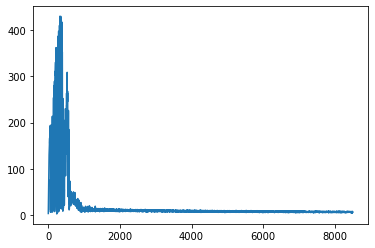

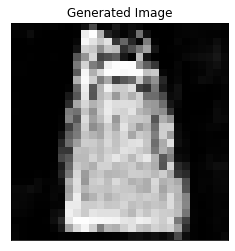

Iteration [8501/10000]......0.121(s) gen: -285.02512 - critic_fake: 284.11789 - critic_real: 290.05944 - neg_critic: 5.94155
Iteration [8502/10000]......0.116(s) gen: -283.96326 - critic_fake: 284.80404 - critic_real: 289.97123 - neg_critic: 5.16719
Iteration [8503/10000]......0.114(s) gen: -284.36682 - critic_fake: 284.45094 - critic_real: 290.02934 - neg_critic: 5.57840
Iteration [8504/10000]......0.113(s) gen: -283.56351 - critic_fake: 284.28250 - critic_real: 289.90139 - neg_critic: 5.61889
Iteration [8505/10000]......0.115(s) gen: -282.51923 - critic_fake: 283.22256 - critic_real: 289.23435 - neg_critic: 6.01179
Iteration [8506/10000]......0.114(s) gen: -281.98190 - critic_fake: 282.23303 - critic_real: 289.24877 - neg_critic: 7.01574
Iteration [8507/10000]......0.113(s) gen: -281.44238 - critic_fake: 282.53298 - critic_real: 288.64627 - neg_critic: 6.11329
Iteration [8508/10000]......0.114(s) gen: -281.65274 - critic_fake: 282.41089 - critic_real: 288.97476 - neg_critic: 6.56387


Iteration [8567/10000]......0.124(s) gen: -281.54681 - critic_fake: 283.60994 - critic_real: 290.12175 - neg_critic: 6.51182
Iteration [8568/10000]......0.124(s) gen: -284.28757 - critic_fake: 283.54191 - critic_real: 289.62175 - neg_critic: 6.07984
Iteration [8569/10000]......0.124(s) gen: -283.38745 - critic_fake: 283.26589 - critic_real: 289.47834 - neg_critic: 6.21245
Iteration [8570/10000]......0.122(s) gen: -283.08179 - critic_fake: 282.70869 - critic_real: 289.58026 - neg_critic: 6.87157
Iteration [8571/10000]......0.121(s) gen: -284.48694 - critic_fake: 283.61611 - critic_real: 290.03702 - neg_critic: 6.42091
Iteration [8572/10000]......0.121(s) gen: -283.70392 - critic_fake: 285.04192 - critic_real: 289.55649 - neg_critic: 4.51458
Iteration [8573/10000]......0.123(s) gen: -284.02750 - critic_fake: 283.33632 - critic_real: 289.76179 - neg_critic: 6.42547
Iteration [8574/10000]......0.122(s) gen: -283.79346 - critic_fake: 283.10084 - critic_real: 289.76193 - neg_critic: 6.66110


Iteration [8633/10000]......0.118(s) gen: -284.50006 - critic_fake: 284.82896 - critic_real: 290.07585 - neg_critic: 5.24690
Iteration [8634/10000]......0.117(s) gen: -284.32019 - critic_fake: 283.29691 - critic_real: 290.17532 - neg_critic: 6.87841
Iteration [8635/10000]......0.117(s) gen: -282.88831 - critic_fake: 282.83171 - critic_real: 290.83587 - neg_critic: 8.00416
Iteration [8636/10000]......0.118(s) gen: -285.66046 - critic_fake: 283.72424 - critic_real: 290.47572 - neg_critic: 6.75148
Iteration [8637/10000]......0.118(s) gen: -284.61389 - critic_fake: 284.69975 - critic_real: 291.16533 - neg_critic: 6.46558
Iteration [8638/10000]......0.117(s) gen: -284.84808 - critic_fake: 285.66541 - critic_real: 290.97753 - neg_critic: 5.31213
Iteration [8639/10000]......0.116(s) gen: -284.05176 - critic_fake: 284.79205 - critic_real: 290.93303 - neg_critic: 6.14098
Iteration [8640/10000]......0.117(s) gen: -286.29422 - critic_fake: 284.75671 - critic_real: 290.61723 - neg_critic: 5.86052


Iteration [8699/10000]......0.120(s) gen: -286.11108 - critic_fake: 286.60034 - critic_real: 291.71122 - neg_critic: 5.11088
Iteration [8700/10000]......0.120(s) gen: -285.64490 - critic_fake: 285.65484 - critic_real: 291.38026 - neg_critic: 5.72542
Iteration [8701/10000]......0.120(s) gen: -284.47217 - critic_fake: 285.09340 - critic_real: 290.85743 - neg_critic: 5.76403
Iteration [8702/10000]......0.119(s) gen: -283.10590 - critic_fake: 283.68211 - critic_real: 290.71252 - neg_critic: 7.03041
Iteration [8703/10000]......0.121(s) gen: -284.41187 - critic_fake: 284.65399 - critic_real: 290.82697 - neg_critic: 6.17299
Iteration [8704/10000]......0.120(s) gen: -285.93713 - critic_fake: 284.60397 - critic_real: 290.02272 - neg_critic: 5.41874
Iteration [8705/10000]......0.121(s) gen: -285.53595 - critic_fake: 286.07886 - critic_real: 291.28318 - neg_critic: 5.20432
Iteration [8706/10000]......0.122(s) gen: -285.43582 - critic_fake: 284.86548 - critic_real: 291.18207 - neg_critic: 6.31659


Iteration [8765/10000]......0.121(s) gen: -285.60706 - critic_fake: 286.26838 - critic_real: 292.22740 - neg_critic: 5.95901
Iteration [8766/10000]......0.122(s) gen: -286.53992 - critic_fake: 285.82952 - critic_real: 292.07592 - neg_critic: 6.24641
Iteration [8767/10000]......0.122(s) gen: -285.95316 - critic_fake: 286.15190 - critic_real: 292.19109 - neg_critic: 6.03919
Iteration [8768/10000]......0.120(s) gen: -284.75119 - critic_fake: 285.31169 - critic_real: 291.97211 - neg_critic: 6.66042
Iteration [8769/10000]......0.121(s) gen: -285.96756 - critic_fake: 284.83604 - critic_real: 291.23433 - neg_critic: 6.39829
Iteration [8770/10000]......0.121(s) gen: -284.72717 - critic_fake: 285.10593 - critic_real: 291.22548 - neg_critic: 6.11955
Iteration [8771/10000]......0.121(s) gen: -285.21469 - critic_fake: 284.45232 - critic_real: 291.58629 - neg_critic: 7.13397
Iteration [8772/10000]......0.119(s) gen: -284.32858 - critic_fake: 284.50517 - critic_real: 291.09294 - neg_critic: 6.58777


Iteration [8831/10000]......0.122(s) gen: -286.23068 - critic_fake: 287.00078 - critic_real: 292.70978 - neg_critic: 5.70900
Iteration [8832/10000]......0.123(s) gen: -287.25531 - critic_fake: 286.21019 - critic_real: 292.50988 - neg_critic: 6.29969
Iteration [8833/10000]......0.124(s) gen: -286.84149 - critic_fake: 285.95777 - critic_real: 293.07824 - neg_critic: 7.12047
Iteration [8834/10000]......0.123(s) gen: -285.74518 - critic_fake: 287.23906 - critic_real: 292.97072 - neg_critic: 5.73167
Iteration [8835/10000]......0.124(s) gen: -286.27863 - critic_fake: 286.68796 - critic_real: 292.26154 - neg_critic: 5.57357
Iteration [8836/10000]......0.124(s) gen: -286.09192 - critic_fake: 285.88184 - critic_real: 292.13917 - neg_critic: 6.25733
Iteration [8837/10000]......0.123(s) gen: -284.28278 - critic_fake: 284.77466 - critic_real: 292.10306 - neg_critic: 7.32840
Iteration [8838/10000]......0.123(s) gen: -286.65967 - critic_fake: 286.56934 - critic_real: 292.54877 - neg_critic: 5.97943


Iteration [8897/10000]......0.121(s) gen: -286.76553 - critic_fake: 287.01723 - critic_real: 292.93732 - neg_critic: 5.92009
Iteration [8898/10000]......0.122(s) gen: -286.87140 - critic_fake: 285.82211 - critic_real: 292.81635 - neg_critic: 6.99423
Iteration [8899/10000]......0.120(s) gen: -287.56323 - critic_fake: 286.18021 - critic_real: 292.11898 - neg_critic: 5.93878
Iteration [8900/10000]......0.119(s) gen: -286.75604 - critic_fake: 286.99910 - critic_real: 292.57692 - neg_critic: 5.57782
Iteration [8901/10000]......0.119(s) gen: -286.61847 - critic_fake: 286.49271 - critic_real: 292.72018 - neg_critic: 6.22747
Iteration [8902/10000]......0.120(s) gen: -287.11578 - critic_fake: 287.38110 - critic_real: 292.52582 - neg_critic: 5.14473
Iteration [8903/10000]......0.122(s) gen: -287.67377 - critic_fake: 287.53918 - critic_real: 292.92706 - neg_critic: 5.38788
Iteration [8904/10000]......0.121(s) gen: -286.15262 - critic_fake: 287.64146 - critic_real: 293.62311 - neg_critic: 5.98165


Iteration [8963/10000]......0.122(s) gen: -288.41794 - critic_fake: 288.11524 - critic_real: 293.93069 - neg_critic: 5.81545
Iteration [8964/10000]......0.122(s) gen: -286.87122 - critic_fake: 287.93886 - critic_real: 293.78985 - neg_critic: 5.85099
Iteration [8965/10000]......0.121(s) gen: -287.87952 - critic_fake: 287.23624 - critic_real: 293.92153 - neg_critic: 6.68529
Iteration [8966/10000]......0.121(s) gen: -284.95920 - critic_fake: 286.67927 - critic_real: 293.45403 - neg_critic: 6.77476
Iteration [8967/10000]......0.119(s) gen: -288.99841 - critic_fake: 286.35446 - critic_real: 293.02617 - neg_critic: 6.67172
Iteration [8968/10000]......0.119(s) gen: -287.11548 - critic_fake: 287.89359 - critic_real: 293.45436 - neg_critic: 5.56078
Iteration [8969/10000]......0.118(s) gen: -288.35641 - critic_fake: 287.66113 - critic_real: 293.51976 - neg_critic: 5.85864
Iteration [8970/10000]......0.118(s) gen: -287.38950 - critic_fake: 287.26470 - critic_real: 293.14408 - neg_critic: 5.87938


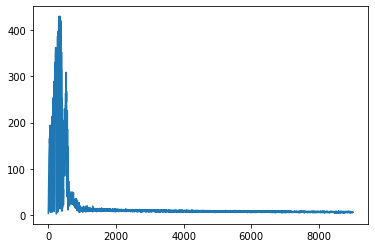

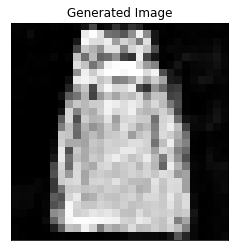

Iteration [9001/10000]......0.126(s) gen: -286.60889 - critic_fake: 287.95820 - critic_real: 294.25443 - neg_critic: 6.29622
Iteration [9002/10000]......0.135(s) gen: -288.05585 - critic_fake: 288.10087 - critic_real: 294.08846 - neg_critic: 5.98759
Iteration [9003/10000]......0.135(s) gen: -287.34790 - critic_fake: 288.08678 - critic_real: 294.56168 - neg_critic: 6.47490
Iteration [9004/10000]......0.134(s) gen: -288.06079 - critic_fake: 288.73440 - critic_real: 294.25719 - neg_critic: 5.52279
Iteration [9005/10000]......0.135(s) gen: -287.46594 - critic_fake: 288.11818 - critic_real: 294.47170 - neg_critic: 6.35352
Iteration [9006/10000]......0.133(s) gen: -288.98074 - critic_fake: 286.99970 - critic_real: 293.93165 - neg_critic: 6.93195
Iteration [9007/10000]......0.134(s) gen: -287.49716 - critic_fake: 288.40413 - critic_real: 294.13774 - neg_critic: 5.73362
Iteration [9008/10000]......0.134(s) gen: -287.69739 - critic_fake: 287.42492 - critic_real: 293.77080 - neg_critic: 6.34588


Iteration [9067/10000]......0.122(s) gen: -287.44379 - critic_fake: 289.01432 - critic_real: 294.74348 - neg_critic: 5.72915
Iteration [9068/10000]......0.122(s) gen: -289.55402 - critic_fake: 288.25204 - critic_real: 294.08676 - neg_critic: 5.83472
Iteration [9069/10000]......0.120(s) gen: -288.11221 - critic_fake: 289.16211 - critic_real: 294.85117 - neg_critic: 5.68906
Iteration [9070/10000]......0.121(s) gen: -287.66800 - critic_fake: 288.34314 - critic_real: 294.90201 - neg_critic: 6.55887
Iteration [9071/10000]......0.120(s) gen: -289.43250 - critic_fake: 289.99263 - critic_real: 294.99733 - neg_critic: 5.00471
Iteration [9072/10000]......0.120(s) gen: -288.01471 - critic_fake: 288.72299 - critic_real: 295.52886 - neg_critic: 6.80587
Iteration [9073/10000]......0.120(s) gen: -288.33423 - critic_fake: 288.70267 - critic_real: 294.91919 - neg_critic: 6.21652
Iteration [9074/10000]......0.119(s) gen: -289.61215 - critic_fake: 289.62438 - critic_real: 295.01155 - neg_critic: 5.38717


Iteration [9133/10000]......0.119(s) gen: -289.41376 - critic_fake: 289.97859 - critic_real: 296.06364 - neg_critic: 6.08505
Iteration [9134/10000]......0.120(s) gen: -288.91779 - critic_fake: 288.57350 - critic_real: 295.47664 - neg_critic: 6.90314
Iteration [9135/10000]......0.120(s) gen: -288.96655 - critic_fake: 288.63434 - critic_real: 295.07720 - neg_critic: 6.44286
Iteration [9136/10000]......0.121(s) gen: -288.64191 - critic_fake: 289.22280 - critic_real: 294.64142 - neg_critic: 5.41862
Iteration [9137/10000]......0.120(s) gen: -290.82037 - critic_fake: 289.23766 - critic_real: 294.65086 - neg_critic: 5.41320
Iteration [9138/10000]......0.121(s) gen: -289.67838 - critic_fake: 290.03220 - critic_real: 295.39857 - neg_critic: 5.36638
Iteration [9139/10000]......0.121(s) gen: -288.44135 - critic_fake: 289.29771 - critic_real: 295.03229 - neg_critic: 5.73458
Iteration [9140/10000]......0.118(s) gen: -289.28516 - critic_fake: 288.65369 - critic_real: 294.44603 - neg_critic: 5.79234


Iteration [9199/10000]......0.125(s) gen: -289.62424 - critic_fake: 290.69124 - critic_real: 296.90089 - neg_critic: 6.20966
Iteration [9200/10000]......0.124(s) gen: -288.72791 - critic_fake: 289.75482 - critic_real: 295.91769 - neg_critic: 6.16287
Iteration [9201/10000]......0.122(s) gen: -290.80402 - critic_fake: 289.51633 - critic_real: 295.68635 - neg_critic: 6.17002
Iteration [9202/10000]......0.120(s) gen: -289.99094 - critic_fake: 290.41987 - critic_real: 296.26143 - neg_critic: 5.84156
Iteration [9203/10000]......0.119(s) gen: -291.31506 - critic_fake: 290.34221 - critic_real: 296.05519 - neg_critic: 5.71298
Iteration [9204/10000]......0.120(s) gen: -289.92242 - critic_fake: 291.05634 - critic_real: 296.14634 - neg_critic: 5.09000
Iteration [9205/10000]......0.122(s) gen: -289.89203 - critic_fake: 288.86585 - critic_real: 295.22936 - neg_critic: 6.36351
Iteration [9206/10000]......0.122(s) gen: -288.65515 - critic_fake: 289.26523 - critic_real: 295.25043 - neg_critic: 5.98519


Iteration [9265/10000]......0.121(s) gen: -290.20209 - critic_fake: 290.19413 - critic_real: 296.48835 - neg_critic: 6.29423
Iteration [9266/10000]......0.121(s) gen: -288.52252 - critic_fake: 289.71147 - critic_real: 296.86343 - neg_critic: 7.15196
Iteration [9267/10000]......0.119(s) gen: -290.27725 - critic_fake: 290.83794 - critic_real: 296.70927 - neg_critic: 5.87133
Iteration [9268/10000]......0.118(s) gen: -292.27097 - critic_fake: 290.06916 - critic_real: 296.54719 - neg_critic: 6.47803
Iteration [9269/10000]......0.118(s) gen: -292.03592 - critic_fake: 290.81412 - critic_real: 296.75486 - neg_critic: 5.94075
Iteration [9270/10000]......0.120(s) gen: -288.29550 - critic_fake: 291.13478 - critic_real: 297.46875 - neg_critic: 6.33397
Iteration [9271/10000]......0.121(s) gen: -289.07349 - critic_fake: 289.61118 - critic_real: 296.26122 - neg_critic: 6.65004
Iteration [9272/10000]......0.121(s) gen: -289.78506 - critic_fake: 290.26312 - critic_real: 296.24775 - neg_critic: 5.98463


Iteration [9331/10000]......0.121(s) gen: -290.68506 - critic_fake: 290.70426 - critic_real: 296.96563 - neg_critic: 6.26137
Iteration [9332/10000]......0.120(s) gen: -292.41028 - critic_fake: 291.29455 - critic_real: 296.93470 - neg_critic: 5.64016
Iteration [9333/10000]......0.121(s) gen: -290.55743 - critic_fake: 291.86494 - critic_real: 297.16367 - neg_critic: 5.29873
Iteration [9334/10000]......0.119(s) gen: -292.09161 - critic_fake: 290.53681 - critic_real: 297.31559 - neg_critic: 6.77878
Iteration [9335/10000]......0.122(s) gen: -291.32196 - critic_fake: 292.50460 - critic_real: 297.43617 - neg_critic: 4.93157
Iteration [9336/10000]......0.119(s) gen: -290.44736 - critic_fake: 290.84958 - critic_real: 296.92064 - neg_critic: 6.07106
Iteration [9337/10000]......0.119(s) gen: -290.37903 - critic_fake: 290.46199 - critic_real: 297.07916 - neg_critic: 6.61716
Iteration [9338/10000]......0.121(s) gen: -291.76660 - critic_fake: 291.33877 - critic_real: 296.95240 - neg_critic: 5.61364


Iteration [9397/10000]......0.119(s) gen: -291.81931 - critic_fake: 292.03447 - critic_real: 298.10803 - neg_critic: 6.07355
Iteration [9398/10000]......0.119(s) gen: -293.57751 - critic_fake: 292.05762 - critic_real: 298.25330 - neg_critic: 6.19568
Iteration [9399/10000]......0.119(s) gen: -291.41046 - critic_fake: 292.62455 - critic_real: 297.76859 - neg_critic: 5.14404
Iteration [9400/10000]......0.120(s) gen: -291.92282 - critic_fake: 290.98522 - critic_real: 297.58760 - neg_critic: 6.60237
Iteration [9401/10000]......0.121(s) gen: -291.14465 - critic_fake: 291.31611 - critic_real: 297.74125 - neg_critic: 6.42513
Iteration [9402/10000]......0.121(s) gen: -292.41034 - critic_fake: 292.20499 - critic_real: 297.91996 - neg_critic: 5.71498
Iteration [9403/10000]......0.120(s) gen: -291.14502 - critic_fake: 291.63187 - critic_real: 297.81066 - neg_critic: 6.17878
Iteration [9404/10000]......0.122(s) gen: -293.05515 - critic_fake: 291.03446 - critic_real: 297.68752 - neg_critic: 6.65306


Iteration [9463/10000]......0.118(s) gen: -288.84354 - critic_fake: 291.02320 - critic_real: 297.29963 - neg_critic: 6.27643
Iteration [9464/10000]......0.119(s) gen: -291.37482 - critic_fake: 291.53629 - critic_real: 297.11453 - neg_critic: 5.57823
Iteration [9465/10000]......0.119(s) gen: -291.13397 - critic_fake: 291.57179 - critic_real: 298.08989 - neg_critic: 6.51810
Iteration [9466/10000]......0.119(s) gen: -292.00748 - critic_fake: 292.02621 - critic_real: 297.68130 - neg_critic: 5.65509
Iteration [9467/10000]......0.118(s) gen: -292.90195 - critic_fake: 291.98494 - critic_real: 298.37596 - neg_critic: 6.39102
Iteration [9468/10000]......0.120(s) gen: -290.56024 - critic_fake: 291.97104 - critic_real: 297.96563 - neg_critic: 5.99459
Iteration [9469/10000]......0.120(s) gen: -291.29013 - critic_fake: 291.83921 - critic_real: 297.67166 - neg_critic: 5.83245
Iteration [9470/10000]......0.121(s) gen: -291.92609 - critic_fake: 291.63677 - critic_real: 297.52967 - neg_critic: 5.89290


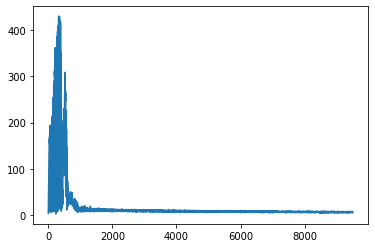

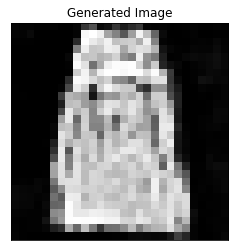

Iteration [9501/10000]......0.134(s) gen: -292.61774 - critic_fake: 292.03768 - critic_real: 298.32715 - neg_critic: 6.28947
Iteration [9502/10000]......0.126(s) gen: -291.63037 - critic_fake: 292.46014 - critic_real: 298.63484 - neg_critic: 6.17469
Iteration [9503/10000]......0.120(s) gen: -292.48065 - critic_fake: 292.43386 - critic_real: 298.26895 - neg_critic: 5.83509
Iteration [9504/10000]......0.118(s) gen: -291.79572 - critic_fake: 292.61301 - critic_real: 298.75504 - neg_critic: 6.14203
Iteration [9505/10000]......0.118(s) gen: -291.54297 - critic_fake: 292.08317 - critic_real: 298.31445 - neg_critic: 6.23128
Iteration [9506/10000]......0.118(s) gen: -291.86243 - critic_fake: 291.80390 - critic_real: 298.43788 - neg_critic: 6.63398
Iteration [9507/10000]......0.118(s) gen: -292.23776 - critic_fake: 293.08017 - critic_real: 298.63989 - neg_critic: 5.55972
Iteration [9508/10000]......0.121(s) gen: -292.81598 - critic_fake: 292.23777 - critic_real: 298.69154 - neg_critic: 6.45377


Iteration [9568/10000]......0.123(s) gen: -292.88370 - critic_fake: 293.42885 - critic_real: 299.33965 - neg_critic: 5.91080
Iteration [9569/10000]......0.122(s) gen: -291.44006 - critic_fake: 292.00454 - critic_real: 299.32557 - neg_critic: 7.32103
Iteration [9570/10000]......0.123(s) gen: -293.65265 - critic_fake: 293.72516 - critic_real: 299.10316 - neg_critic: 5.37800
Iteration [9571/10000]......0.123(s) gen: -294.40985 - critic_fake: 292.58217 - critic_real: 298.81503 - neg_critic: 6.23286
Iteration [9572/10000]......0.124(s) gen: -292.47678 - critic_fake: 293.56230 - critic_real: 299.36775 - neg_critic: 5.80544
Iteration [9573/10000]......0.121(s) gen: -292.34296 - critic_fake: 292.63893 - critic_real: 298.61713 - neg_critic: 5.97820
Iteration [9574/10000]......0.121(s) gen: -291.85321 - critic_fake: 292.48316 - critic_real: 298.98760 - neg_critic: 6.50444
Iteration [9575/10000]......0.119(s) gen: -292.98898 - critic_fake: 292.99769 - critic_real: 299.25196 - neg_critic: 6.25427


Iteration [9634/10000]......0.123(s) gen: -294.23962 - critic_fake: 294.52179 - critic_real: 299.10173 - neg_critic: 4.57994
Iteration [9635/10000]......0.121(s) gen: -294.36475 - critic_fake: 293.54594 - critic_real: 299.44023 - neg_critic: 5.89430
Iteration [9636/10000]......0.121(s) gen: -292.31812 - critic_fake: 292.99575 - critic_real: 299.73984 - neg_critic: 6.74409
Iteration [9637/10000]......0.120(s) gen: -294.77869 - critic_fake: 294.85366 - critic_real: 300.06833 - neg_critic: 5.21468
Iteration [9638/10000]......0.121(s) gen: -295.08289 - critic_fake: 294.22848 - critic_real: 299.49901 - neg_critic: 5.27053
Iteration [9639/10000]......0.120(s) gen: -292.86066 - critic_fake: 293.83843 - critic_real: 299.62240 - neg_critic: 5.78397
Iteration [9640/10000]......0.120(s) gen: -293.67068 - critic_fake: 293.63030 - critic_real: 299.12960 - neg_critic: 5.49929
Iteration [9641/10000]......0.121(s) gen: -292.72424 - critic_fake: 293.40902 - critic_real: 298.87341 - neg_critic: 5.46439


Iteration [9700/10000]......0.120(s) gen: -294.56708 - critic_fake: 294.84561 - critic_real: 300.54180 - neg_critic: 5.69619
Iteration [9701/10000]......0.118(s) gen: -294.11856 - critic_fake: 294.63903 - critic_real: 300.56419 - neg_critic: 5.92516
Iteration [9702/10000]......0.118(s) gen: -293.40616 - critic_fake: 294.18393 - critic_real: 300.31130 - neg_critic: 6.12737
Iteration [9703/10000]......0.120(s) gen: -293.75806 - critic_fake: 294.43815 - critic_real: 300.52438 - neg_critic: 6.08623
Iteration [9704/10000]......0.120(s) gen: -293.96036 - critic_fake: 293.78126 - critic_real: 300.58388 - neg_critic: 6.80262
Iteration [9705/10000]......0.122(s) gen: -294.71173 - critic_fake: 295.38819 - critic_real: 300.68813 - neg_critic: 5.29994
Iteration [9706/10000]......0.121(s) gen: -293.43845 - critic_fake: 293.33527 - critic_real: 299.80062 - neg_critic: 6.46535
Iteration [9707/10000]......0.121(s) gen: -294.53387 - critic_fake: 294.11191 - critic_real: 300.24260 - neg_critic: 6.13069


Iteration [9766/10000]......0.124(s) gen: -296.12970 - critic_fake: 294.71133 - critic_real: 300.55690 - neg_critic: 5.84557
Iteration [9767/10000]......0.124(s) gen: -293.68042 - critic_fake: 295.37625 - critic_real: 300.54845 - neg_critic: 5.17220
Iteration [9768/10000]......0.123(s) gen: -295.10022 - critic_fake: 294.58296 - critic_real: 300.43894 - neg_critic: 5.85598
Iteration [9769/10000]......0.120(s) gen: -294.49854 - critic_fake: 294.53558 - critic_real: 300.89801 - neg_critic: 6.36243
Iteration [9770/10000]......0.120(s) gen: -296.18237 - critic_fake: 294.99748 - critic_real: 300.71729 - neg_critic: 5.71981
Iteration [9771/10000]......0.121(s) gen: -296.08865 - critic_fake: 295.06660 - critic_real: 300.37397 - neg_critic: 5.30738
Iteration [9772/10000]......0.121(s) gen: -295.29593 - critic_fake: 295.57755 - critic_real: 300.68976 - neg_critic: 5.11221
Iteration [9773/10000]......0.120(s) gen: -295.39188 - critic_fake: 294.89214 - critic_real: 300.63962 - neg_critic: 5.74749


Iteration [9832/10000]......0.121(s) gen: -293.81757 - critic_fake: 295.18910 - critic_real: 300.66221 - neg_critic: 5.47311
Iteration [9833/10000]......0.120(s) gen: -294.19766 - critic_fake: 293.72032 - critic_real: 300.28001 - neg_critic: 6.55969
Iteration [9834/10000]......0.121(s) gen: -295.40698 - critic_fake: 295.40868 - critic_real: 300.88177 - neg_critic: 5.47310
Iteration [9835/10000]......0.122(s) gen: -297.12762 - critic_fake: 295.05146 - critic_real: 301.74438 - neg_critic: 6.69293
Iteration [9836/10000]......0.122(s) gen: -295.72803 - critic_fake: 296.57047 - critic_real: 301.94850 - neg_critic: 5.37803
Iteration [9837/10000]......0.122(s) gen: -294.45923 - critic_fake: 294.63166 - critic_real: 300.88752 - neg_critic: 6.25587
Iteration [9838/10000]......0.122(s) gen: -297.03772 - critic_fake: 295.88252 - critic_real: 300.98835 - neg_critic: 5.10583
Iteration [9839/10000]......0.121(s) gen: -294.63657 - critic_fake: 295.40461 - critic_real: 301.44662 - neg_critic: 6.04202


Iteration [9898/10000]......0.121(s) gen: -296.08441 - critic_fake: 295.77457 - critic_real: 301.87401 - neg_critic: 6.09944
Iteration [9899/10000]......0.121(s) gen: -296.34500 - critic_fake: 295.35188 - critic_real: 302.43605 - neg_critic: 7.08417
Iteration [9900/10000]......0.122(s) gen: -297.12314 - critic_fake: 297.04877 - critic_real: 301.86807 - neg_critic: 4.81931
Iteration [9901/10000]......0.122(s) gen: -295.05832 - critic_fake: 295.43928 - critic_real: 301.73669 - neg_critic: 6.29741
Iteration [9902/10000]......0.123(s) gen: -294.89594 - critic_fake: 295.81346 - critic_real: 301.64315 - neg_critic: 5.82968
Iteration [9903/10000]......0.127(s) gen: -295.64740 - critic_fake: 295.46279 - critic_real: 301.42707 - neg_critic: 5.96428
Iteration [9904/10000]......0.129(s) gen: -296.91388 - critic_fake: 295.38882 - critic_real: 301.51730 - neg_critic: 6.12848
Iteration [9905/10000]......0.127(s) gen: -296.05954 - critic_fake: 295.09588 - critic_real: 301.92732 - neg_critic: 6.83144


Iteration [9964/10000]......0.123(s) gen: -296.67786 - critic_fake: 295.64617 - critic_real: 302.32784 - neg_critic: 6.68167
Iteration [9965/10000]......0.120(s) gen: -296.46814 - critic_fake: 296.73120 - critic_real: 302.47530 - neg_critic: 5.74410
Iteration [9966/10000]......0.121(s) gen: -296.67627 - critic_fake: 296.99094 - critic_real: 302.83535 - neg_critic: 5.84442
Iteration [9967/10000]......0.121(s) gen: -296.14169 - critic_fake: 296.51102 - critic_real: 302.87198 - neg_critic: 6.36096
Iteration [9968/10000]......0.122(s) gen: -296.55725 - critic_fake: 296.67869 - critic_real: 302.08803 - neg_critic: 5.40934
Iteration [9969/10000]......0.120(s) gen: -296.34201 - critic_fake: 296.94537 - critic_real: 302.65446 - neg_critic: 5.70909
Iteration [9970/10000]......0.121(s) gen: -296.79007 - critic_fake: 296.91747 - critic_real: 302.38618 - neg_critic: 5.46870
Iteration [9971/10000]......0.121(s) gen: -296.90961 - critic_fake: 296.17000 - critic_real: 302.14731 - neg_critic: 5.97732


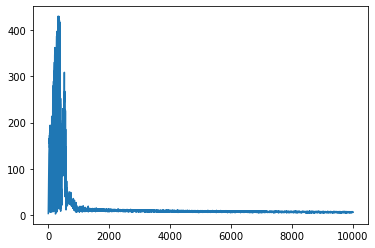

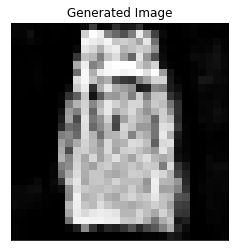

checkpointing at epoch: 10000


In [11]:
import time
from pathlib import Path

start_epoch = 1
epochs = 10000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 500
n_critic = 5



plt.ioff()

model_type = f'dragan'
data_name = f'fashion-MNIST'


#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](x_train)
        num_batches = len(training_imgs) // batch_size
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        critic_real_list = []
        critic_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1, latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 
        
        
        critic_real_sum = 0
        critic_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            critic_real, critic_fake = train_step_critic(img_batch)
            critic_real_sum += K.get_value(critic_real)
            critic_fake_sum += K.get_value(critic_fake)            
        
        
        
        gen_loss = train_step_generator()
        
        
        
        critic_real = critic_real_sum/n_critic
        critic_fake = critic_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        critic_real_list.append(critic_real)
        critic_fake_list.append(critic_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'critic_fake: {critic_fake:.5f} - ', end='')
        print(f'critic_real: {critic_real:.5f} - ', end='')
        print(f'neg_critic: {critic_real - critic_fake:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            
            # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(critic_real_list)-np.array(critic_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(28,28), cmap='gray')
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            critic.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic-weights.h5').as_posix())
            critic.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic.h5').as_posix())
            

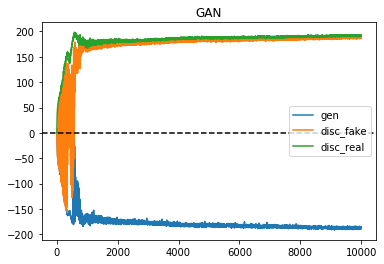

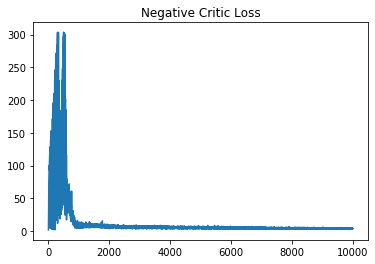

In [26]:
plt.plot(gen_loss_list, label="gen")
plt.plot(critic_fake_list, label="critic_fake")
plt.plot(critic_real_list, label="critic_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(critic_real_list)-np.array(critic_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

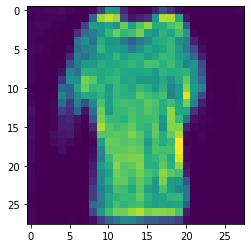

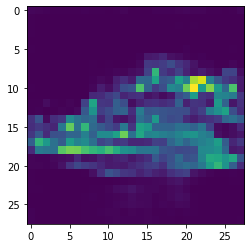

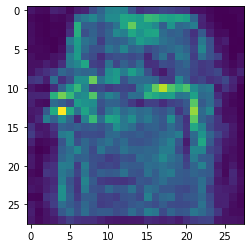

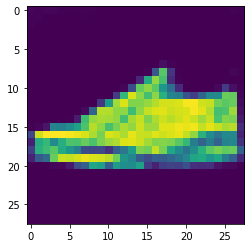

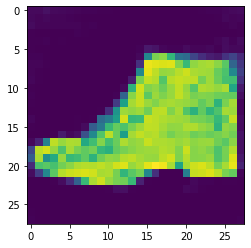

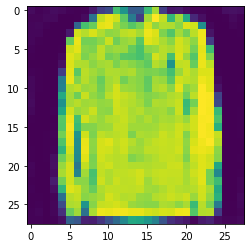

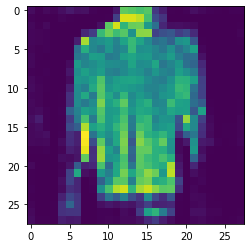

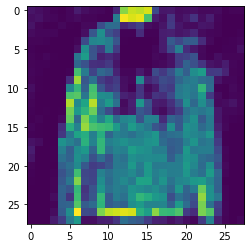

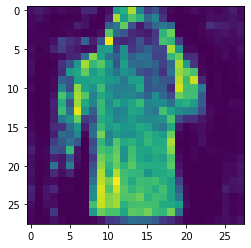

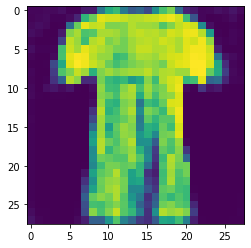

In [25]:
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(28,28), cmap='gray')
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(100., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )


for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(x_test[i].reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img.reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=10.)
grid[1].set_title('Generated Images', fontsize=10.)
plt.show()